In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
import os
from pathlib import Path

scripts_dir = Path().resolve()
parent_dir = scripts_dir.parent
sys.path.insert(0, str(parent_dir))
import Functions.HMM as HMM
import Functions.kinematics as kinematics
import Functions.patch as patch
from SSM.ssm.plots import gradient_cmap
from scipy.stats import expon
import statsmodels.api as sm

color_names = ['black', "blue", "red", "tan", "green", "brown", "purple", "orange", 'turquoise', "yellow", 'pink', 'darkblue']
aeon_dir = scripts_dir.parent.parent/'aeon_mecha'/'aeon'
sys.path.insert(0, str(aeon_dir))
import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02, exp01
from aeon.analysis.utils import visits, distancetravelled
from aeon.schema.schemas import social02, social01

In [18]:
LABELS = [
    ['Pre','BAA-1104045'],
    ['Pre','BAA-1104047'],
    ['Post','BAA-1104045'],
    ['Post','BAA-1104047']
]

In [19]:
dfs = []
for i in range(len(LABELS)):
    if i != 0: continue
    type, mouse = LABELS[i][0], LABELS[i][1]
    Visits = pd.read_parquet('../SocialData/VisitData/'  + type + "_" + mouse +'_Visit.parquet', engine='pyarrow')
    
    Visits = Visits.dropna(subset=['speed'])
    Visits['distance'] = abs(Visits['distance'])
    Visits = Visits[Visits['distance'] >= 1]

    dfs.append(Visits)
        
Visits = pd.concat(dfs, ignore_index=True)
Visits = Visits.sort_values(by='start',ignore_index=True) 
display(Visits)

,start,end,distance,duration,speed,acceleration,bodylength,bodyangle,nose,entry,patch,pellet,last_pellets_self,last_pellets_other,last_interval,next_interval,last_duration,last_pellets_interval
0,2024-01-31 13:41:08.765984058,2024-01-31 13:41:23.265984058,2.842640,14.500000,37.486785,73.116853,34.306372,165.796754,10.246397,18.185984,Patch1,0,0,0,0.000000,692.239999,0.000000,0.000000
1,2024-01-31 13:52:55.505983829,2024-01-31 13:53:47.305984020,23.644689,51.800000,92.766858,176.311815,37.326756,166.895440,9.669256,98.325983,Patch2,0,0,0,692.239999,23.139999,14.500000,706.739999
2,2024-01-31 13:54:10.445983887,2024-01-31 13:54:30.035999775,3.511496,19.590015,109.714515,215.324621,37.566278,162.454729,8.381000,173.265983,Patch2,0,0,0,23.139999,447.448000,51.800000,781.679998
3,2024-01-31 14:01:57.484000206,2024-01-31 14:02:21.613984108,10.517614,24.129983,62.514143,153.401640,38.941498,164.885620,10.627267,9.804000,Patch2,0,0,0,447.448000,282.770015,19.590015,1248.718013
4,2024-01-31 14:07:04.383999825,2024-01-31 14:07:14.473983765,1.974354,10.089983,44.366099,96.022387,34.222164,163.608021,8.480437,65.903999,Patch2,0,0,0,282.770015,79.460000,24.129983,1555.618011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2024-02-03 12:25:47.693984032,2024-02-03 12:26:00.964000225,27.033459,13.270016,102.965512,133.781273,32.481422,155.191169,10.946157,22.193984,Patch1,0,1,0,287.751999,235.557983,14.429984,295.419999
147,2024-02-03 12:37:54.211999893,2024-02-03 12:38:29.261983870,295.340007,35.049983,51.422438,74.437200,22.004182,134.812424,9.613616,2.011999,Patch3,0,0,0,56.019999,0.342016,28.610015,102.639996
148,2024-02-03 12:38:29.604000092,2024-02-03 12:38:48.713984013,76.304862,19.109983,186.918809,206.139437,35.453735,162.865730,10.073677,5.504000,Patch1,1,0,0,0.342016,18.519999,35.049983,138.031995
149,2024-02-03 12:39:07.233983994,2024-02-03 12:45:39.253983974,3055.566362,392.019999,1.827956,3.332993,25.893449,142.354187,8.504632,43.133983,Patch1,8,1,0,18.519999,169.558015,19.109983,18.519999


In [23]:
FEATURES = ['speed','acceleration','bodylength','bodyangle','nose','last_pellets_self', 'last_pellets_other','last_duration', 'last_interval','last_pellets_interval', 'entry']
PREDICTOR = 'duration'
X = Visits[FEATURES]
Y = Visits[[PREDICTOR]]
Y_ = sigmoid(Y, midpoint = 217, scale = 22)
Y_

,duration
0,0.000101
1,0.000548
2,0.000127
3,0.000156
4,0.000082
...,...
146,0.000095
147,0.000256
148,0.000124
149,0.999649


In [37]:
import statsmodels.api as sm
model = sm.GLM(Y_, X, family=sm.families.Gaussian()) 
result = model.fit()
Y_test_pred = result.predict(X)

Y_test_pred = inverse_sigmoid(Y_test_pred.to_numpy(), midpoint=217, scale=20)
Y_test = inverse_sigmoid(Y_.to_numpy().reshape(1,-1)[0], midpoint=217, scale=20)

In [42]:
Y_test_pred = result.predict(X)
Y_test_pred

0      0.080076
1      0.199733
2      0.285476
3      0.102310
4      0.181458
         ...   
146    0.118043
147    0.051724
148    0.190750
149    0.080700
150   -0.033209
Length: 151, dtype: float64

In [70]:
i=0
type, mouse = LABELS[i][0], LABELS[i][1]
Visits = pd.read_parquet('../SocialData/VisitData/'  + type + "_" + mouse +'_Visit.parquet', engine='pyarrow')

Visits = Visits.dropna(subset=['speed'])
Visits['distance'] = abs(Visits['distance'])
Visits = Visits[Visits['distance'] >= 1]
Visits = Visits.sort_values(by='start',ignore_index=True)  
display(Visits)

,start,end,distance,duration,speed,acceleration,entry,patch,pellet,last_pellets_self,last_pellets_other,last_interval,next_interval,last_duration,last_pellets_interval
0,2024-01-31 13:41:08.765984058,2024-01-31 13:41:23.265984058,2.842640,14.500000,37.486785,73.116853,18.185984,Patch1,0,0,0,0.000000,692.239999,0.000000,0.000000
1,2024-01-31 13:52:55.505983829,2024-01-31 13:53:47.305984020,23.644689,51.800000,92.766858,176.311815,98.325983,Patch2,0,0,0,692.239999,23.139999,14.500000,706.739999
2,2024-01-31 13:54:10.445983887,2024-01-31 13:54:30.035999775,3.511496,19.590015,109.714515,215.324621,173.265983,Patch2,0,0,0,23.139999,447.448000,51.800000,781.679998
3,2024-01-31 14:01:57.484000206,2024-01-31 14:02:21.613984108,10.517614,24.129983,62.514143,153.401640,9.804000,Patch2,0,0,0,447.448000,282.770015,19.590015,1248.718013
4,2024-01-31 14:07:04.383999825,2024-01-31 14:07:14.473983765,1.974354,10.089983,44.366099,96.022387,65.903999,Patch2,0,0,0,282.770015,79.460000,24.129983,1555.618011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2024-02-03 12:25:47.693984032,2024-02-03 12:26:00.964000225,27.033459,13.270016,102.965512,133.781273,22.193984,Patch1,0,1,0,287.751999,235.557983,14.429984,295.419999
147,2024-02-03 12:37:54.211999893,2024-02-03 12:38:29.261983870,295.340007,35.049983,51.422438,74.437200,2.011999,Patch3,0,0,0,56.019999,0.342016,28.610015,102.639996
148,2024-02-03 12:38:29.604000092,2024-02-03 12:38:48.713984013,76.304862,19.109983,186.918809,206.139437,5.504000,Patch1,1,0,0,0.342016,18.519999,35.049983,138.031995
149,2024-02-03 12:39:07.233983994,2024-02-03 12:45:39.253983974,3055.566362,392.019999,1.827956,3.332993,43.133983,Patch1,8,1,0,18.519999,169.558015,19.109983,18.519999


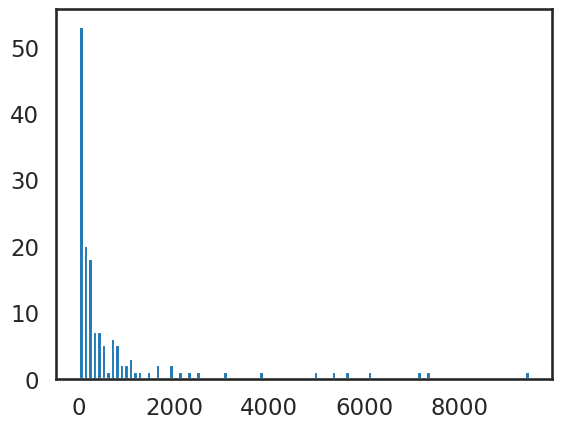

In [82]:
D = np.array(Visits['next_interval'])
plt.hist(D[D<10000], bins = 100)
plt.savefig('Duration.png')
plt.show()

In [84]:
mouse_pos = pd.read_parquet('../SocialData/HMMData/' + type + "_" + mouse + '.parquet', engine='pyarrow')
mouse_pos.head()

,x,y,smoothed_position_x,smoothed_position_y,smoothed_speed,smoothed_acceleration,r,bodylength,bodyangle,nose
2024-01-31 11:28:50.980,1227.229492,466.738770,1203.806593,456.461437,51.466773,514.125286,477.059374,36.649667,162.630915,10.681781
2024-01-31 11:28:51.080,1226.488281,447.859833,1204.037480,447.673143,124.407116,730.544140,479.315228,35.476446,156.407667,11.240065
2024-01-31 11:28:51.180,1221.697266,429.415253,1203.715550,431.787910,193.464855,695.259303,483.059921,36.772010,158.210517,10.245219
2024-01-31 11:28:51.280,1215.799438,408.055542,1202.128225,409.945380,244.714633,527.401470,487.918385,37.948691,156.908161,11.479248
2024-01-31 11:28:51.380,1205.654785,381.634918,1198.719435,384.253148,273.902348,336.337952,493.376312,38.171811,165.244365,10.142888


In [78]:
for i in range(len(Visits)):
    if Visits.next_interval[i] > 40000:
        display(Visits.loc[i-1])
        display(Visits.loc[i])
        display(Visits.loc[i+1])

start                    2024-01-31 18:26:52.377984047
end                      2024-01-31 18:27:02.457983971
distance                                      2.107818
duration                                     10.079999
speed                                        51.763524
acceleration                                 143.88209
entry                                         7.697984
patch                                           Patch3
pellet                                               0
last_pellets_self                                    0
last_pellets_other                                   0
last_interval                                   810.34
next_interval                                10.630015
last_duration                                59.949984
last_pellets_interval                      1955.617983
Name: 26, dtype: object

start                    2024-01-31 18:27:13.087999821
end                      2024-01-31 18:27:37.717984200
distance                                     11.665102
duration                                     24.629984
speed                                       131.267588
acceleration                                368.834355
entry                                         3.407999
patch                                           Patch3
pellet                                               0
last_pellets_self                                    0
last_pellets_other                                   0
last_interval                                10.630015
next_interval                             45878.599999
last_duration                                10.079999
last_pellets_interval                      1976.327997
Name: 27, dtype: object

start                    2024-02-01 07:12:16.317984104
end                      2024-02-01 07:16:08.297984123
distance                                   1400.442732
duration                                        231.98
speed                                        48.353832
acceleration                                 93.674365
entry                                         5.037984
patch                                           Patch3
pellet                                               9
last_pellets_self                                    0
last_pellets_other                                   0
last_interval                             45878.599999
next_interval                               227.759999
last_duration                                24.629984
last_pellets_interval                      47879.55798
Name: 28, dtype: object

In [ ]:
type, mouse = LABELS[0][0], LABELS[0][1]
mouse_pos = pd.read_parquet('../SocialData/HMMData/' + type + "_" + mouse + '.parquet', engine='pyarrow')
starts = [pd.Timestamp('2024-01-31 11:28:39.00'), pd.Timestamp('2024-02-01 22:36:47.00'), pd.Timestamp('2024-02-02 00:15:00.00')]
for i in range(len(starts)):
    if i == len(starts) - 1: 
        mouse_pos_ = mouse_pos[starts[i]:]
    else:
        mouse_pos_ = mouse_pos[starts[i]:starts[i+1]]
    display(mouse_pos_.head())
    display(mouse_pos_.tail())

,x,y,smoothed_position_x,smoothed_position_y,smoothed_speed,smoothed_acceleration,r,bodylength,bodyangle,nose
2024-01-31 11:28:50.980,1227.229492,466.738770,1203.806593,456.461437,51.466773,514.125286,477.059374,36.649667,162.630915,10.681781
2024-01-31 11:28:51.080,1226.488281,447.859833,1204.037480,447.673143,124.407116,730.544140,479.315228,35.476446,156.407667,11.240065
2024-01-31 11:28:51.180,1221.697266,429.415253,1203.715550,431.787910,193.464855,695.259303,483.059921,36.772010,158.210517,10.245219
2024-01-31 11:28:51.280,1215.799438,408.055542,1202.128225,409.945380,244.714633,527.401470,487.918385,37.948691,156.908161,11.479248
2024-01-31 11:28:51.380,1205.654785,381.634918,1198.719435,384.253148,273.902348,336.337952,493.376312,38.171811,165.244365,10.142888


,x,y,smoothed_position_x,smoothed_position_y,smoothed_speed,smoothed_acceleration,r,bodylength,bodyangle,nose
2024-02-01 20:48:41.280,1258.472290,501.322632,1258.495000,500.077660,0.419724,10.089006,523.538577,27.626111,136.546834,8.329684
2024-02-01 20:48:41.380,1258.544678,499.312500,1258.498583,500.086848,0.602013,10.189547,523.541038,27.684612,132.959033,8.329819
2024-02-01 20:48:41.480,1258.452393,501.342590,1258.500636,500.207514,1.812043,12.108054,523.528684,27.677083,136.295081,8.329954
2024-02-01 20:48:41.580,1258.545410,499.298523,1258.500901,500.468055,3.398830,15.869323,523.497966,27.775823,133.324456,8.330089
2024-02-01 20:48:41.680,1258.475708,501.325836,1258.499238,500.902476,5.289656,18.908695,523.444940,27.604458,136.861440,8.330224


,x,y,smoothed_position_x,smoothed_position_y,smoothed_speed,smoothed_acceleration,r,bodylength,bodyangle,nose
2024-02-01 22:36:58.980,1253.745239,493.842285,1253.750048,493.850859,0.147210,0.514482,519.614905,27.579065,136.729700,8.330359
2024-02-01 22:36:59.080,1253.772217,493.810913,1253.761167,493.845098,0.103594,0.456343,519.626688,27.553671,136.597960,8.330494
2024-02-01 22:36:59.180,1253.770386,493.808228,1253.769173,493.842264,0.066996,0.398229,519.634999,27.528278,136.466220,8.330629
2024-02-01 22:36:59.280,1253.766357,493.858398,1253.774396,493.841855,0.039738,0.340277,519.640230,27.502884,136.334480,8.330764
2024-02-01 22:36:59.380,1253.781250,493.857452,1253.777183,493.843389,0.029073,0.283041,519.642790,27.477490,136.202741,8.330899


,x,y,smoothed_position_x,smoothed_position_y,smoothed_speed,smoothed_acceleration,r,bodylength,bodyangle,nose
2024-02-01 23:49:15.880,1240.322876,559.854370,1241.896396,563.039488,24.115521,33.672768,503.194663,33.241714,179.897808,8.251782
2024-02-01 23:49:15.980,1237.809448,559.911865,1239.552532,564.120880,27.510776,34.001870,500.852938,30.556168,179.347406,8.352108
2024-02-01 23:49:16.080,1234.399414,565.292114,1236.908318,565.362399,30.912939,34.072584,498.214098,30.604378,178.298746,8.196318
2024-02-01 23:49:16.180,1231.793335,568.481262,1233.964466,566.765890,34.313225,34.050234,495.280136,30.174836,172.766130,8.925747
2024-02-01 23:49:16.280,1232.278442,573.105469,1230.721559,568.332020,37.712550,34.033763,492.053129,30.091934,145.824064,7.488667


,x,y,smoothed_position_x,smoothed_position_y,smoothed_speed,smoothed_acceleration,r,bodylength,bodyangle,nose
2024-02-02 00:15:16.000,1258.814575,496.345001,1251.570187,491.746786,28.446352,13.016054,517.737990,12.629409,68.524797,7.880385
2024-02-02 00:15:16.100,1258.870361,496.170502,1253.810304,493.276048,25.800728,26.529409,519.750976,14.700486,87.681198,7.539974
2024-02-02 00:15:16.200,1258.931885,496.209290,1255.806530,494.614090,22.263471,35.455539,521.553360,16.771562,106.837599,8.375047
2024-02-02 00:15:16.300,1258.786377,495.986664,1257.501891,495.722592,18.249280,40.231629,523.091450,17.716243,120.634812,7.255411
2024-02-02 00:15:16.400,1258.859497,496.213135,1258.869159,496.587557,14.109868,41.490750,524.337948,18.660923,134.432025,6.719036


,x,y,smoothed_position_x,smoothed_position_y,smoothed_speed,smoothed_acceleration,r,bodylength,bodyangle,nose
2024-02-03 16:27:44.000,1429.086670,552.209412,1442.783180,481.990354,74.169902,193.877285,708.679566,5.447181,0.082339,9.327934
2024-02-03 16:27:44.100,1439.411011,461.729126,1440.599746,489.852547,89.444586,192.464900,705.656642,5.447181,0.082339,6.483575
2024-02-03 16:27:44.200,1434.369019,489.374939,1436.885721,498.877144,105.977865,191.924941,701.084836,5.447181,0.082339,6.483575
2024-02-03 16:27:44.300,1429.327026,517.020752,1431.644948,509.062129,123.256593,191.609134,695.007388,5.447181,0.082339,6.483575
2024-02-03 16:27:44.400,1429.327026,517.020752,1424.879180,520.406187,141.009930,191.486713,687.472690,5.447181,0.082339,6.483575


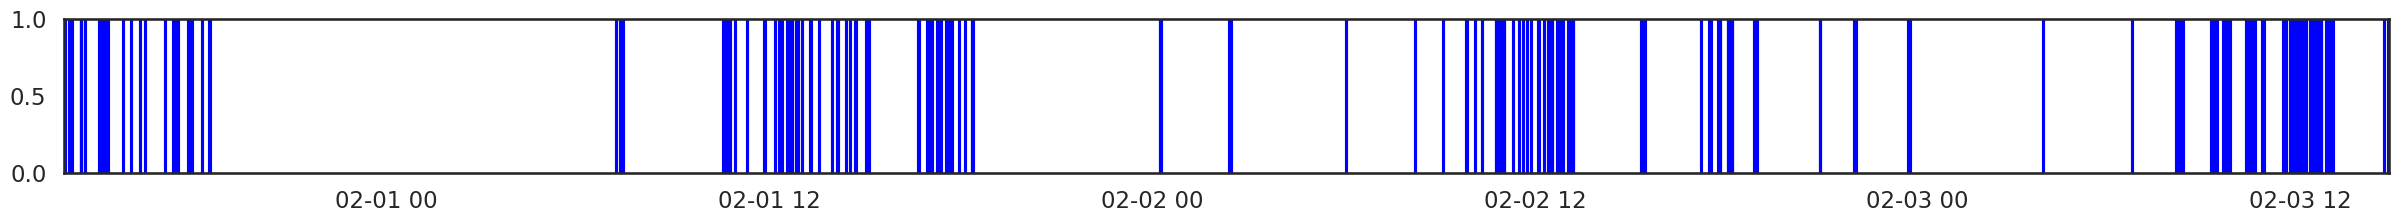

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(30, 2), sharex=True)
for visit in Visits.itertuples():
    axs.axvline(pd.Timestamp(visit.start), color = 'blue')
axs.set_xlim(Visits['start'][0], Visits['end'][233])
plt.show()

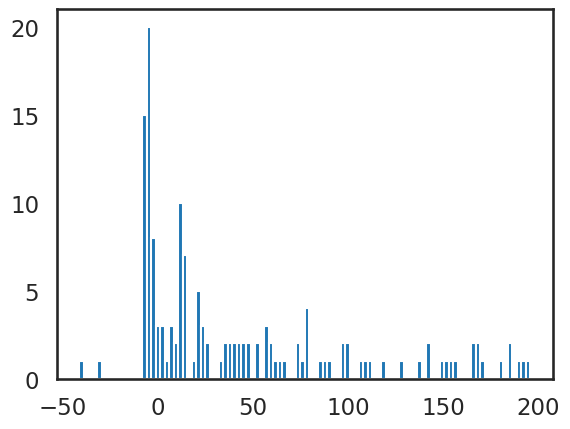

In [40]:
x = Visits['last_interval']
plt.hist(x[x<200], bins = 100)
#plt.xlim((0,10000))
plt.show()

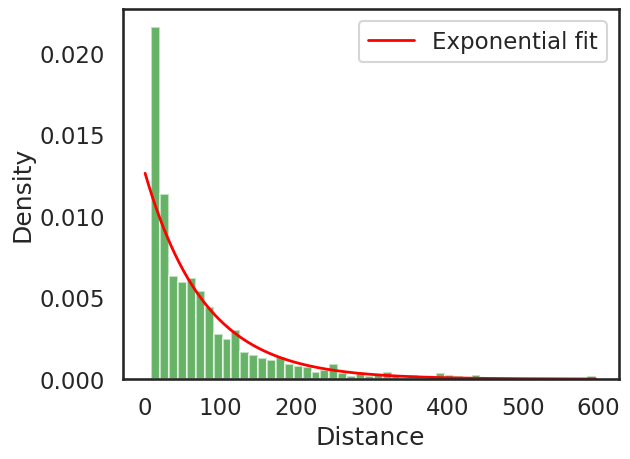

0.012631935322839776


In [62]:
Y = Visits['duration']

lambda_estimate = 1 / np.mean(Y)
plt.hist(Y, bins=50, density=True, alpha=0.6, color='g')

x = np.linspace(0, np.max(Y), 1000)
pdf = lambda_estimate * np.exp(-lambda_estimate * x)
plt.plot(x, pdf, 'r-', lw=2, label='Exponential fit')

plt.xlabel('Distance')
plt.ylabel('Density')
plt.legend()
plt.show()

print(lambda_estimate)

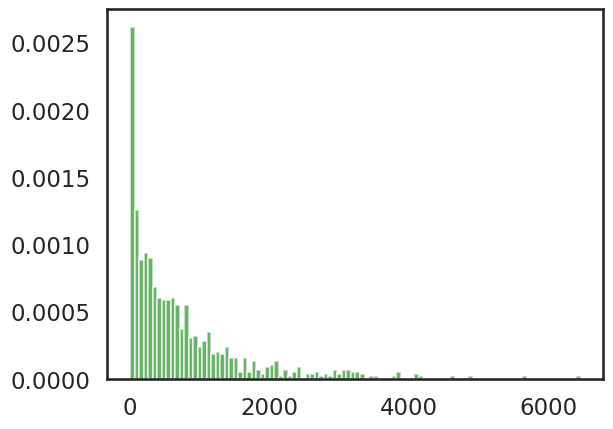

In [61]:
plt.hist(Y, bins=100, density=True, alpha=0.6, color='g')
plt.show()

In [3]:
FEATURES = ['last_pellets_self', 'last_pellets_other', 'interval', 'last_pellets_interval', 'entry']
MODELS = ['Gaussian']
PREDICTOR = ['duration']

X = Visits[FEATURES]
Y = Visits[PREDICTOR]

rate_para =  1 / np.mean(Y)
#Y_ = rate_para * np.exp(-rate_para * (Y))
Y_ = Y ** 0.5
#print(rate_para)
#display(Y_)

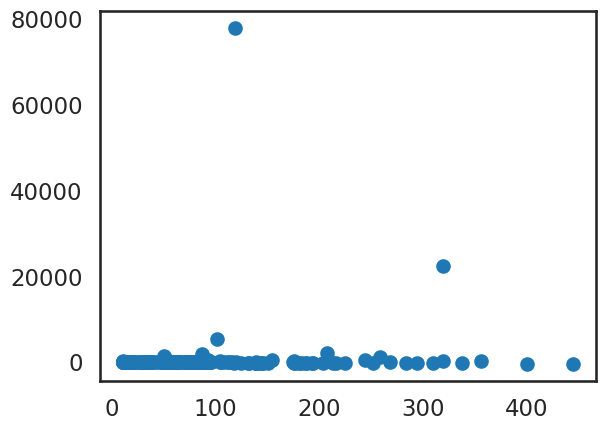

In [54]:
r = 1.2

def CrossValidation(X, Y, type = 'Gaussian', split_perc = 0.75):
    split_size = int(len(Y) * split_perc)
    indices = np.arange(len(Y))

    MSE_min = 1e20
    
    for i in range(1000):
        np.random.shuffle(indices)
        
        train_indices = indices[:split_size]
        test_indices = indices[split_size:]

        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        Y_train, Y_test = Y.iloc[train_indices], Y.iloc[test_indices]
        
        model = sm.GLM(Y_train, X_train, family=sm.families.Gaussian())
        result = model.fit()
        Y_test_pred = result.predict(X_test)
        
        '''Y_test_pred_true = 1/rate_para * np.log(rate_para) - (1/rate_para) * np.log(Y_test_pred)
        Y_test_true = 1/rate_para * np.log(rate_para) - (1/rate_para) * np.log(Y_test)'''
        
        mse = np.mean((Y_test_pred.to_numpy()  - Y_test.to_numpy() ) ** 2)
        
        if mse < MSE_min:  
            result_valid = result
            MSE_min = mse
        
    return result_valid, MSE_min
        
Y_ = np.log(Y)
result, mse = CrossValidation(X, Y_)
y_pred = result.predict(X)

y1 = Y_.to_numpy().reshape(1,-1)[0] 
y2 = y_pred.to_numpy().reshape(1,-1)[0]

y1 = np.exp(y1)
y2 = np.exp(y2)
plt.scatter(y1, y2-y1)
plt.ylim((-500, 500))
plt.show()

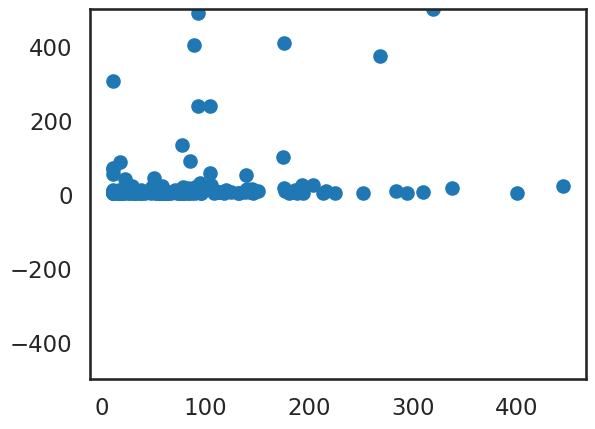

In [58]:
plt.scatter(y1, y2)
plt.ylim((-500, 500))
plt.show()

In [ ]:
np.array(X)[0]

KeyError: 0

In [155]:
for i in range(len(X)):
    print(np.any(np.isnan(np.array(X)[i])))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [66]:
N = np.arange(5,20,1)
FEATURES = ['speed', 'acceleration', 'last_pellets_self', 'last_pellets_other', 'interval', 'last_duration', 'last_pellets_interval', 'entry']
X = Visits[FEATURES]
obs = np.array(X)


loglikelihood = []
for n in N:
    hmm, states, transition_mat, lls = HMM.FitHMM(obs, num_states = n, n_iters = 50)
    ll = hmm.log_likelihood(obs)
    loglikelihood.append(ll/len(obs[0]))


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

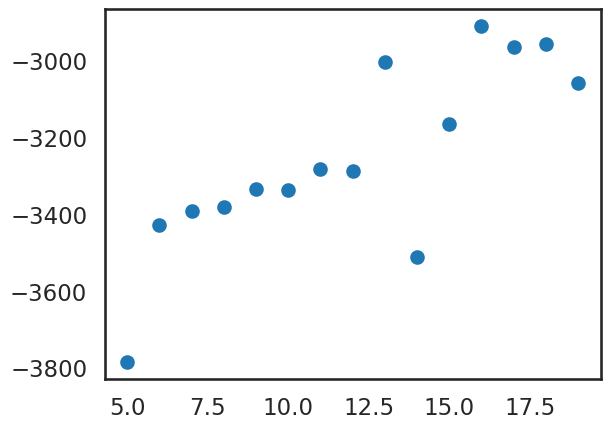

In [68]:
plt.scatter(N, loglikelihood)
plt.show()

In [116]:
FEATURES = ['speed', 'acceleration', 'last_pellets_self', 'last_pellets_other', 'interval', 'last_duration', 'last_pellets_interval', 'entry']
X = Visits[FEATURES]
obs = np.array(X)
hmm, states, transition_mat, lls = HMM.FitHMM(obs, num_states = 16, n_iters = 50)

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

In [121]:
para_index

6

In [128]:
FEATURES = ['speed', 'acceleration', 'last_pellets_self', 'last_pellets_other', 'interval', 'last_duration', 'last_pellets_interval', 'entry']
X = Visits[FEATURES]
obs = np.array(X)
obs_ = Y.to_numpy().reshape(1,-1)[0]

Y = Visits['pellet']

para_index = 0
num_index = 0
max_corr = -1
for k in range(3,30):
    hmm, states, transition_mat, lls = HMM.FitHMM(obs, num_states = k, n_iters = 50)
    for j in range(len(hmm.observations.params[0].T)):
        state_mean_speed = hmm.observations.params[0].T[j]
        index = np.argsort(state_mean_speed, -1) 
        new_values = np.empty_like(states)
        for i, val in enumerate(index): new_values[states == val] = i
        states_ = new_values
        
        corr = np.corrcoef(obs_, states_)[0,1]
        if abs(corr) > max_corr:
            para_index = j
            num_index = k
            max_corr = abs(corr)
    
print(para_index,num_index, max_corr)

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

2 29 0.12762419764763144


In [129]:
obs = np.array(X)
hmm, states, transition_mat, lls = HMM.FitHMM(obs, num_states = 29, n_iters = 5)

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

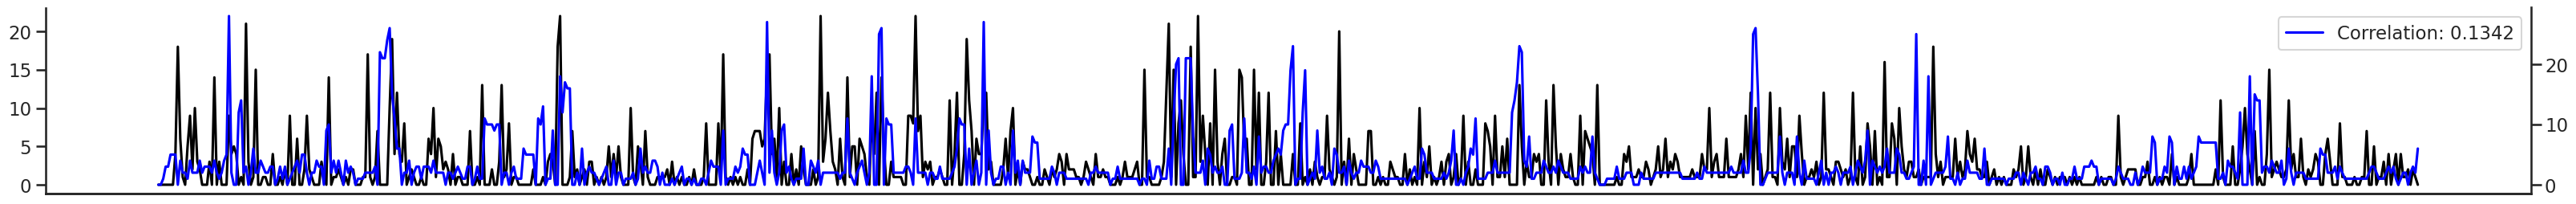

In [132]:
state_mean_speed = hmm.observations.params[0].T[6]
index = np.argsort(state_mean_speed, -1) 
new_values = np.empty_like(states)
for i, val in enumerate(index): new_values[states == val] = i
states_ = new_values

Y = Visits['pellet']
t = np.arange(0,len(states),1)

obs_ = Y.to_numpy().reshape(1,-1)[0]
pred = states_

fig, axs = plt.subplots(1, 1, figsize=(40, 3), sharex=True)
axs.plot(t, obs_, color = 'black')
axs.set_xticks([]) 
axs.set_facecolor('white') 
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

axs_ = axs.twinx()
axs_.plot(t, pred, color = 'blue', label = 'Correlation: '+str(round(np.corrcoef(obs_, pred)[0,1],4)))
axs_.set_xticks([]) 
axs_.set_facecolor('white') 
axs_.spines['top'].set_visible(False)
axs_.spines['left'].set_visible(False)
axs_.legend()

#axs_.set_ylim(axs.get_ylim())
plt.show()

In [144]:
k = np.argsort(Pred[10])
k

array([14, 26, 24, 23, 22, 21, 20, 19, 17, 16, 27, 13, 28, 10,  9,  8,  7,
        5,  4,  3,  2,  1, 12, 15,  0, 11, 18,  6, 25])

In [146]:
Pred[10][25]

0.3333333333333333

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

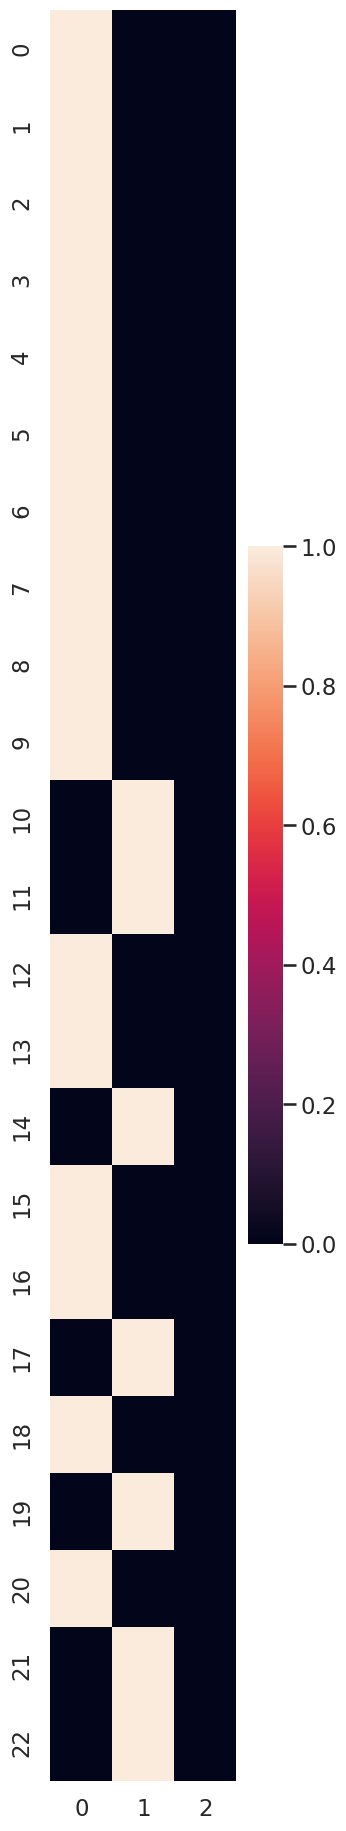

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

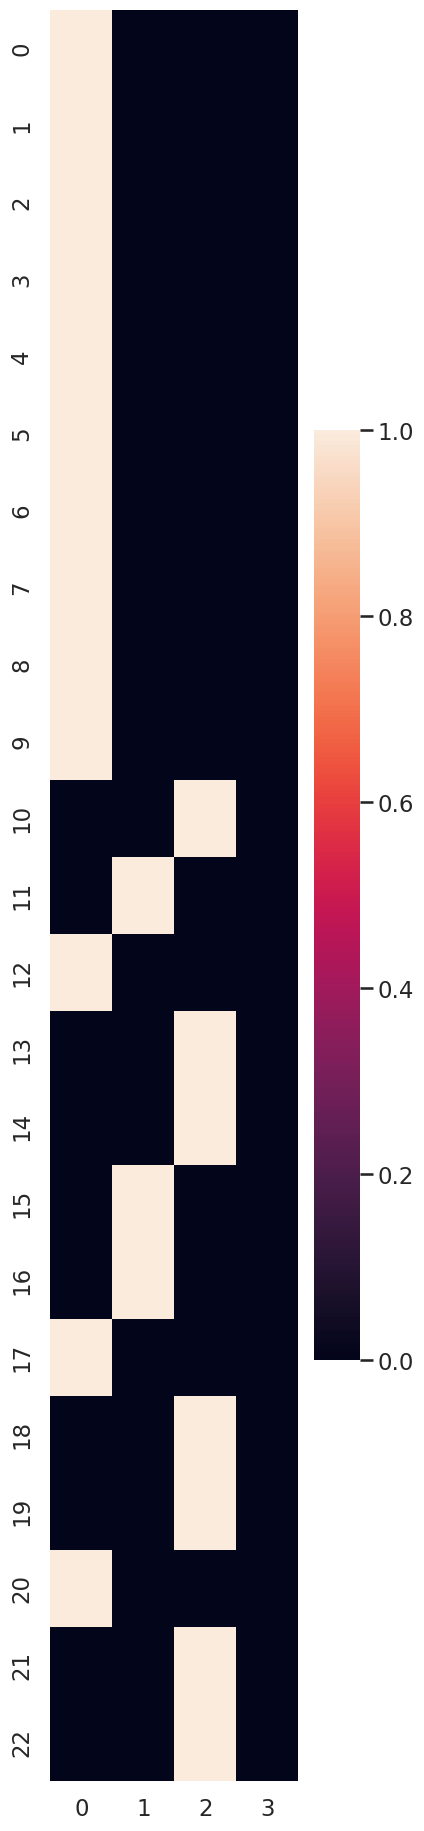

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

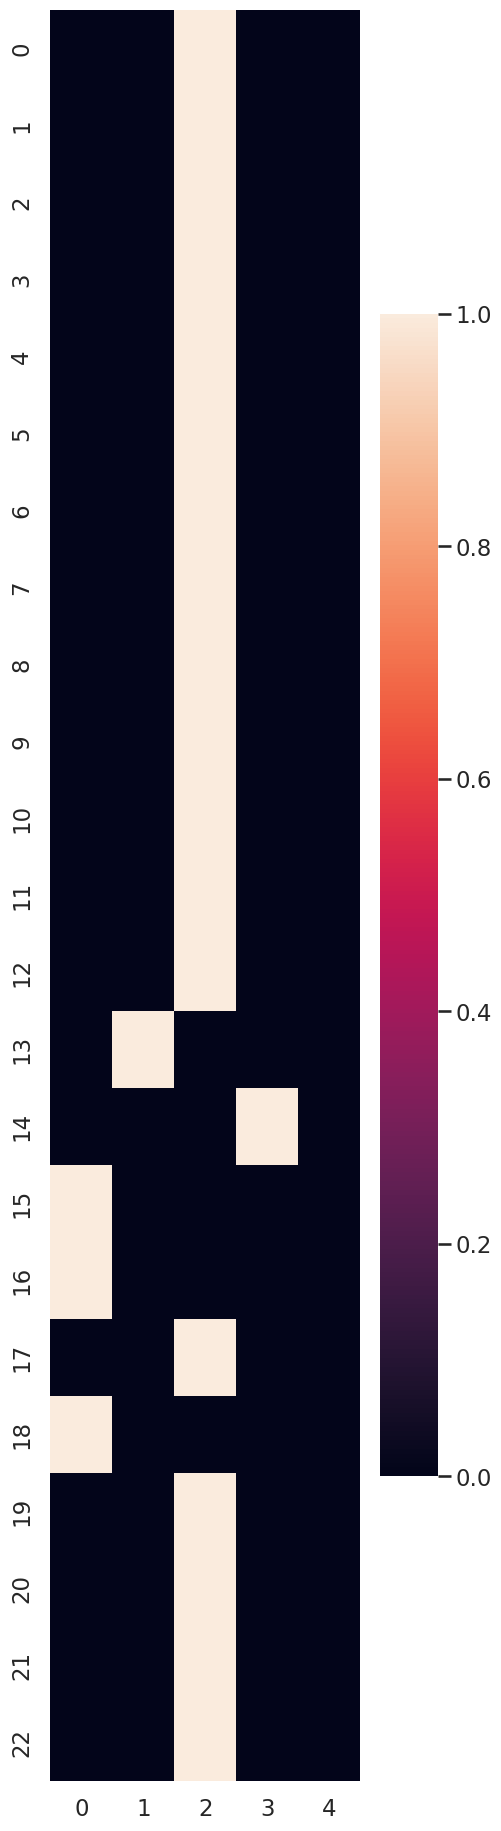

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

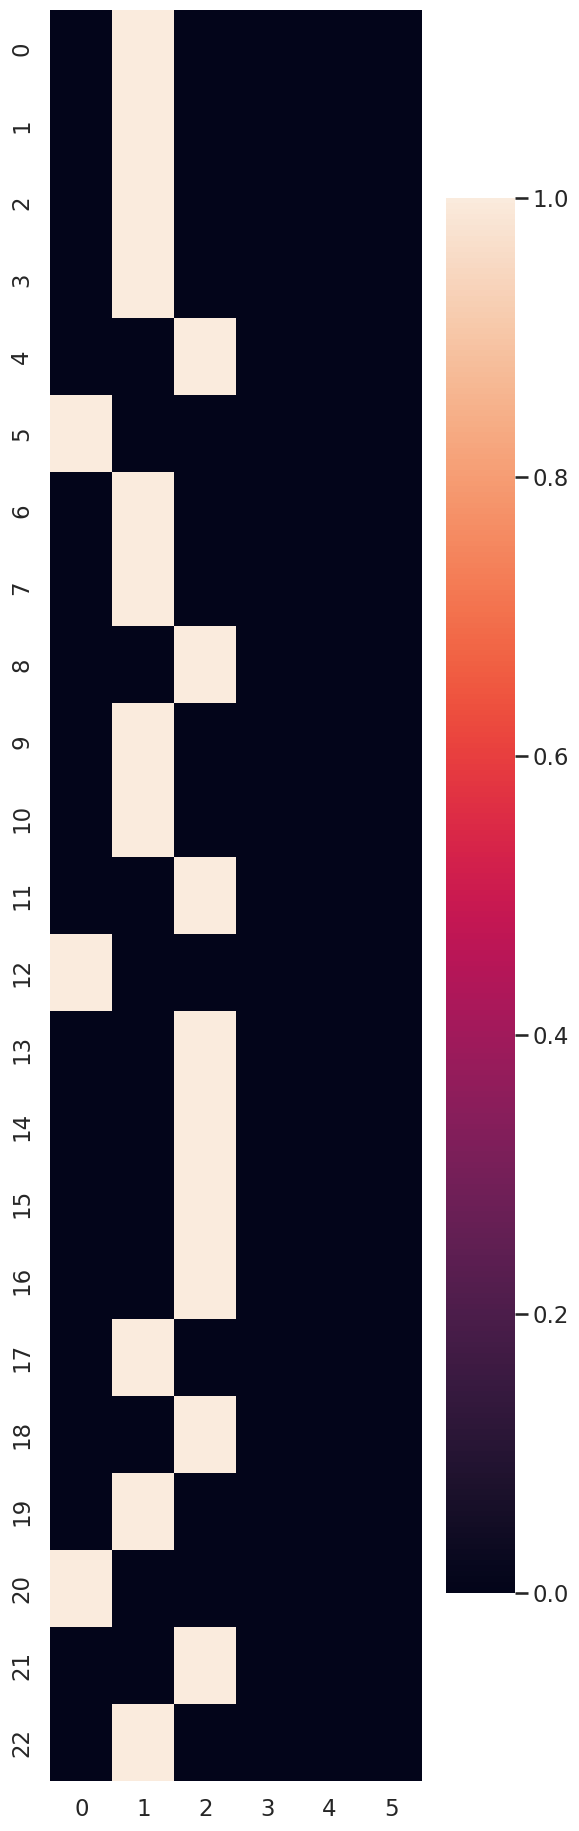

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

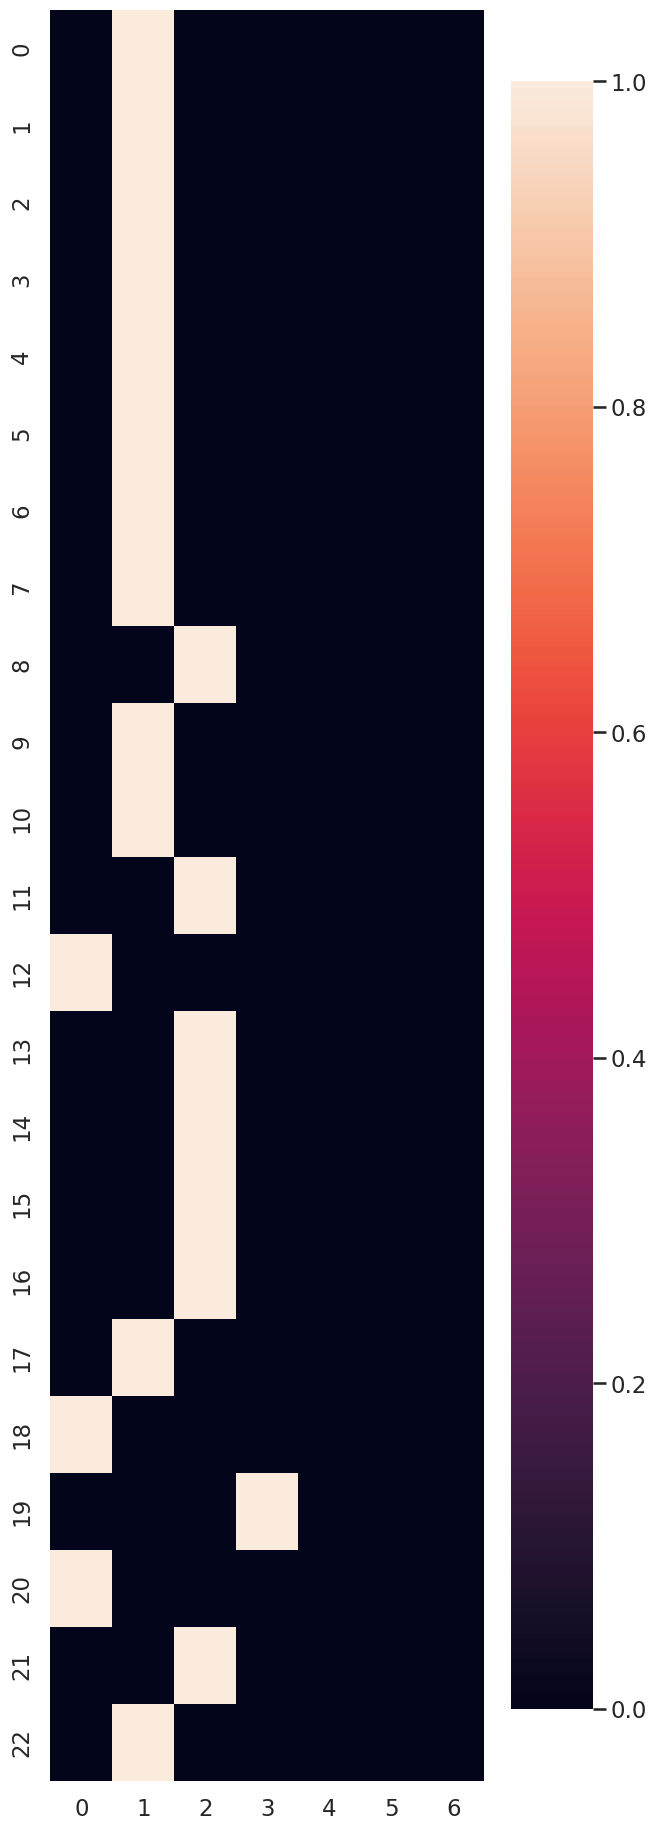

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

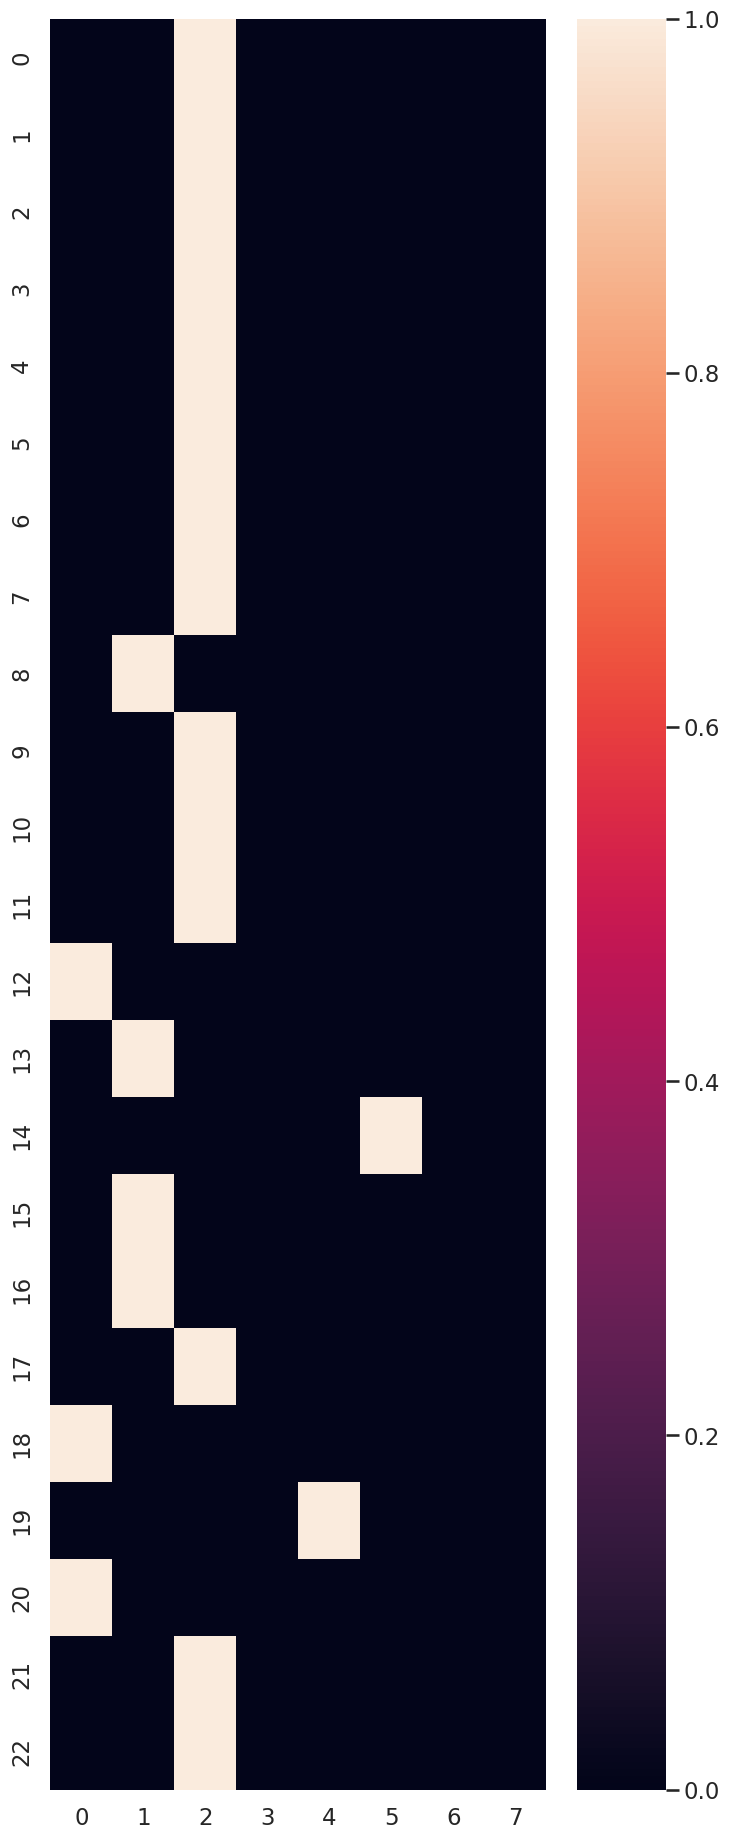

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

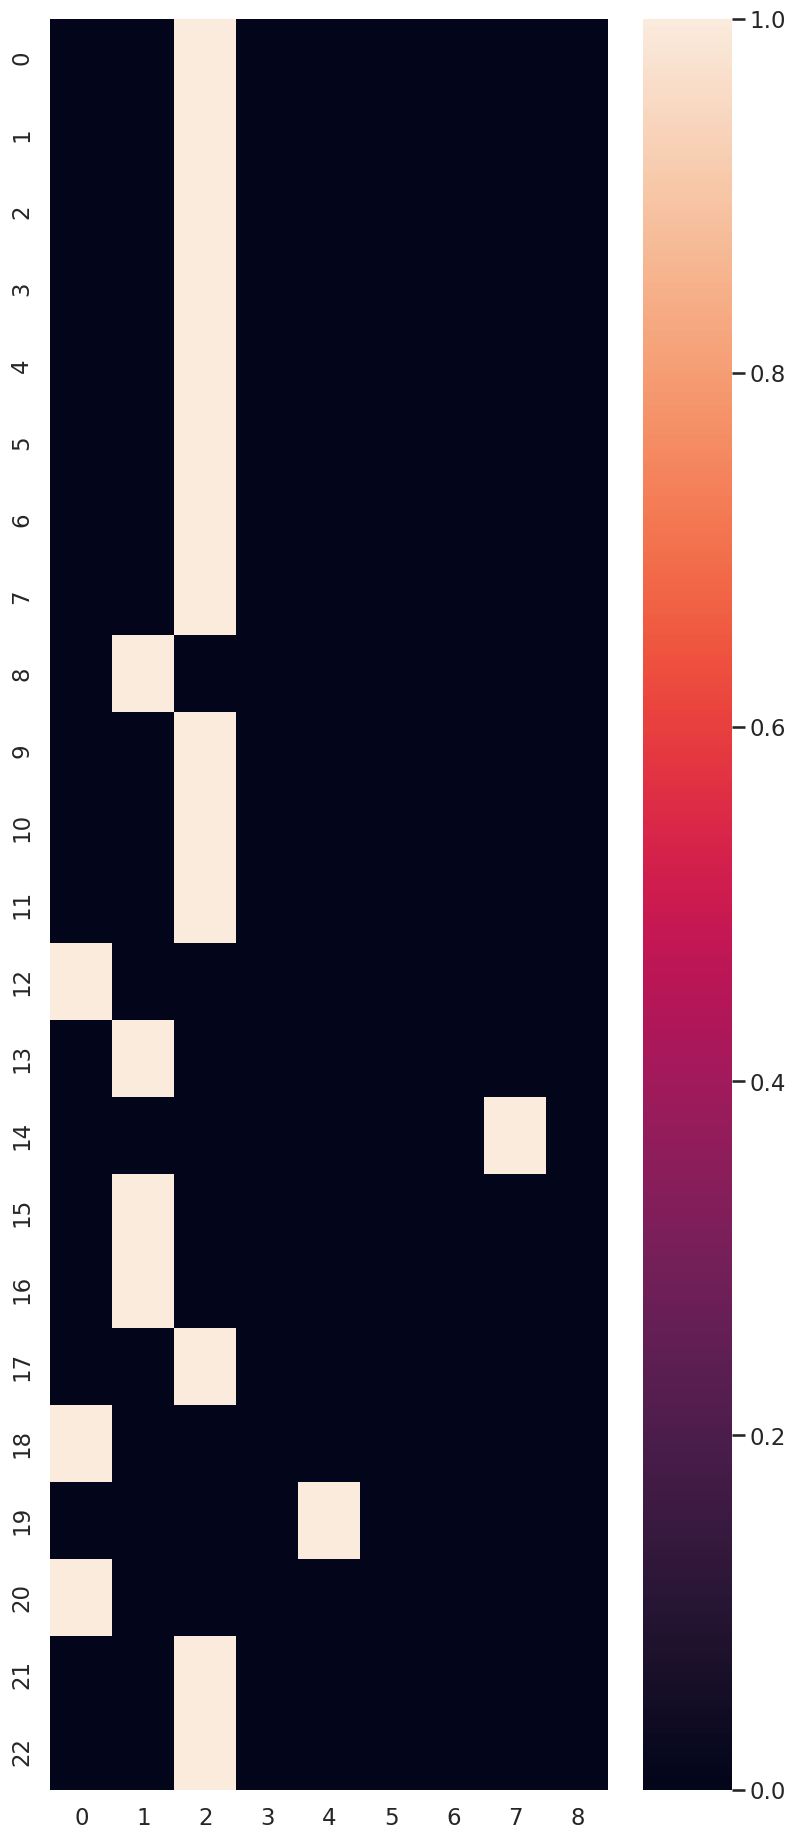

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

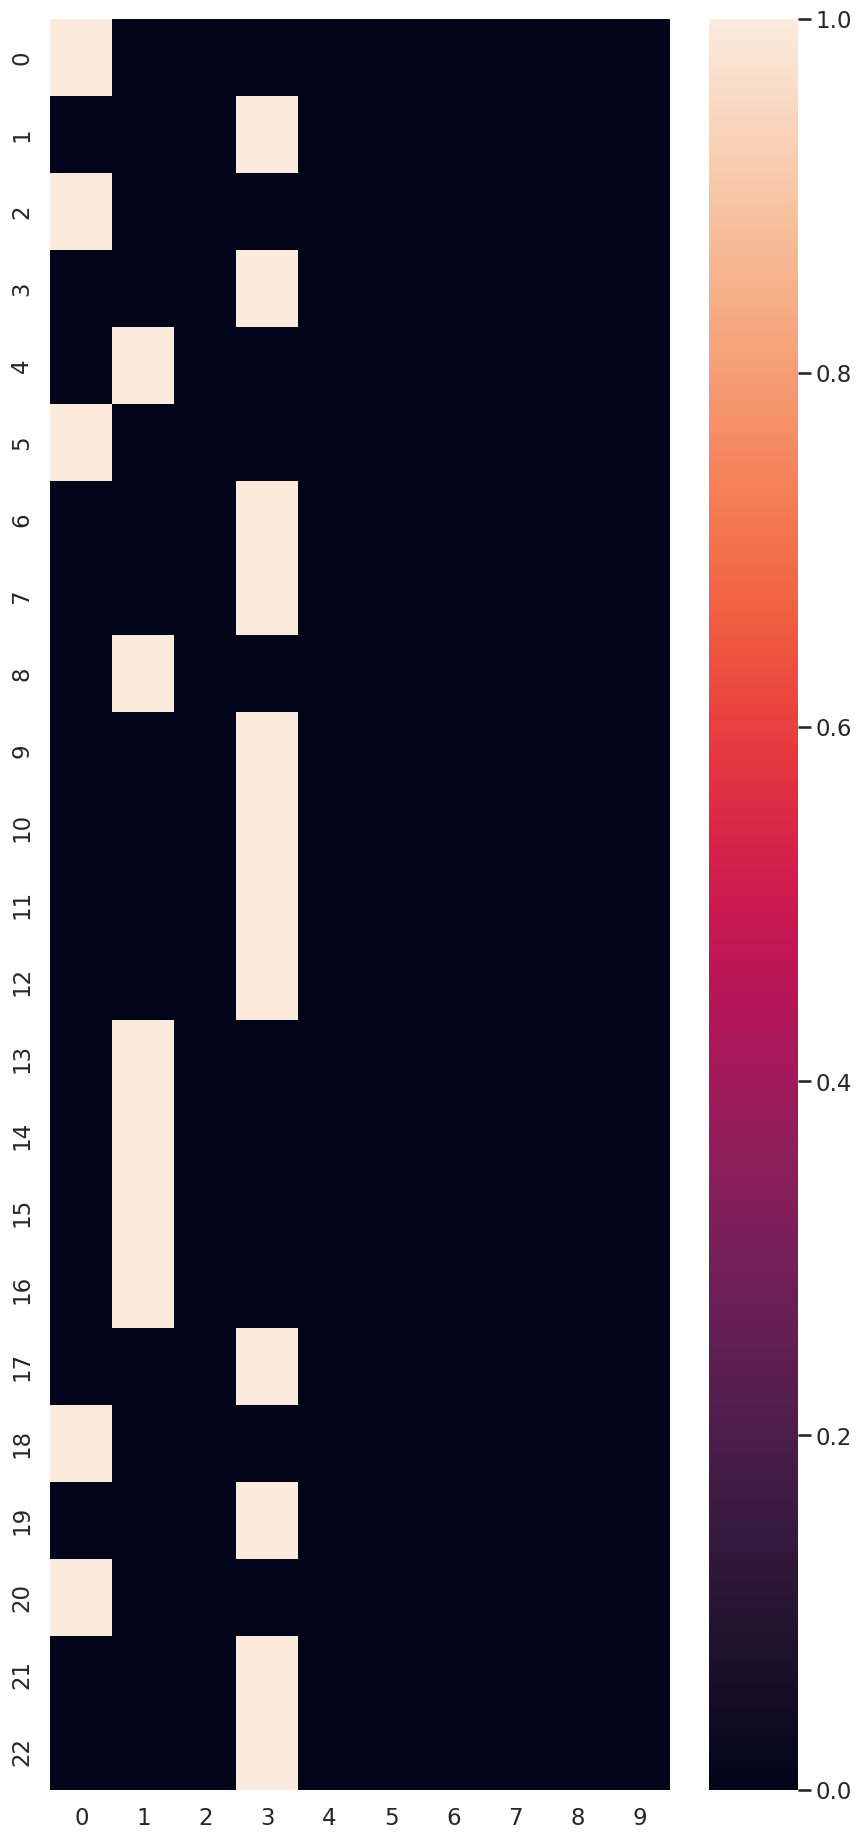

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

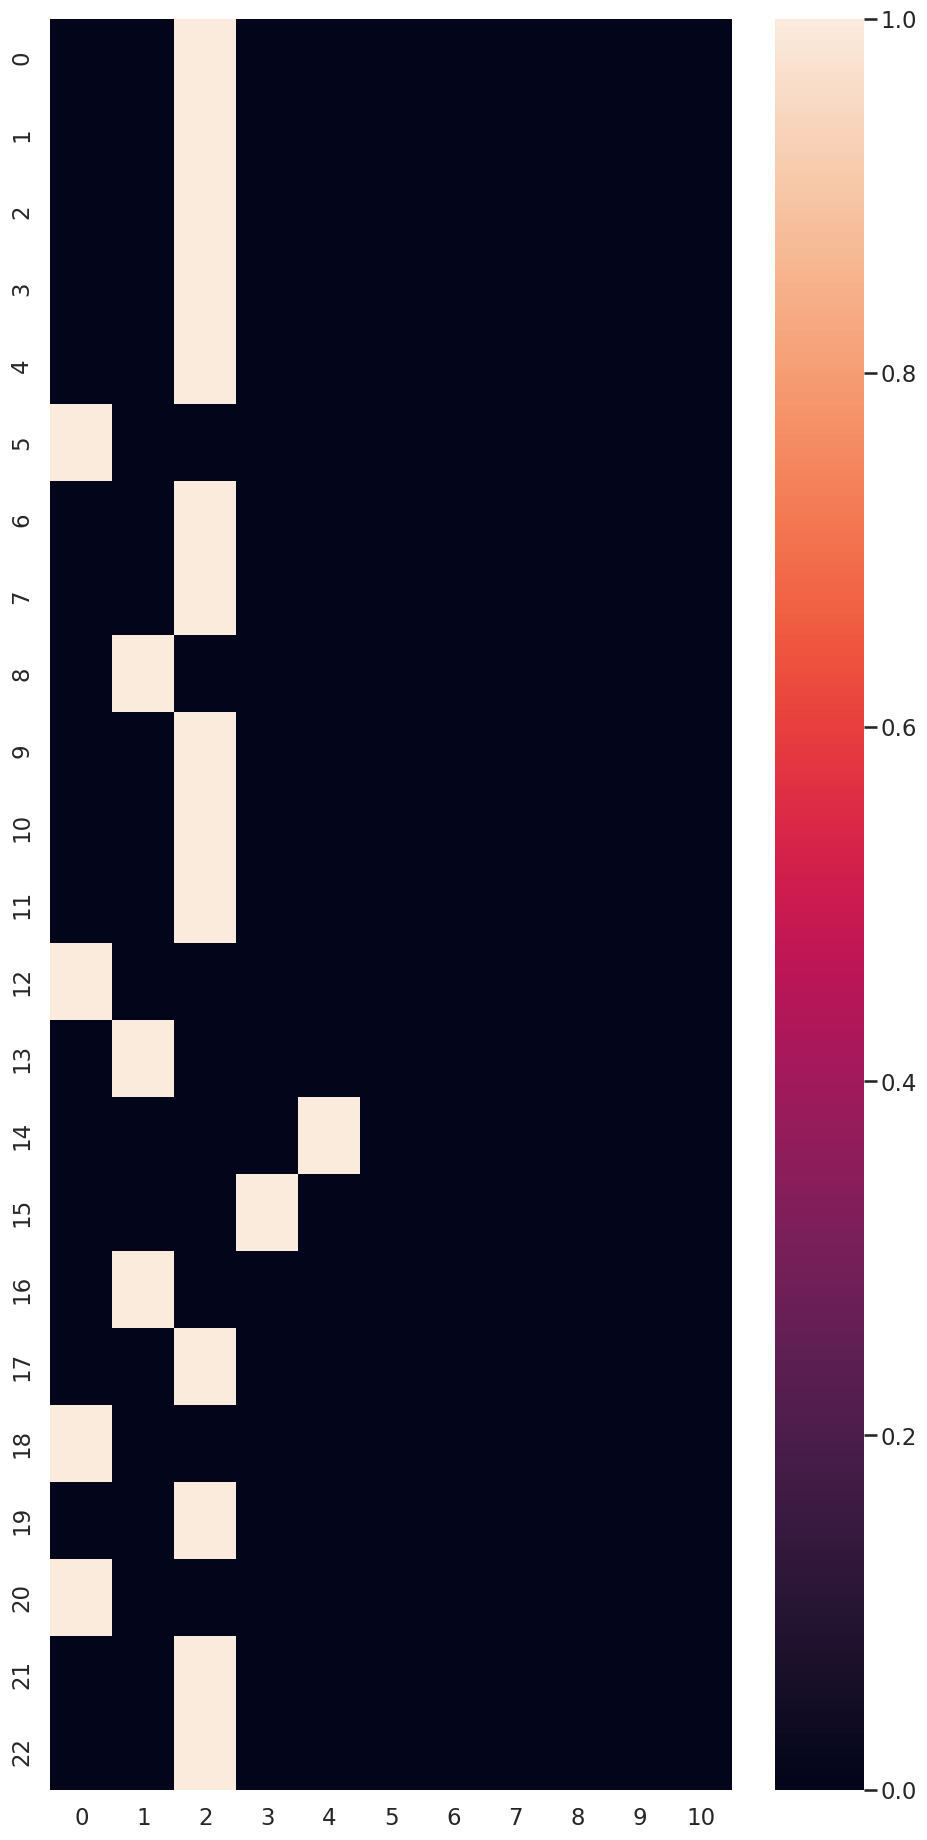

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

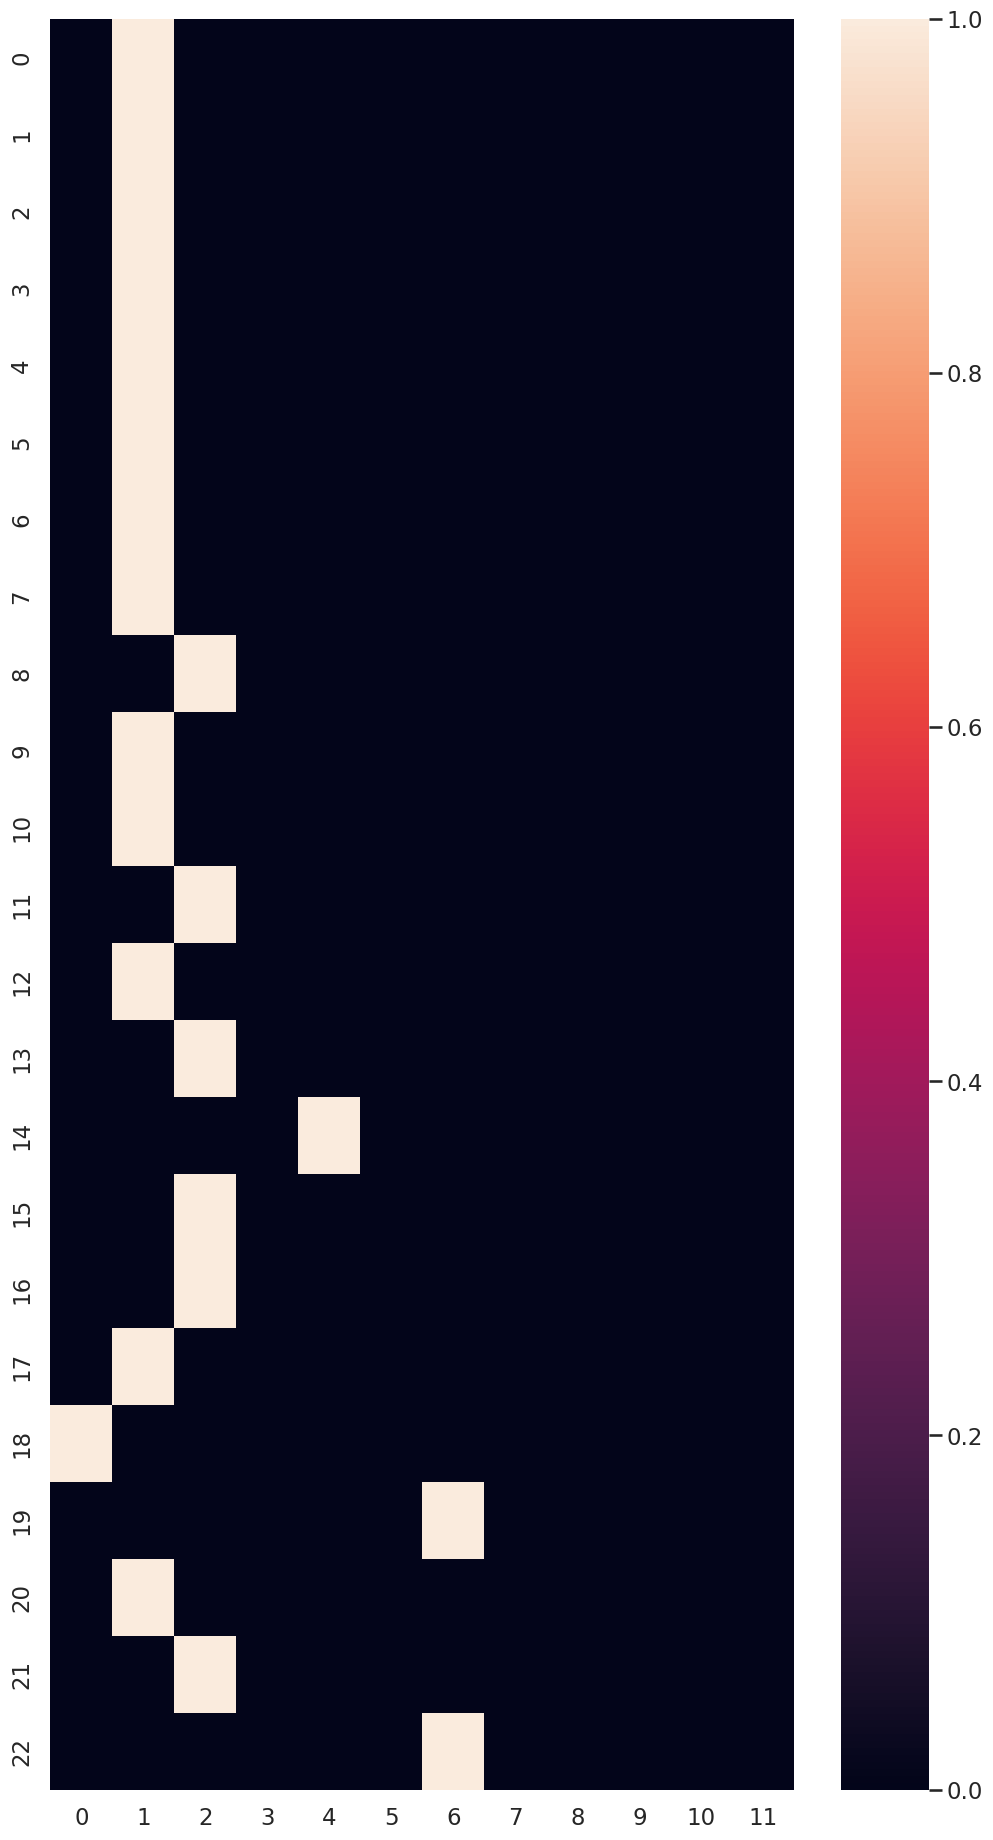

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

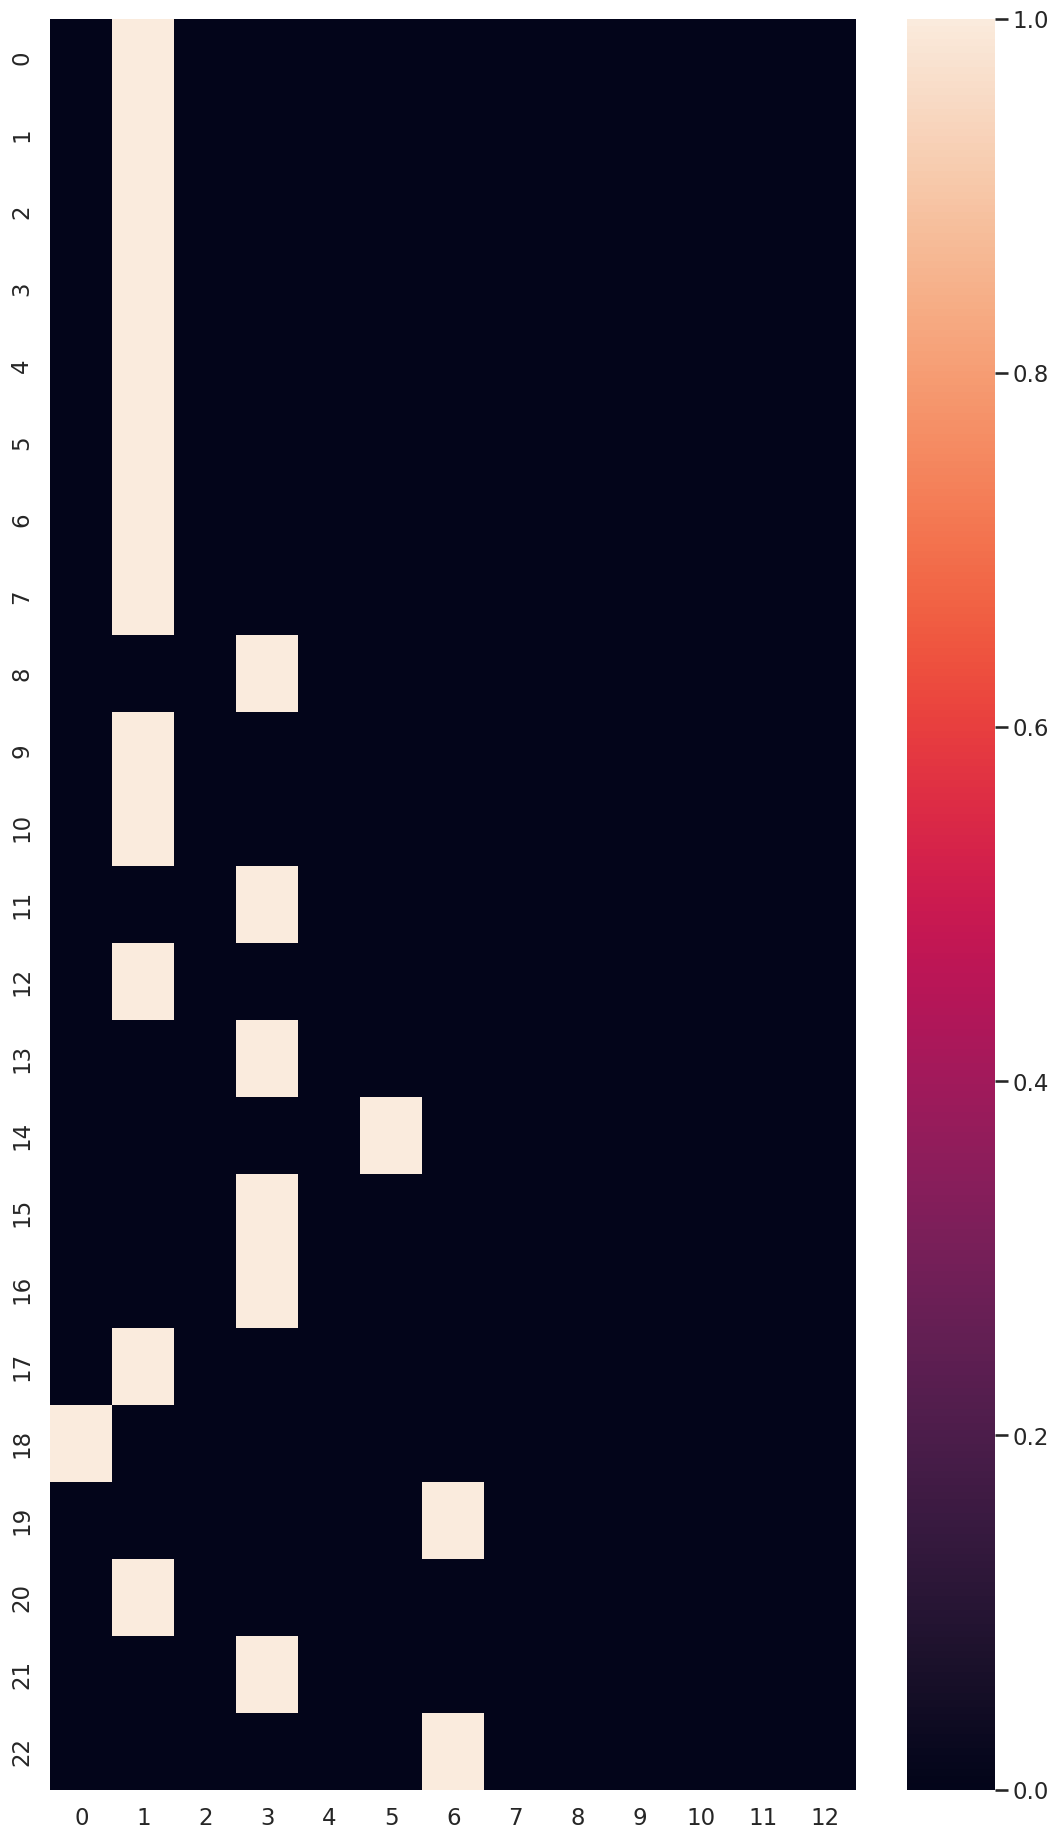

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

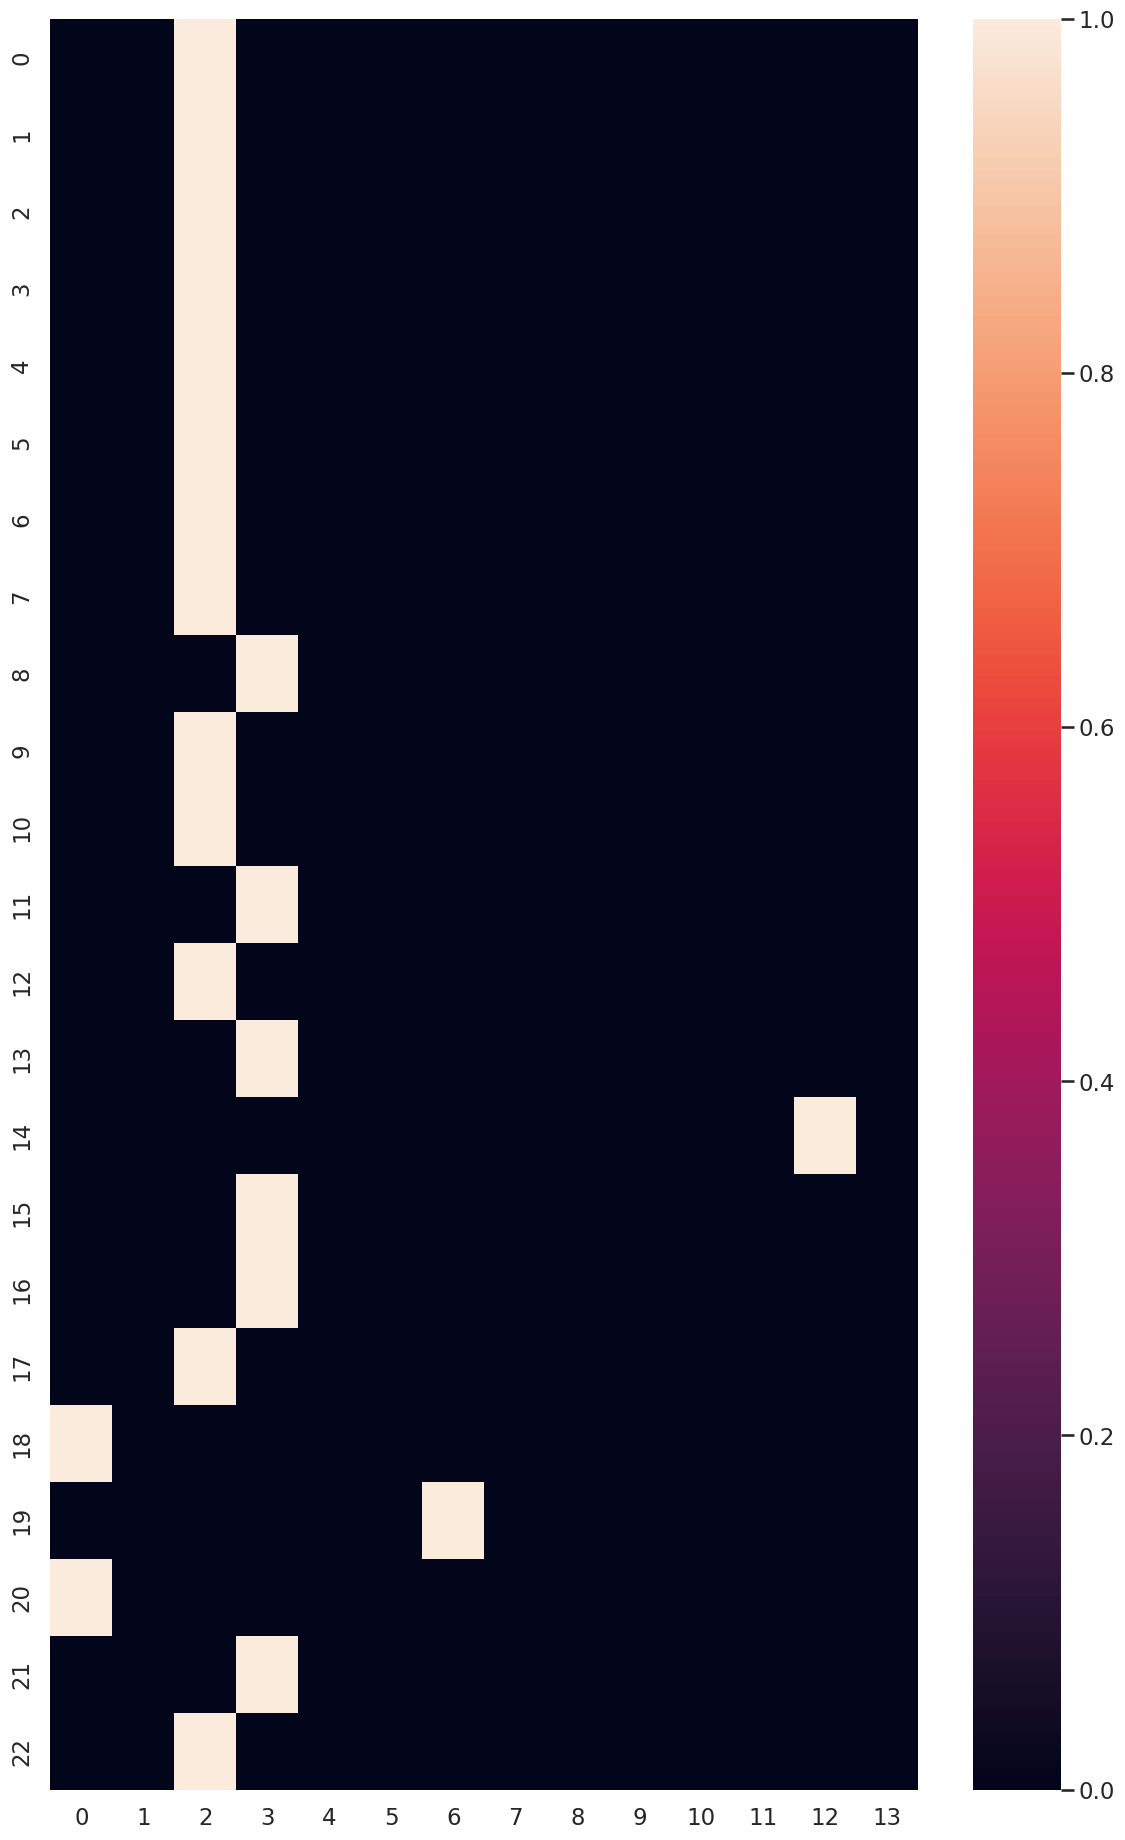

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

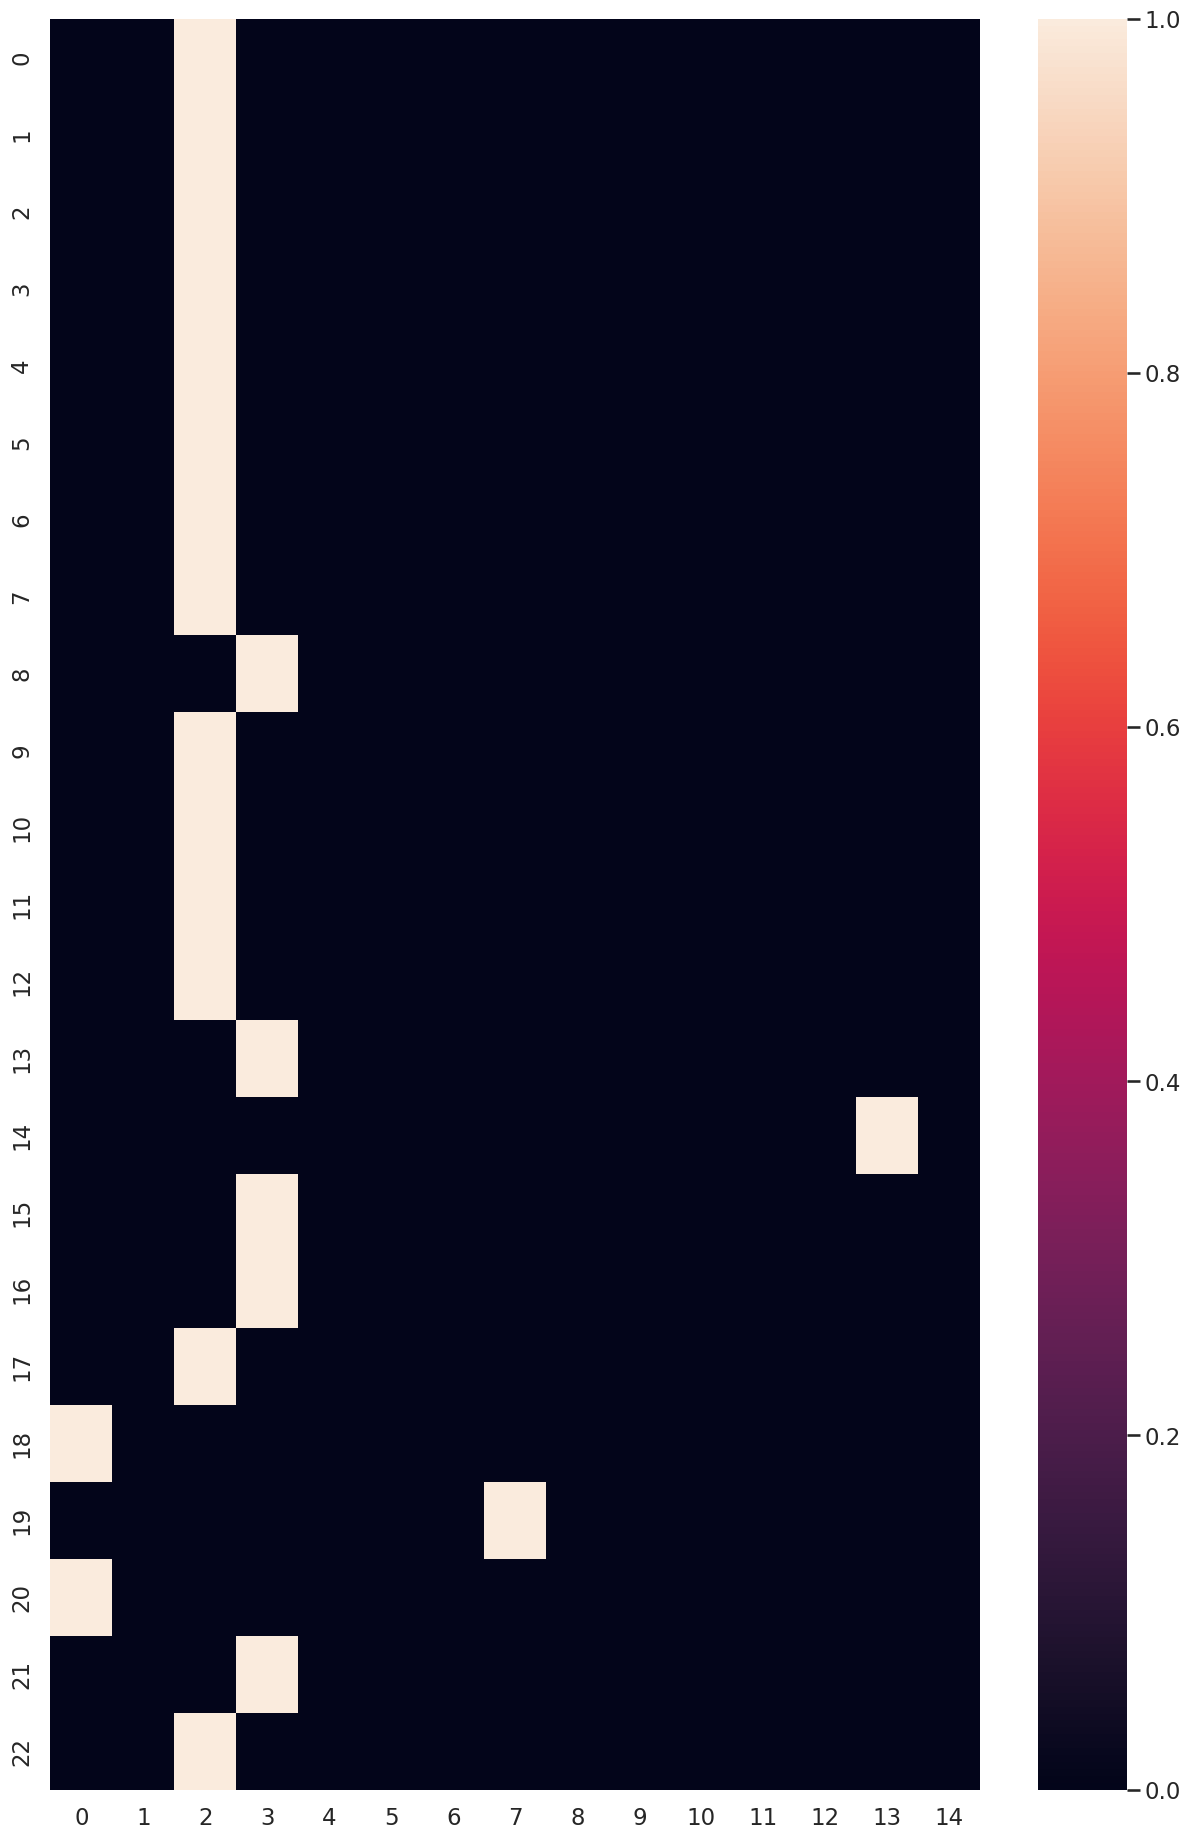

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

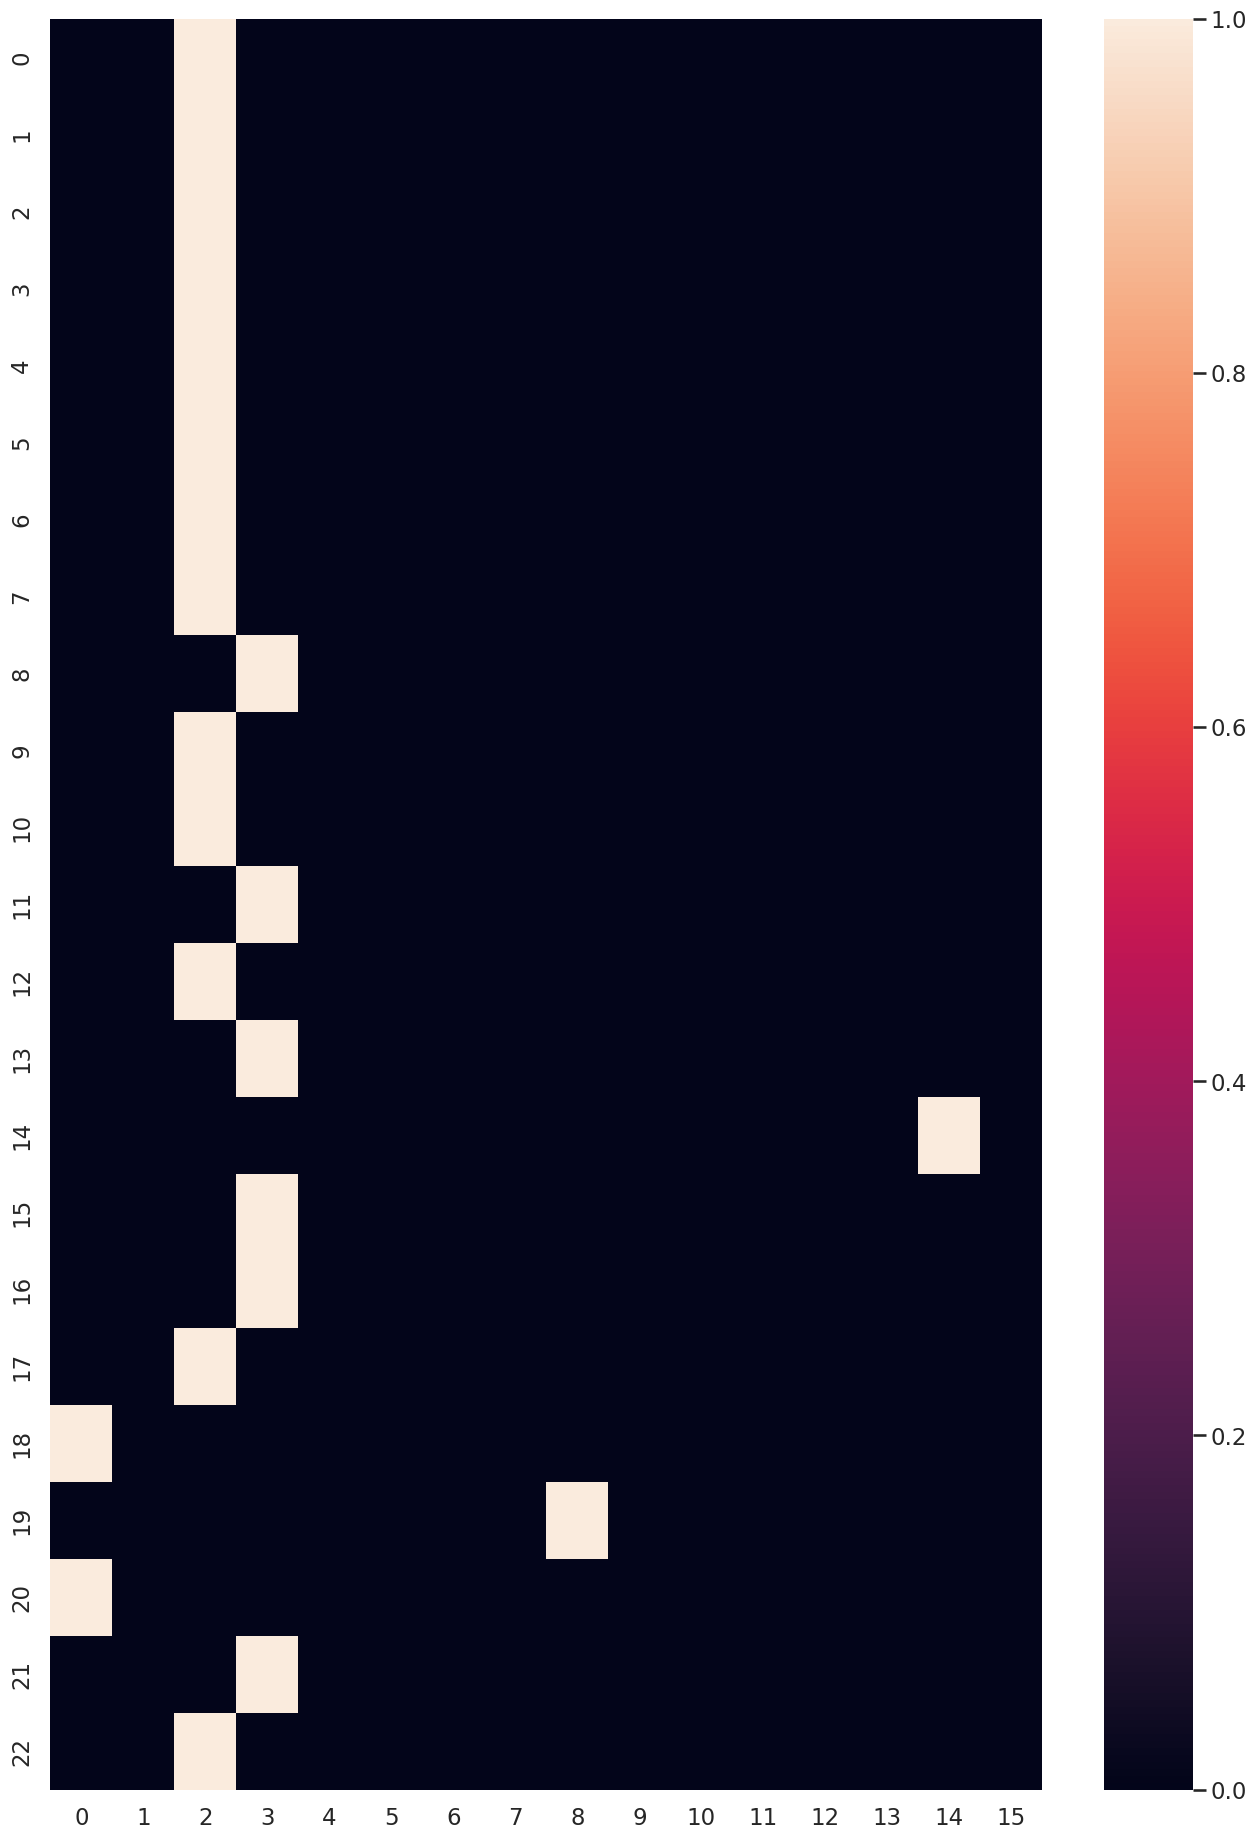

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

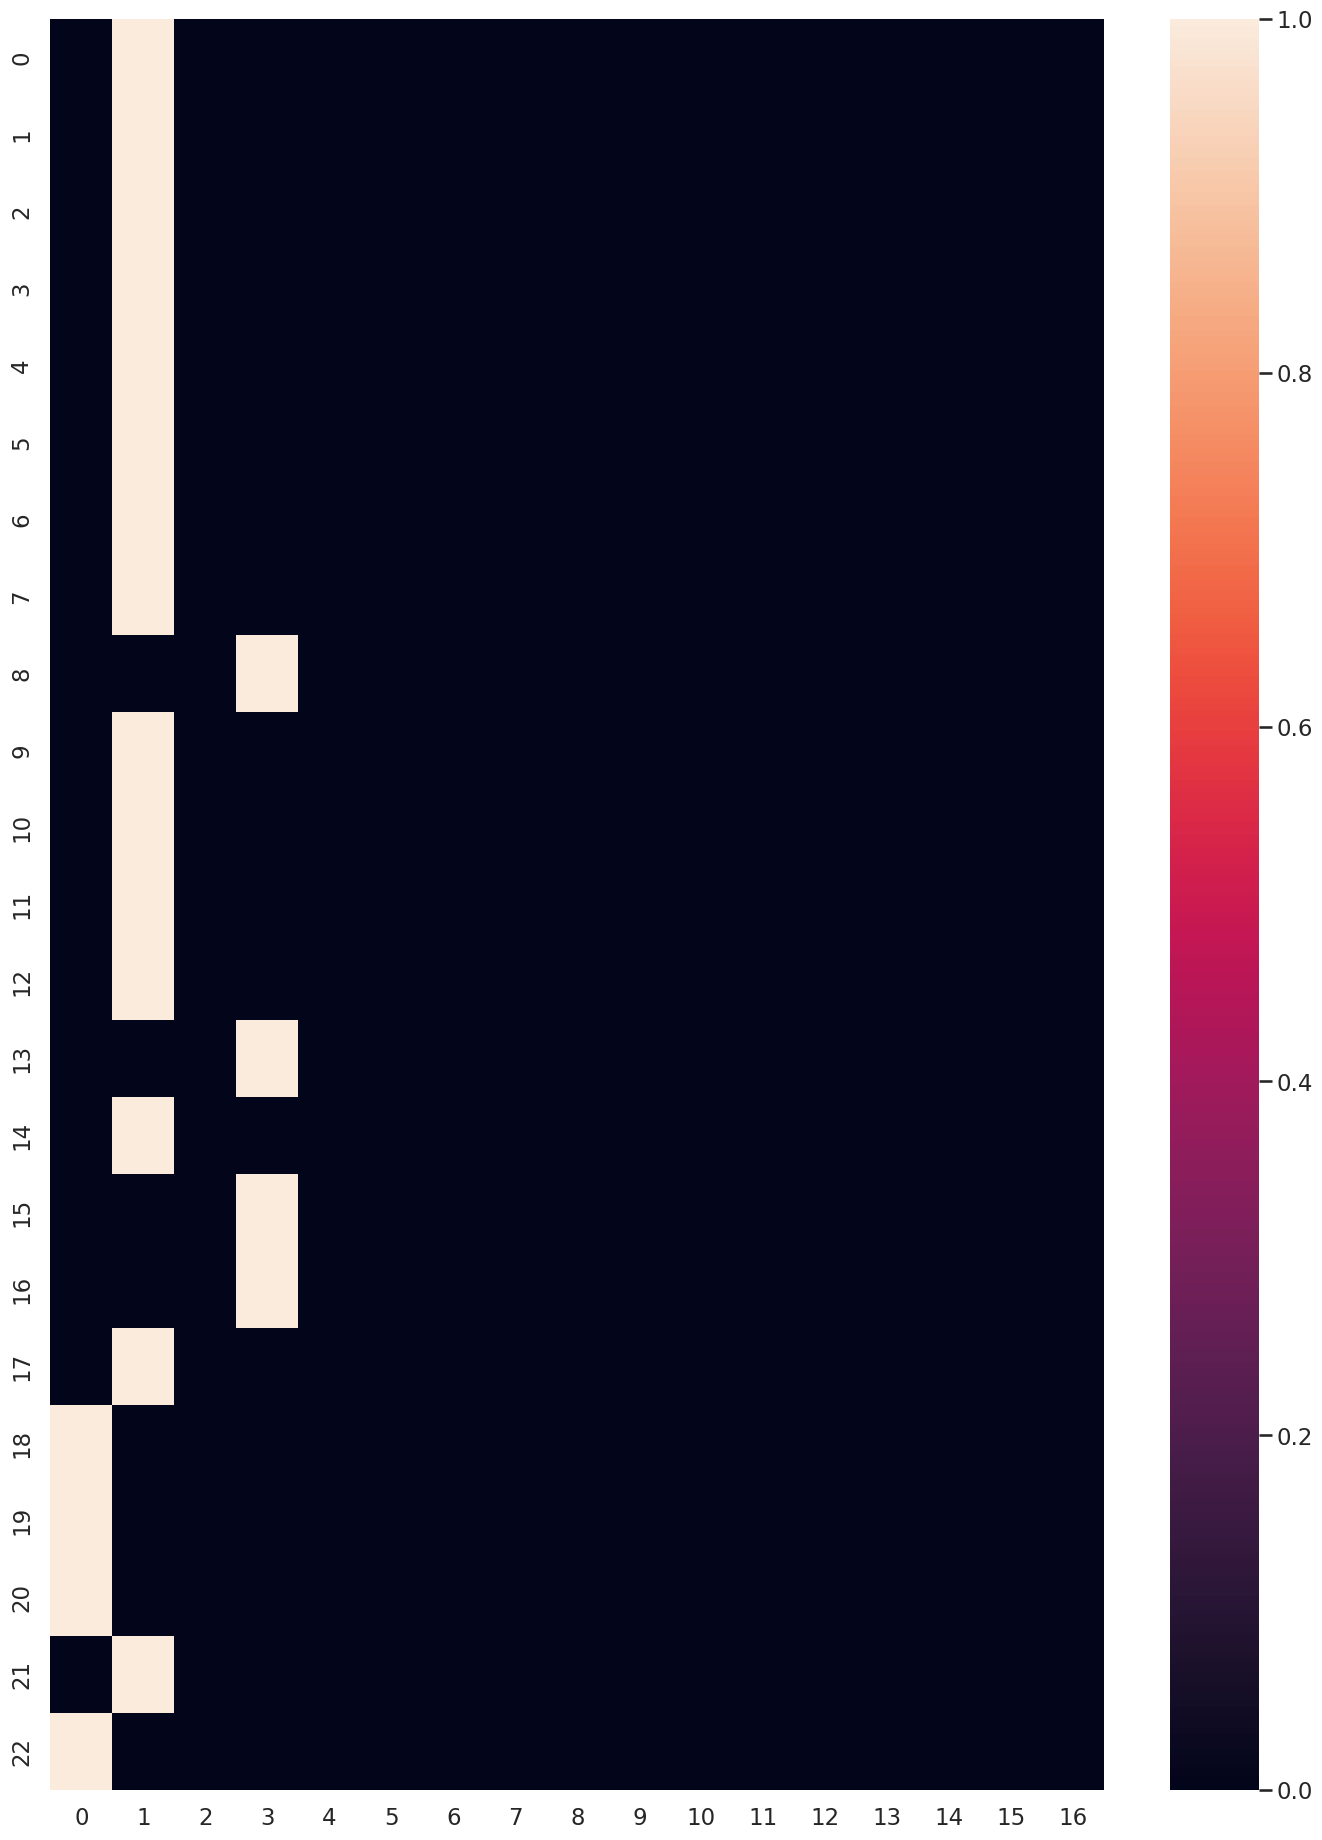

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

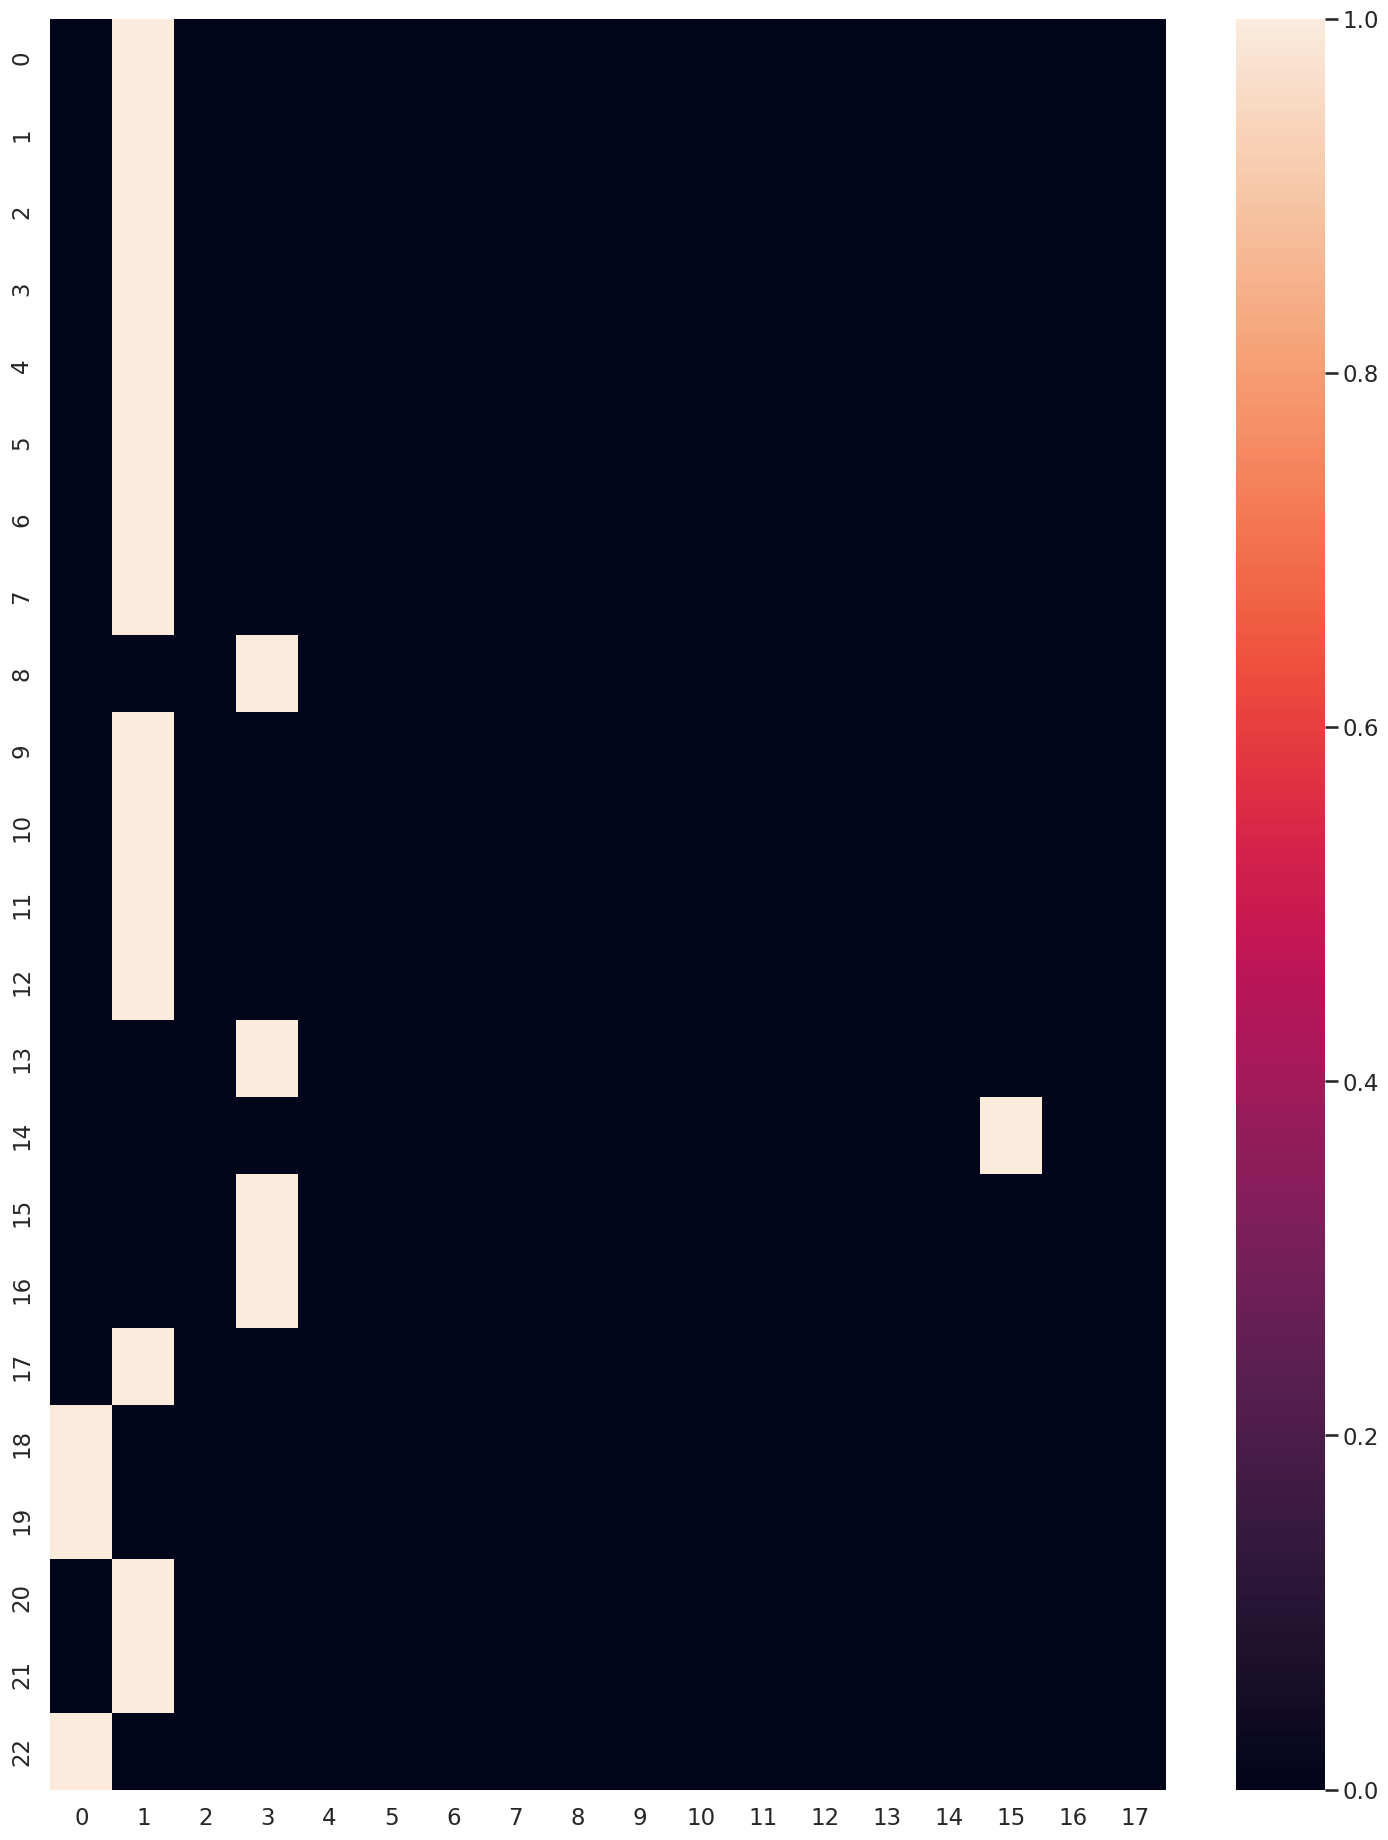

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

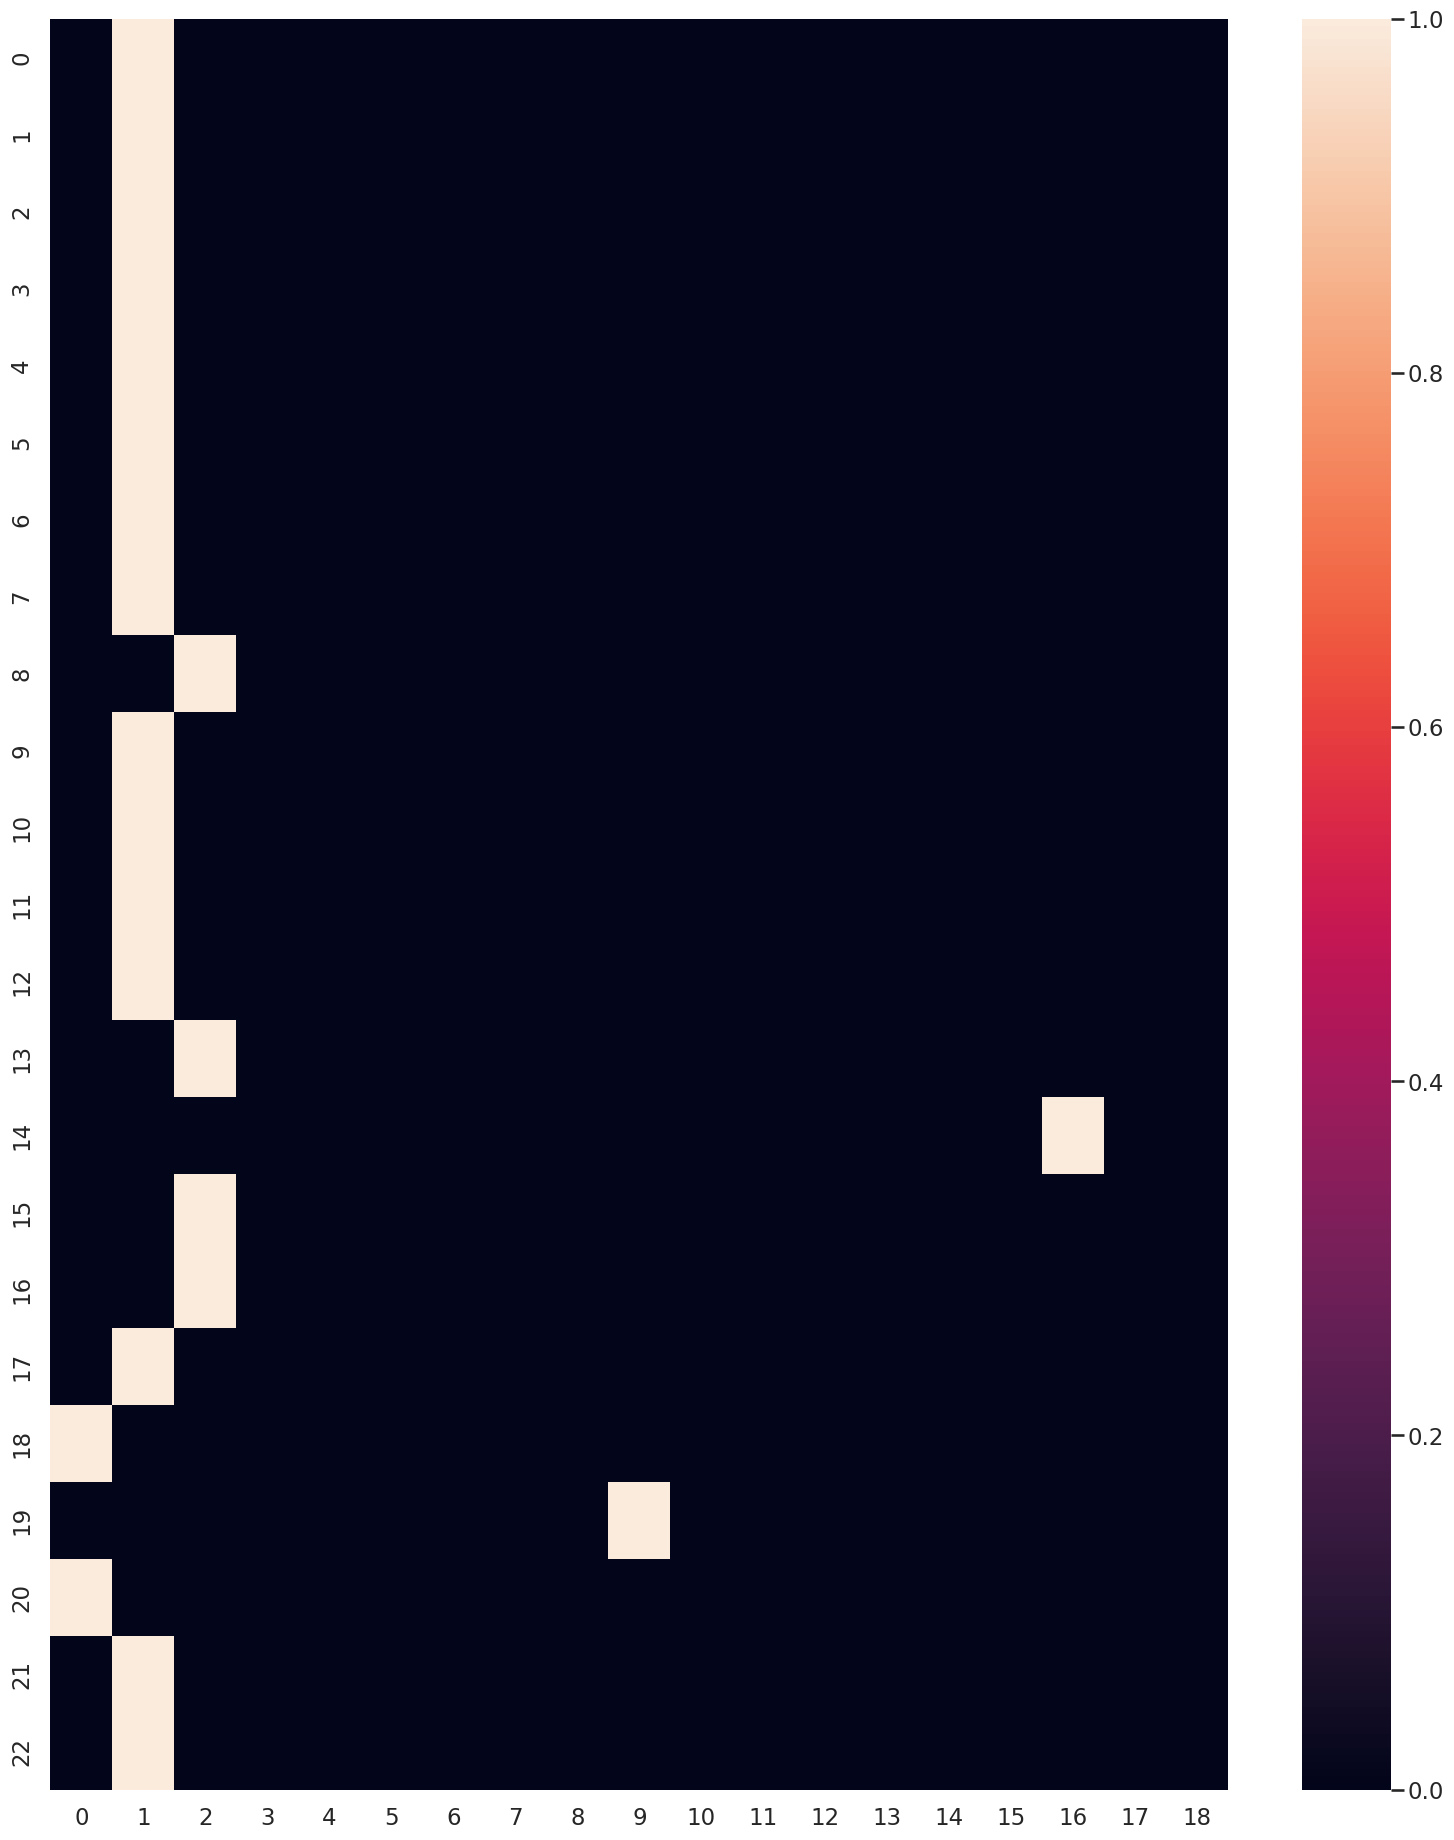

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

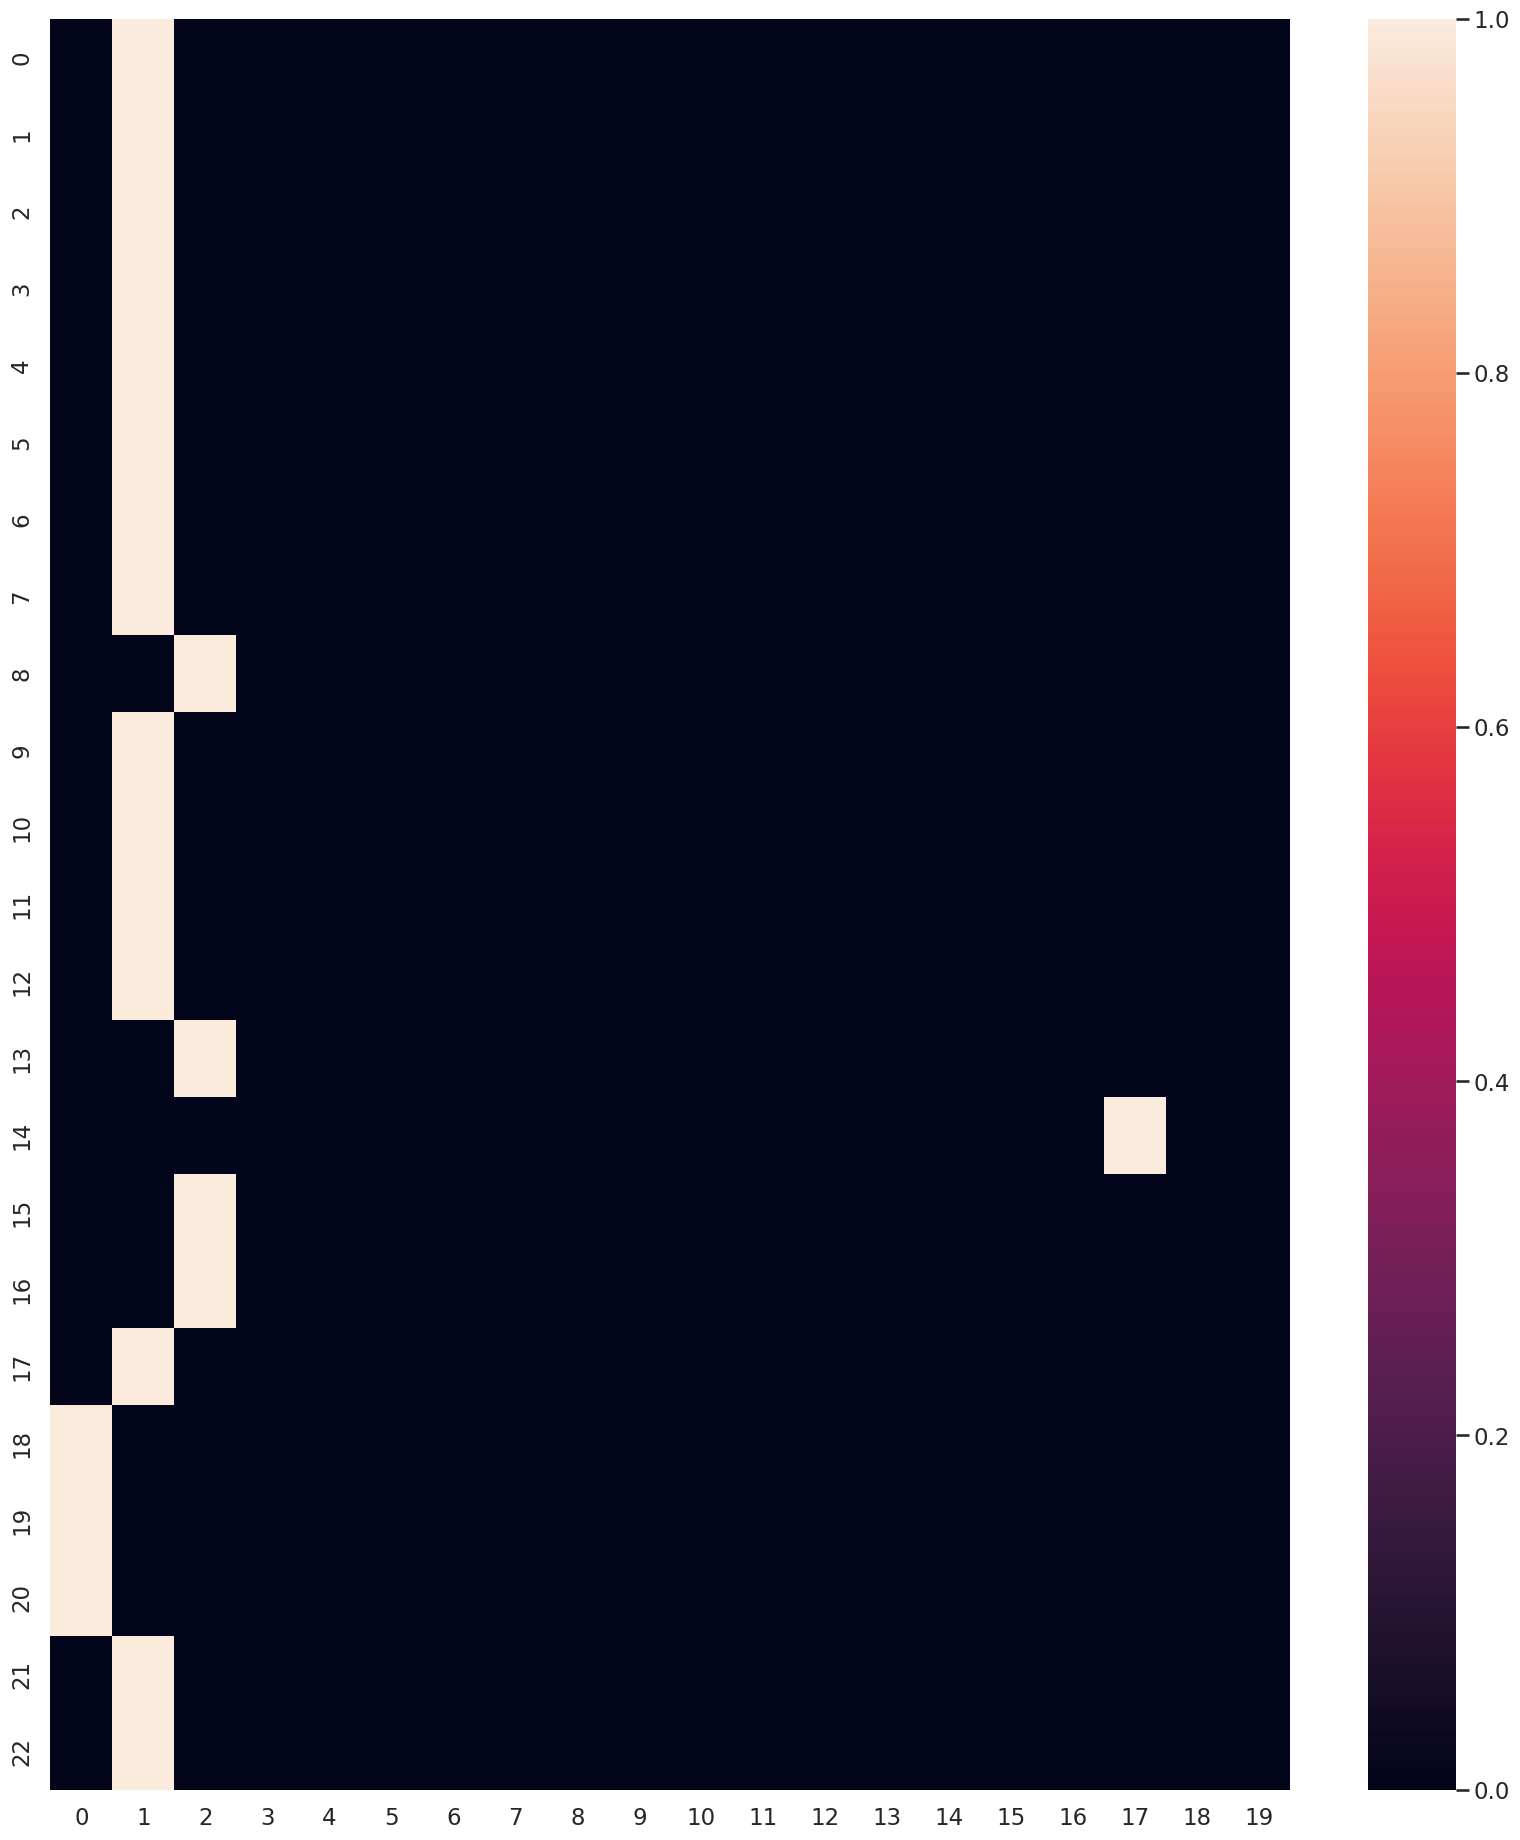

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

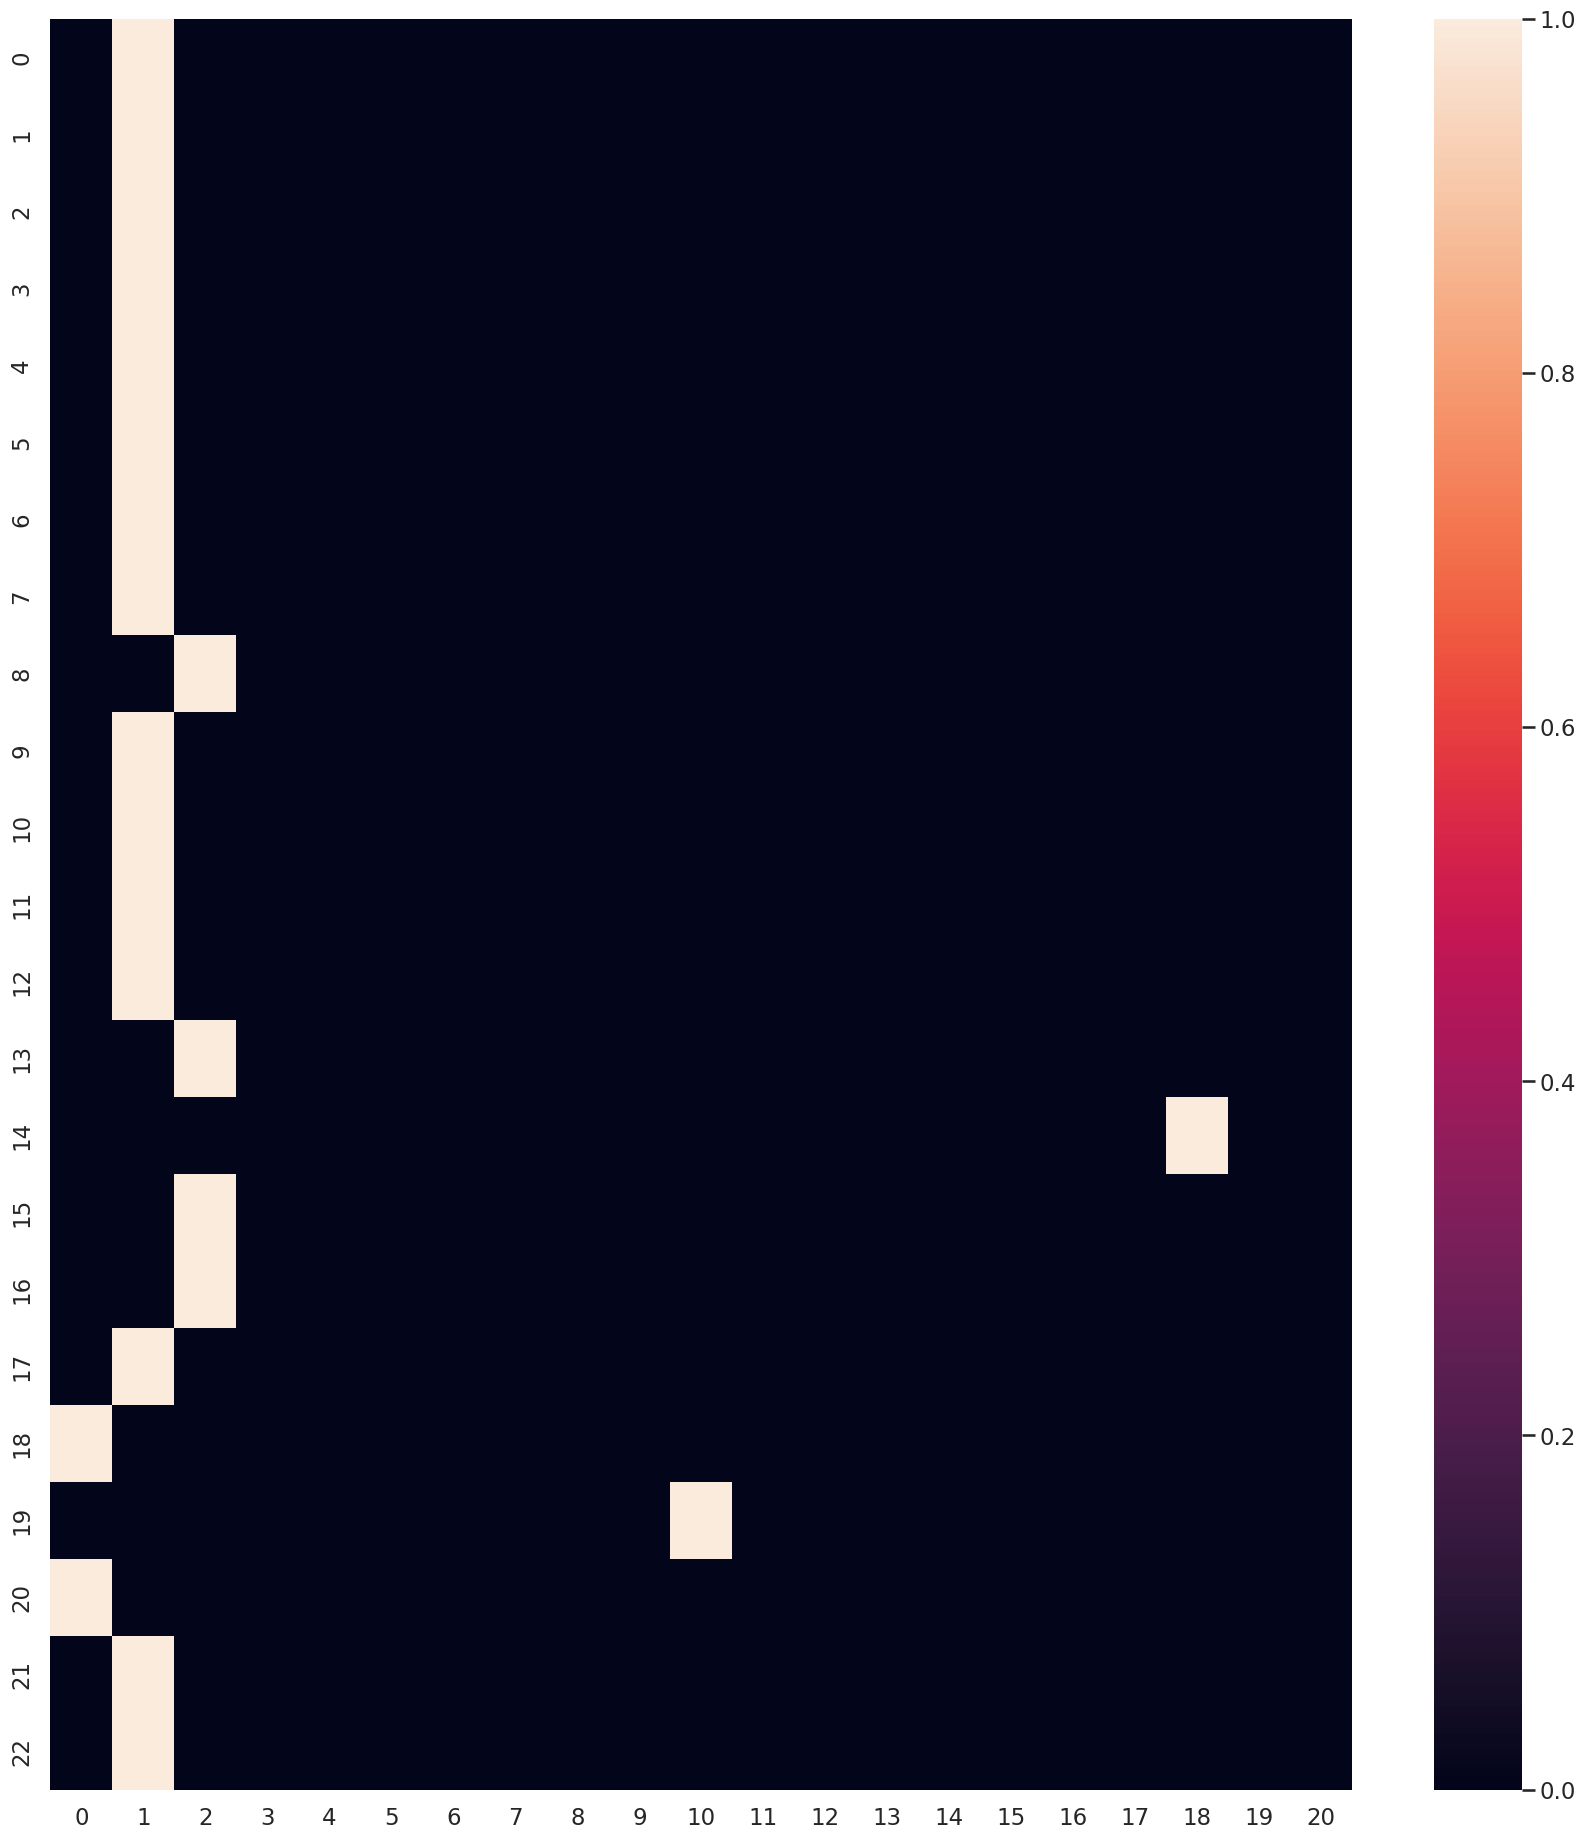

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

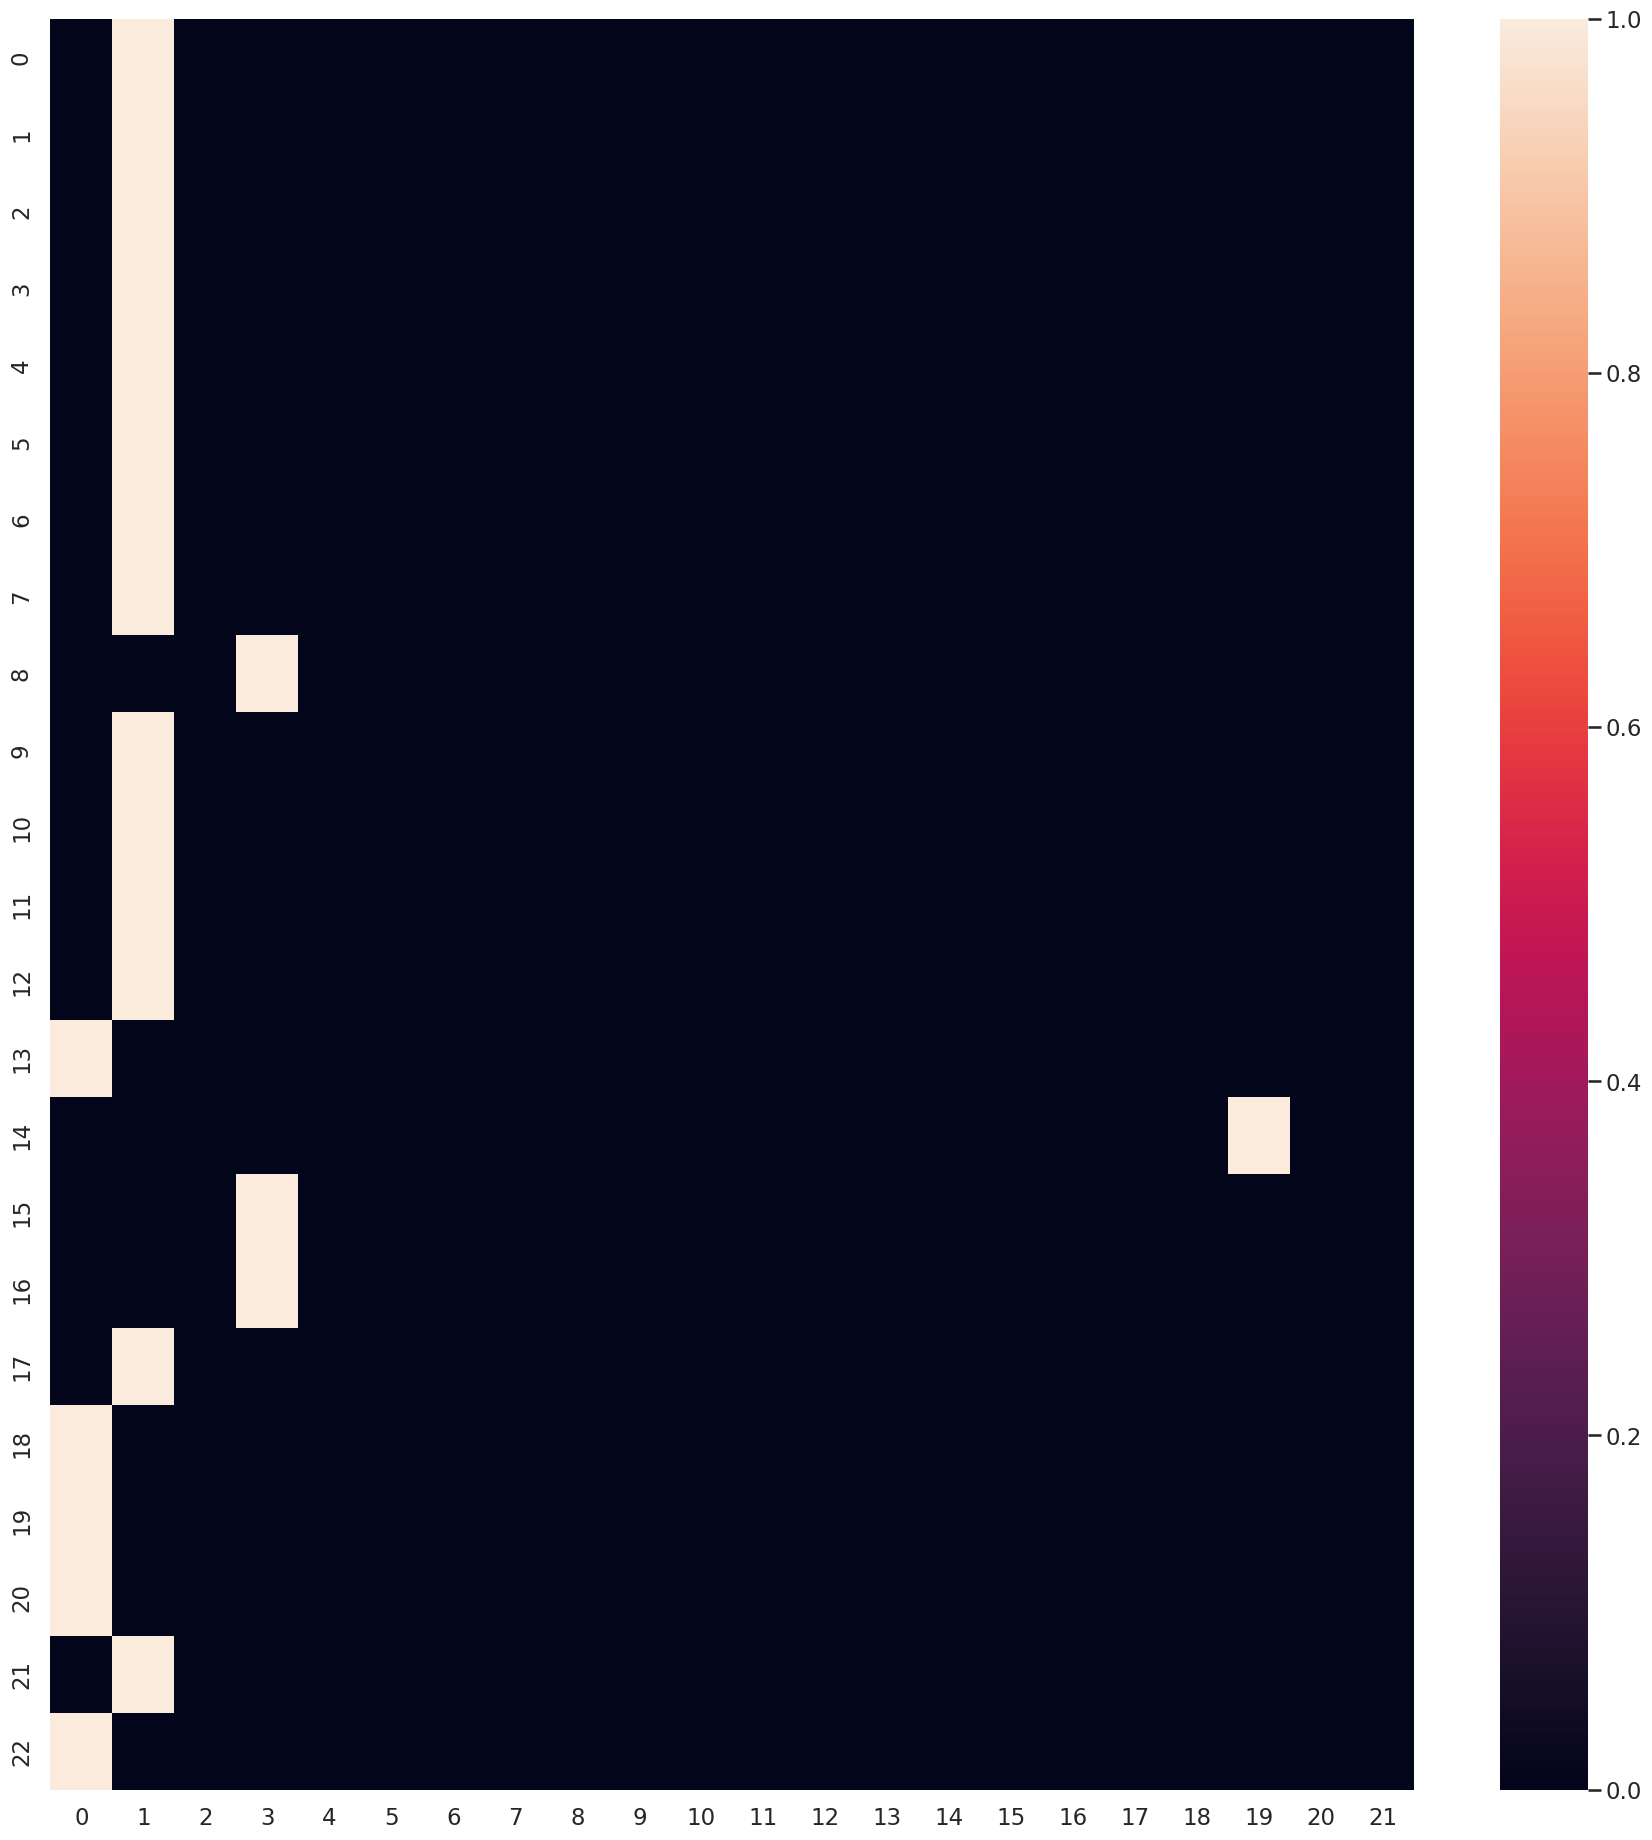

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

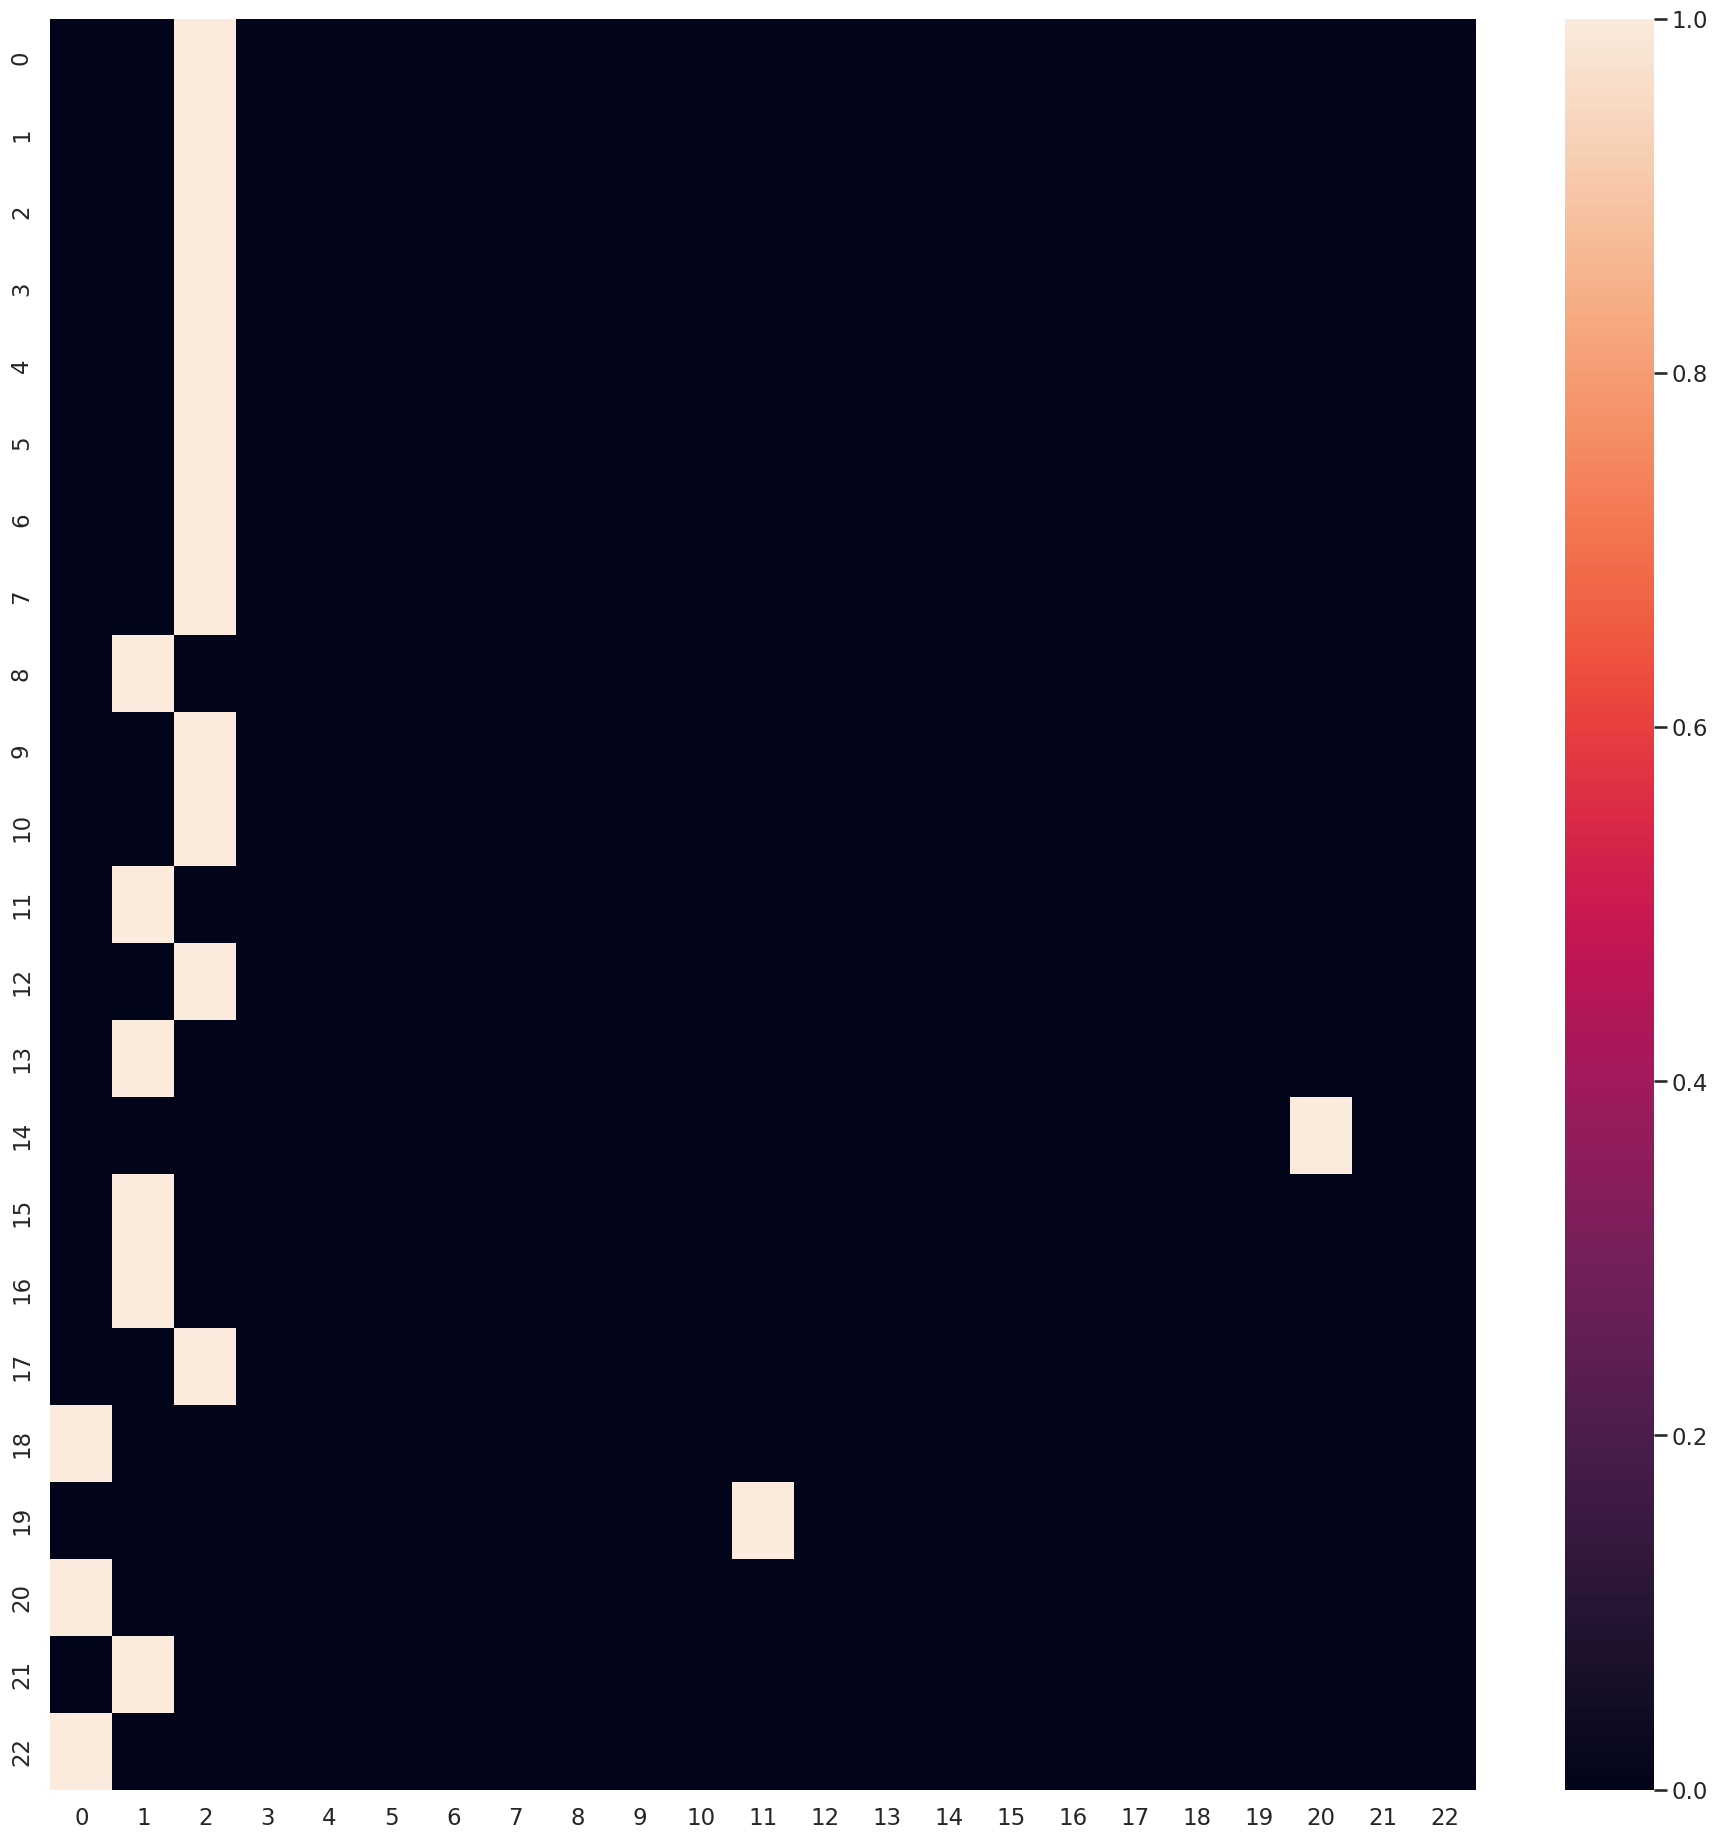

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

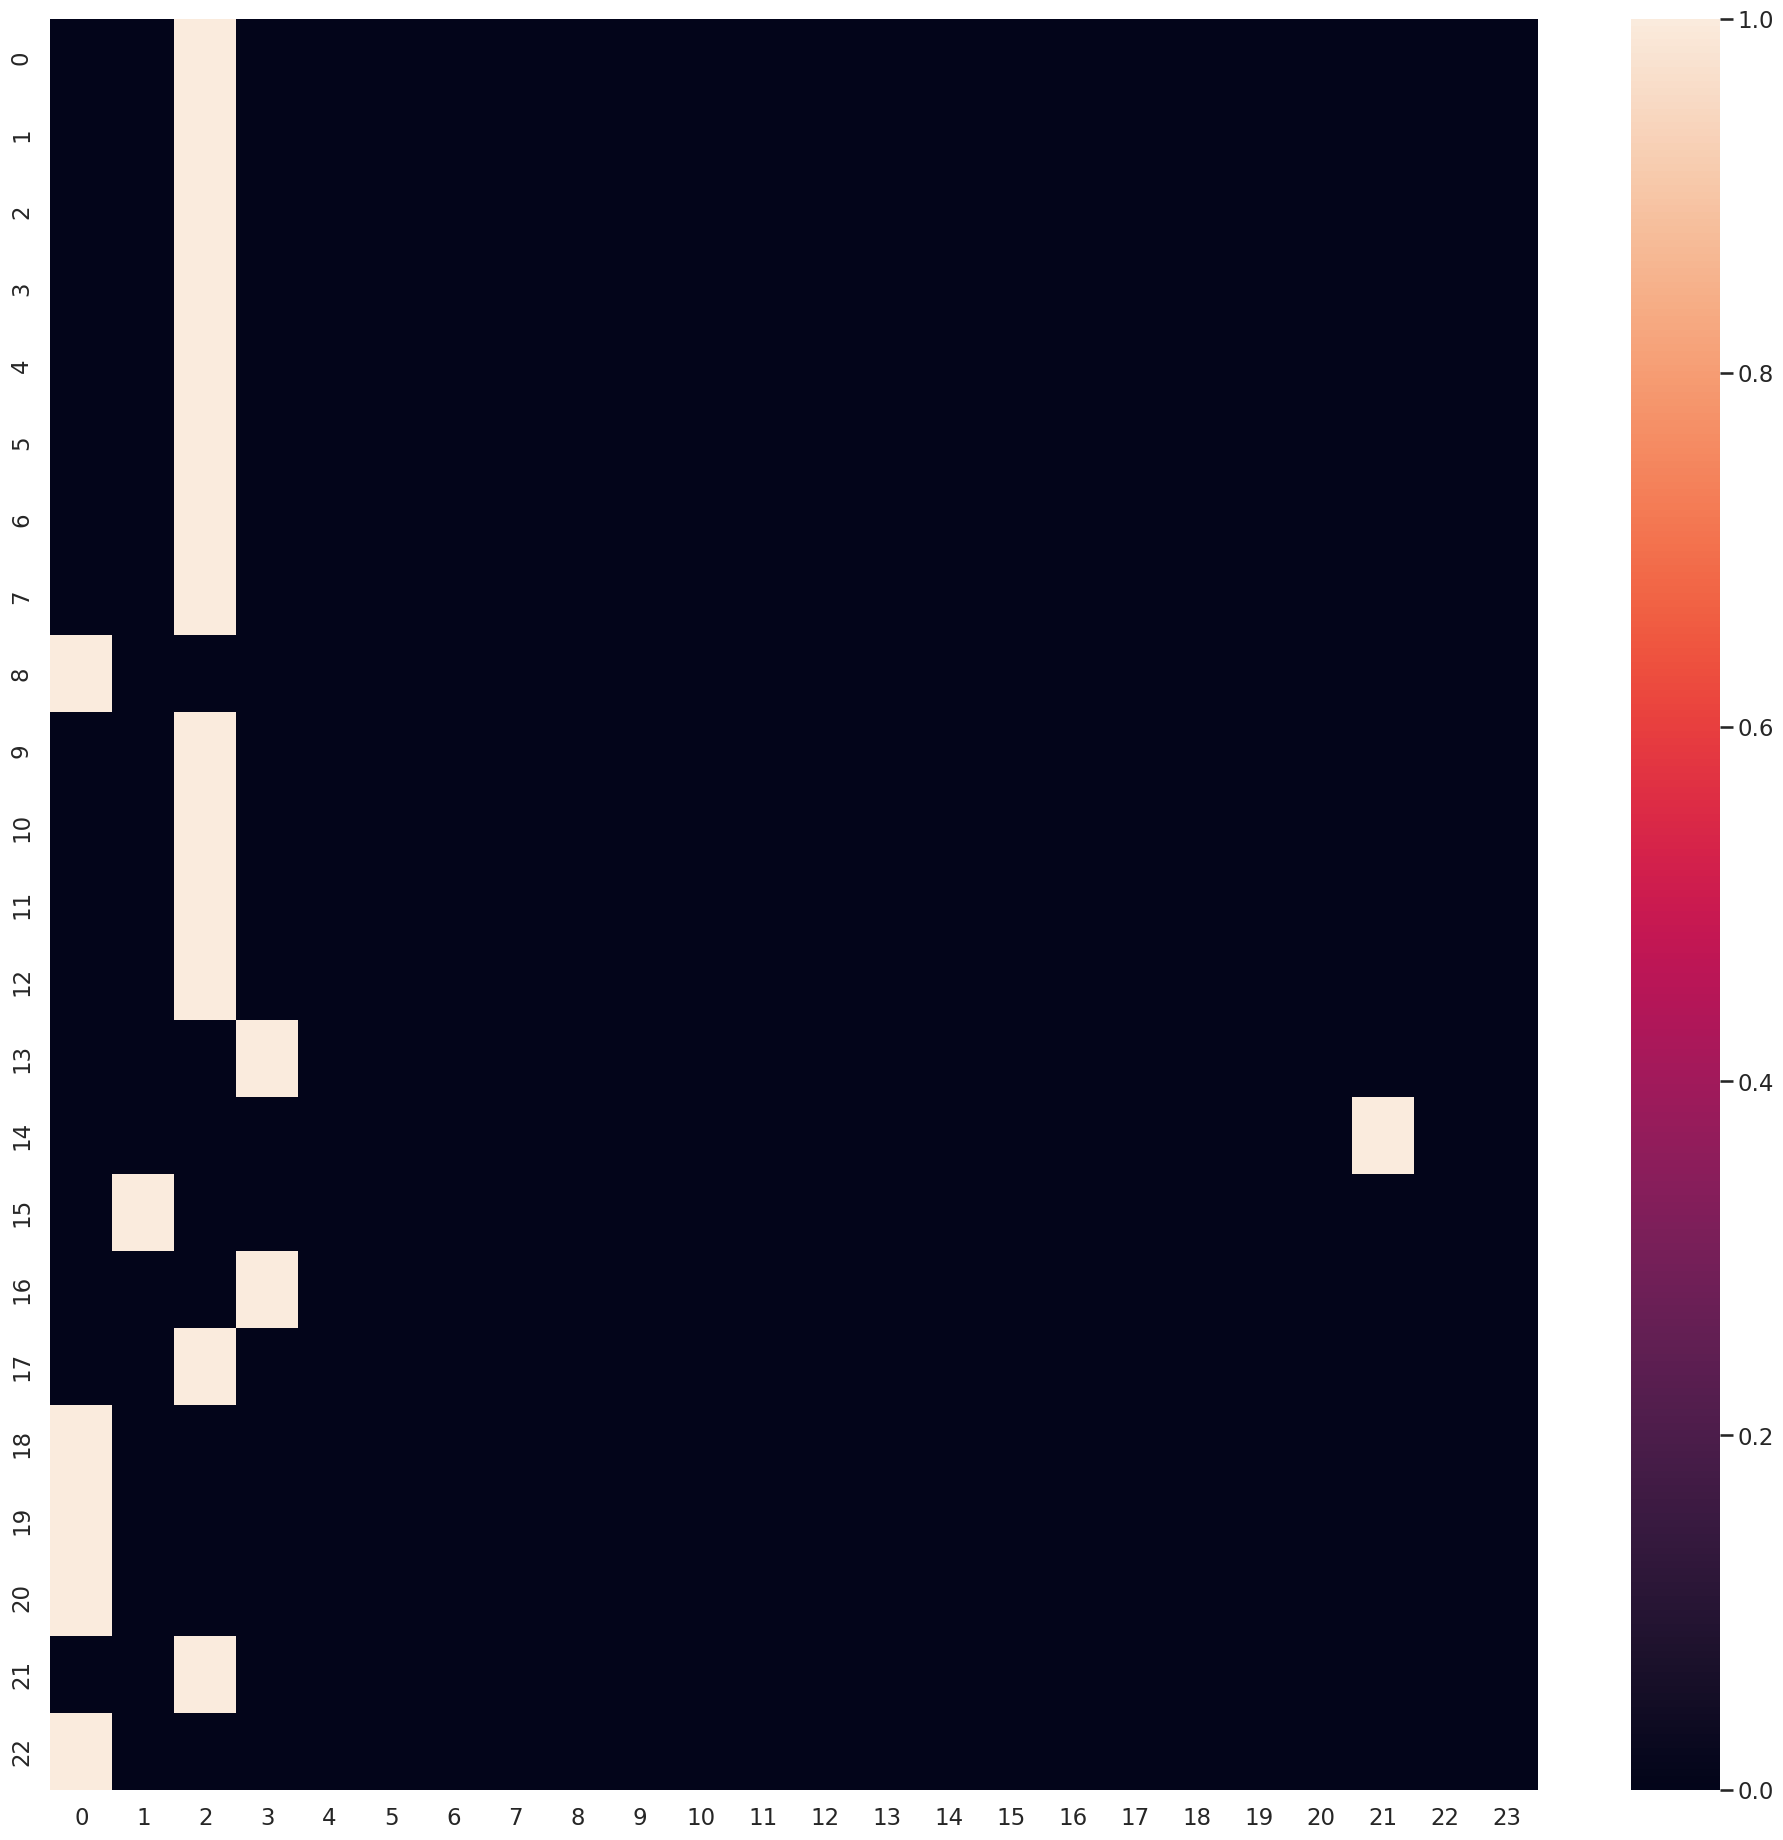

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

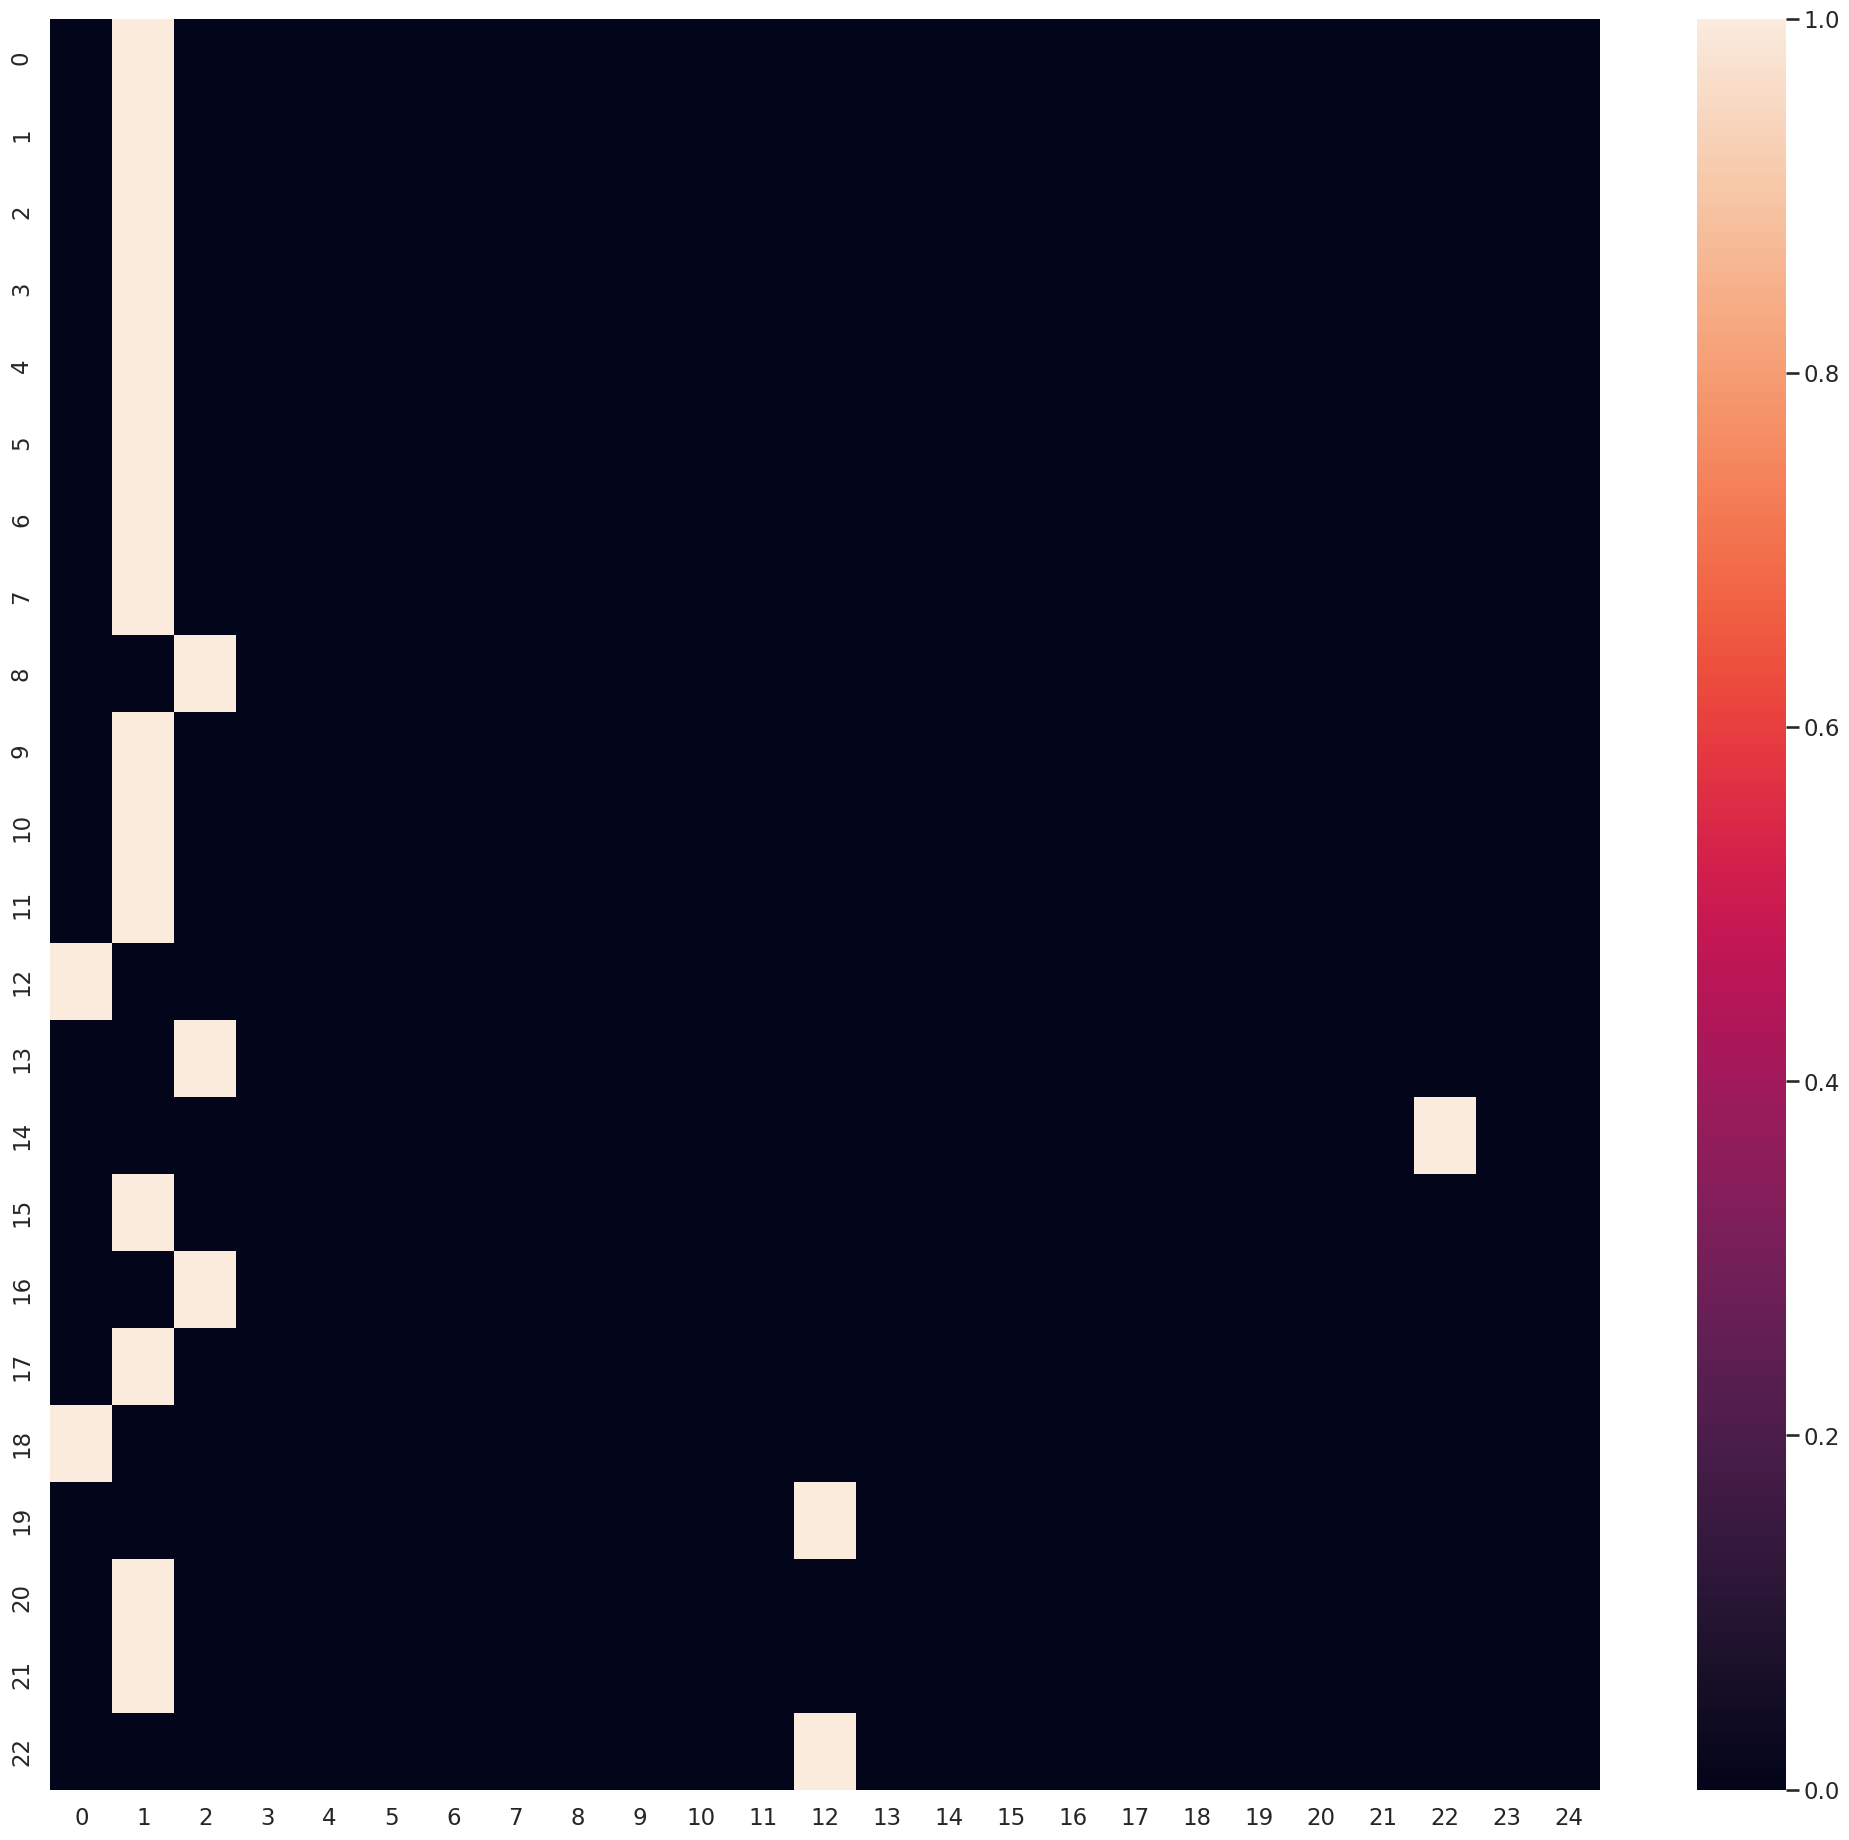

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

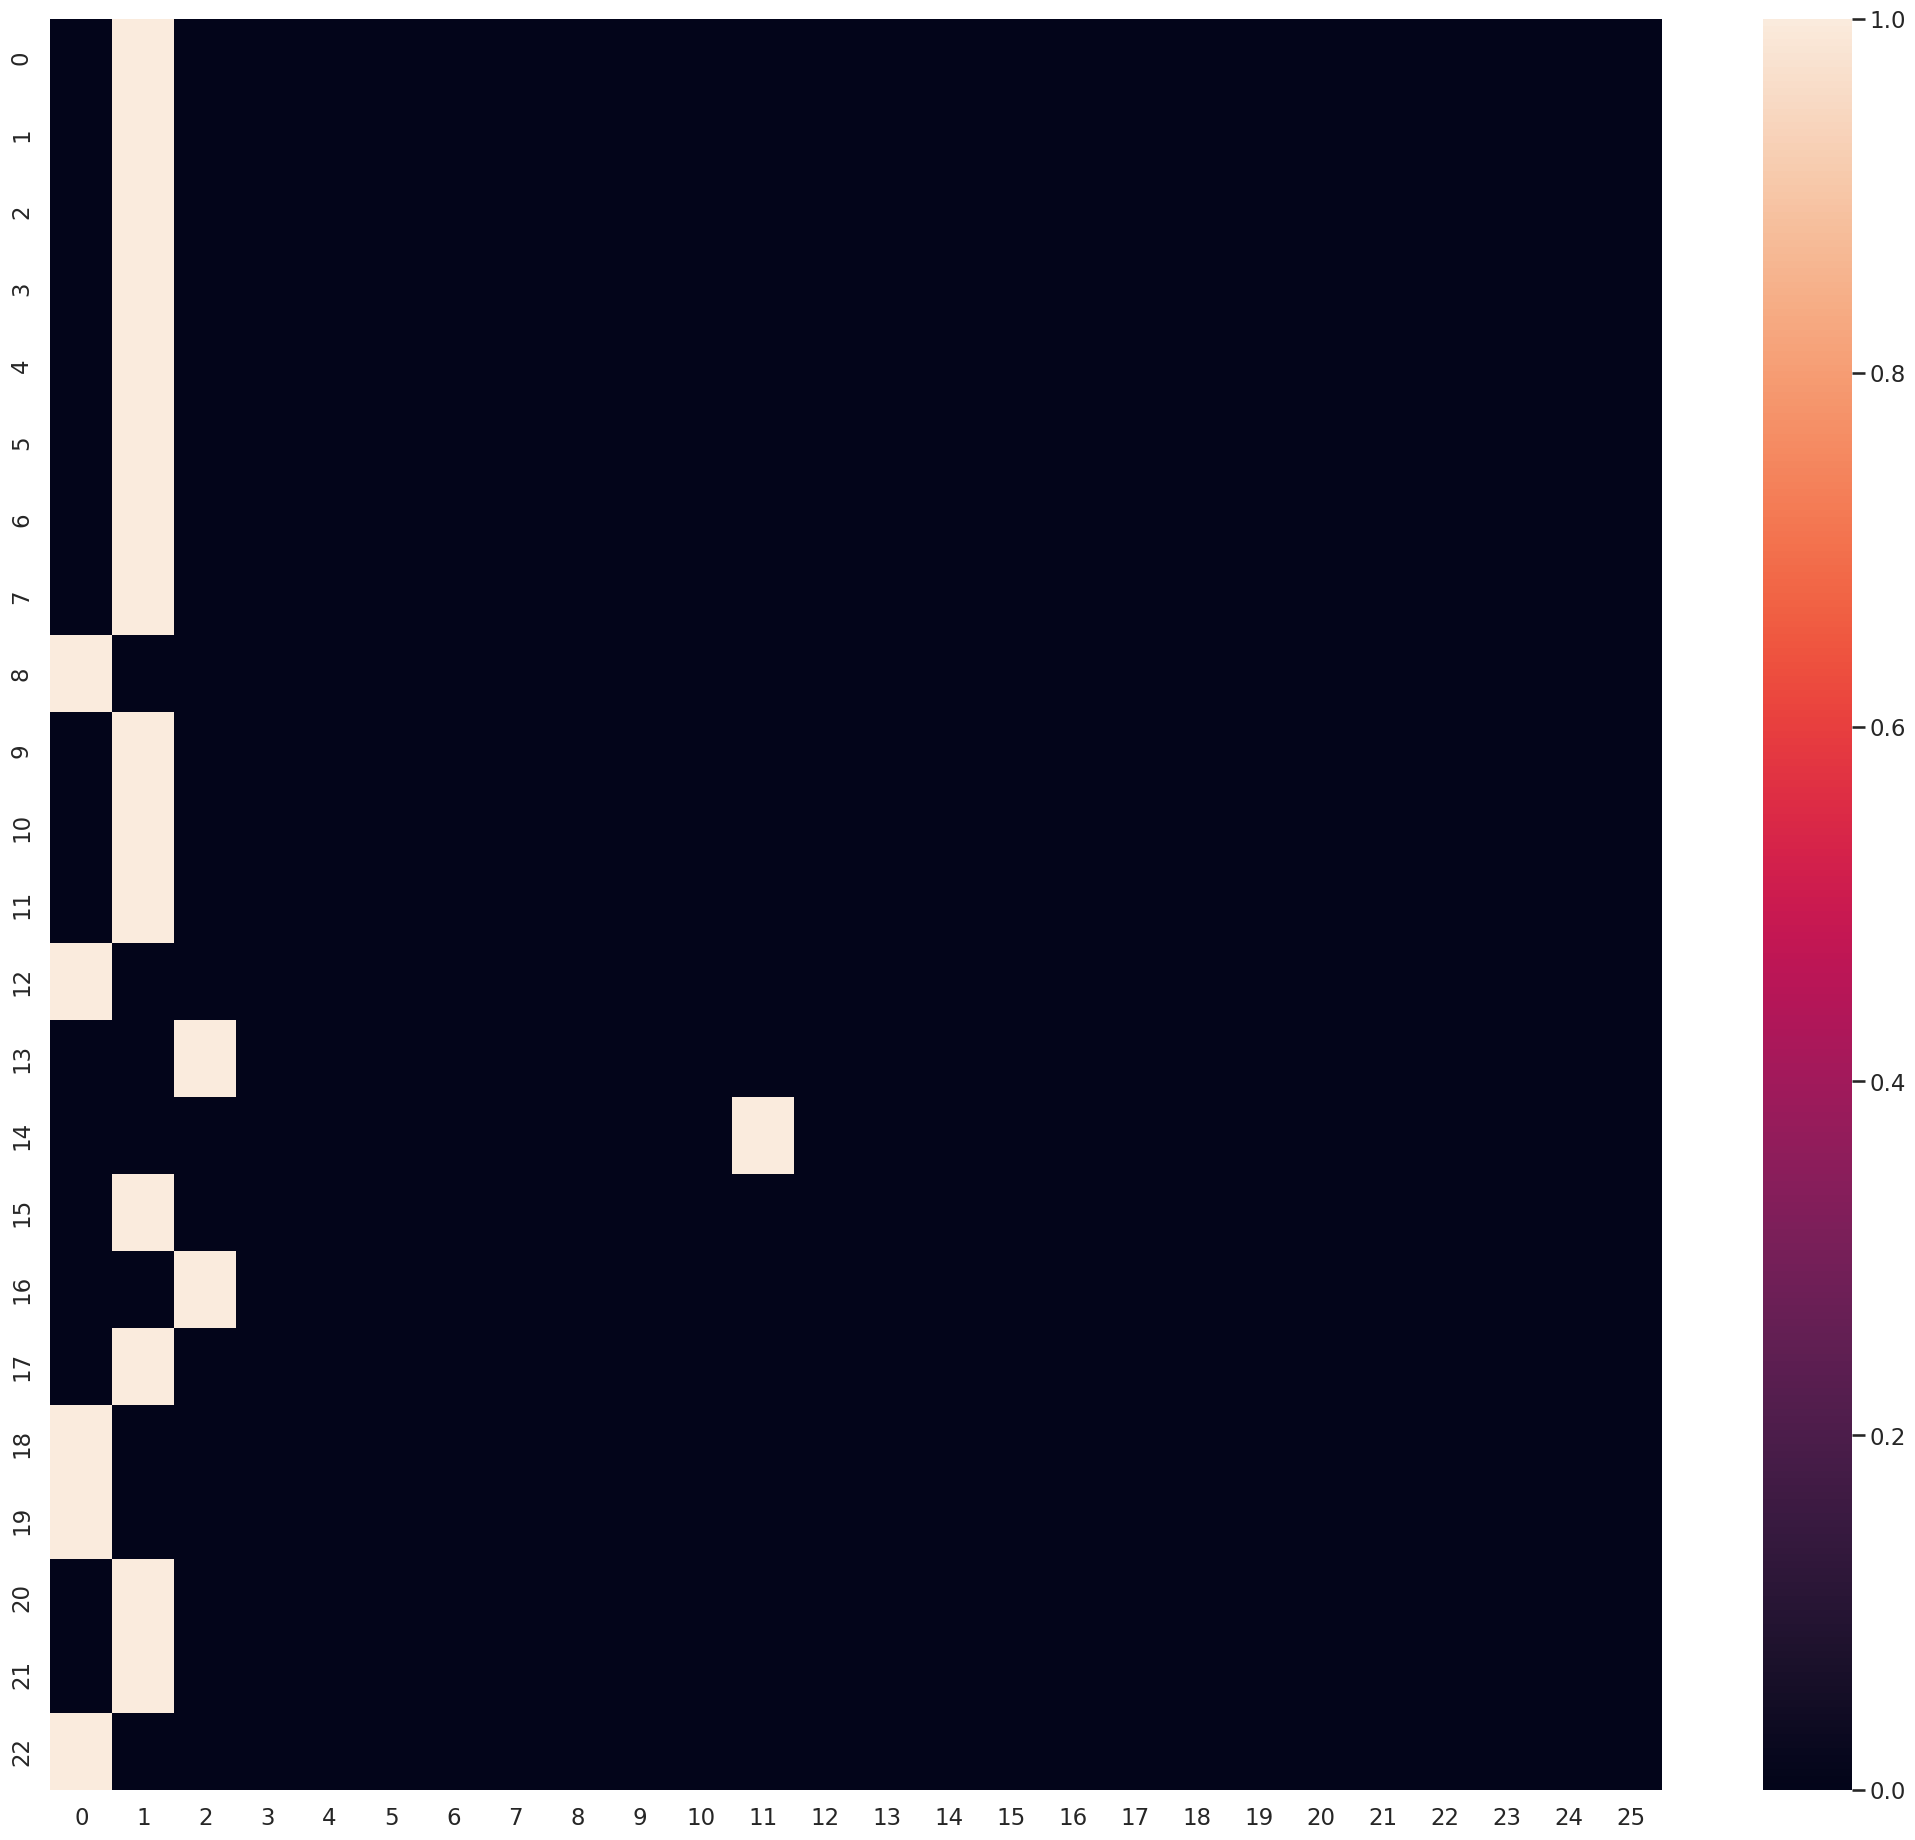

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

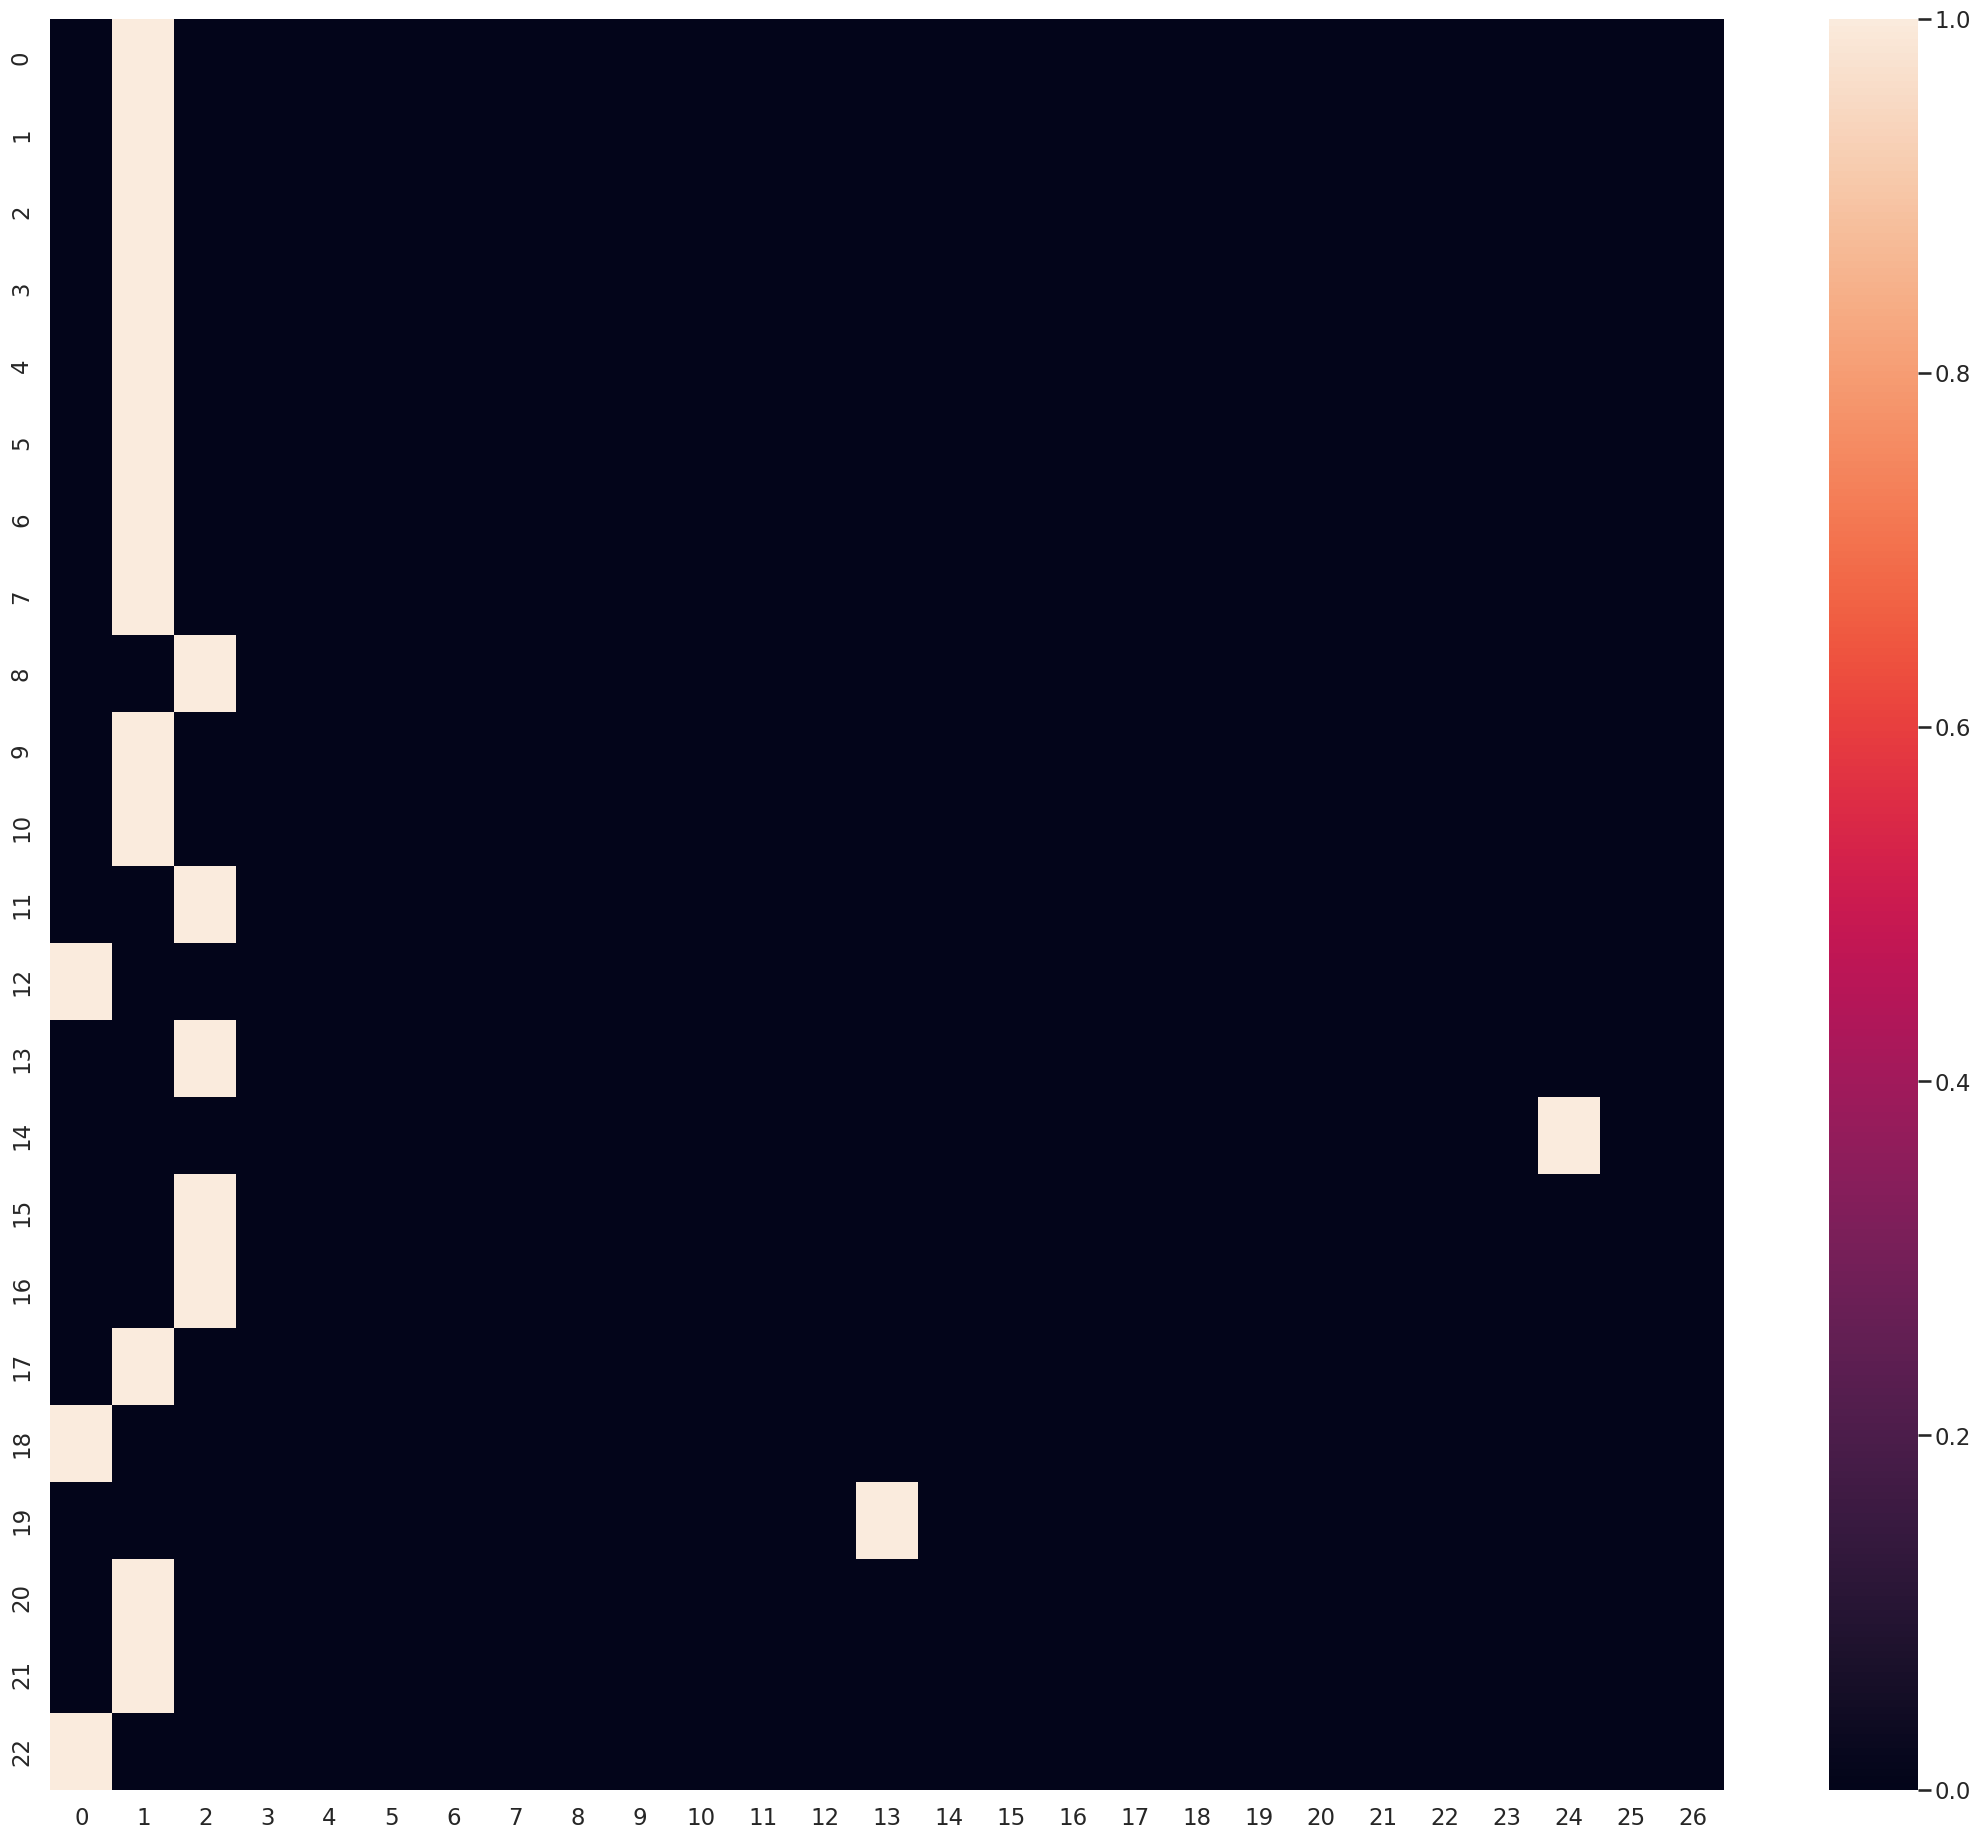

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

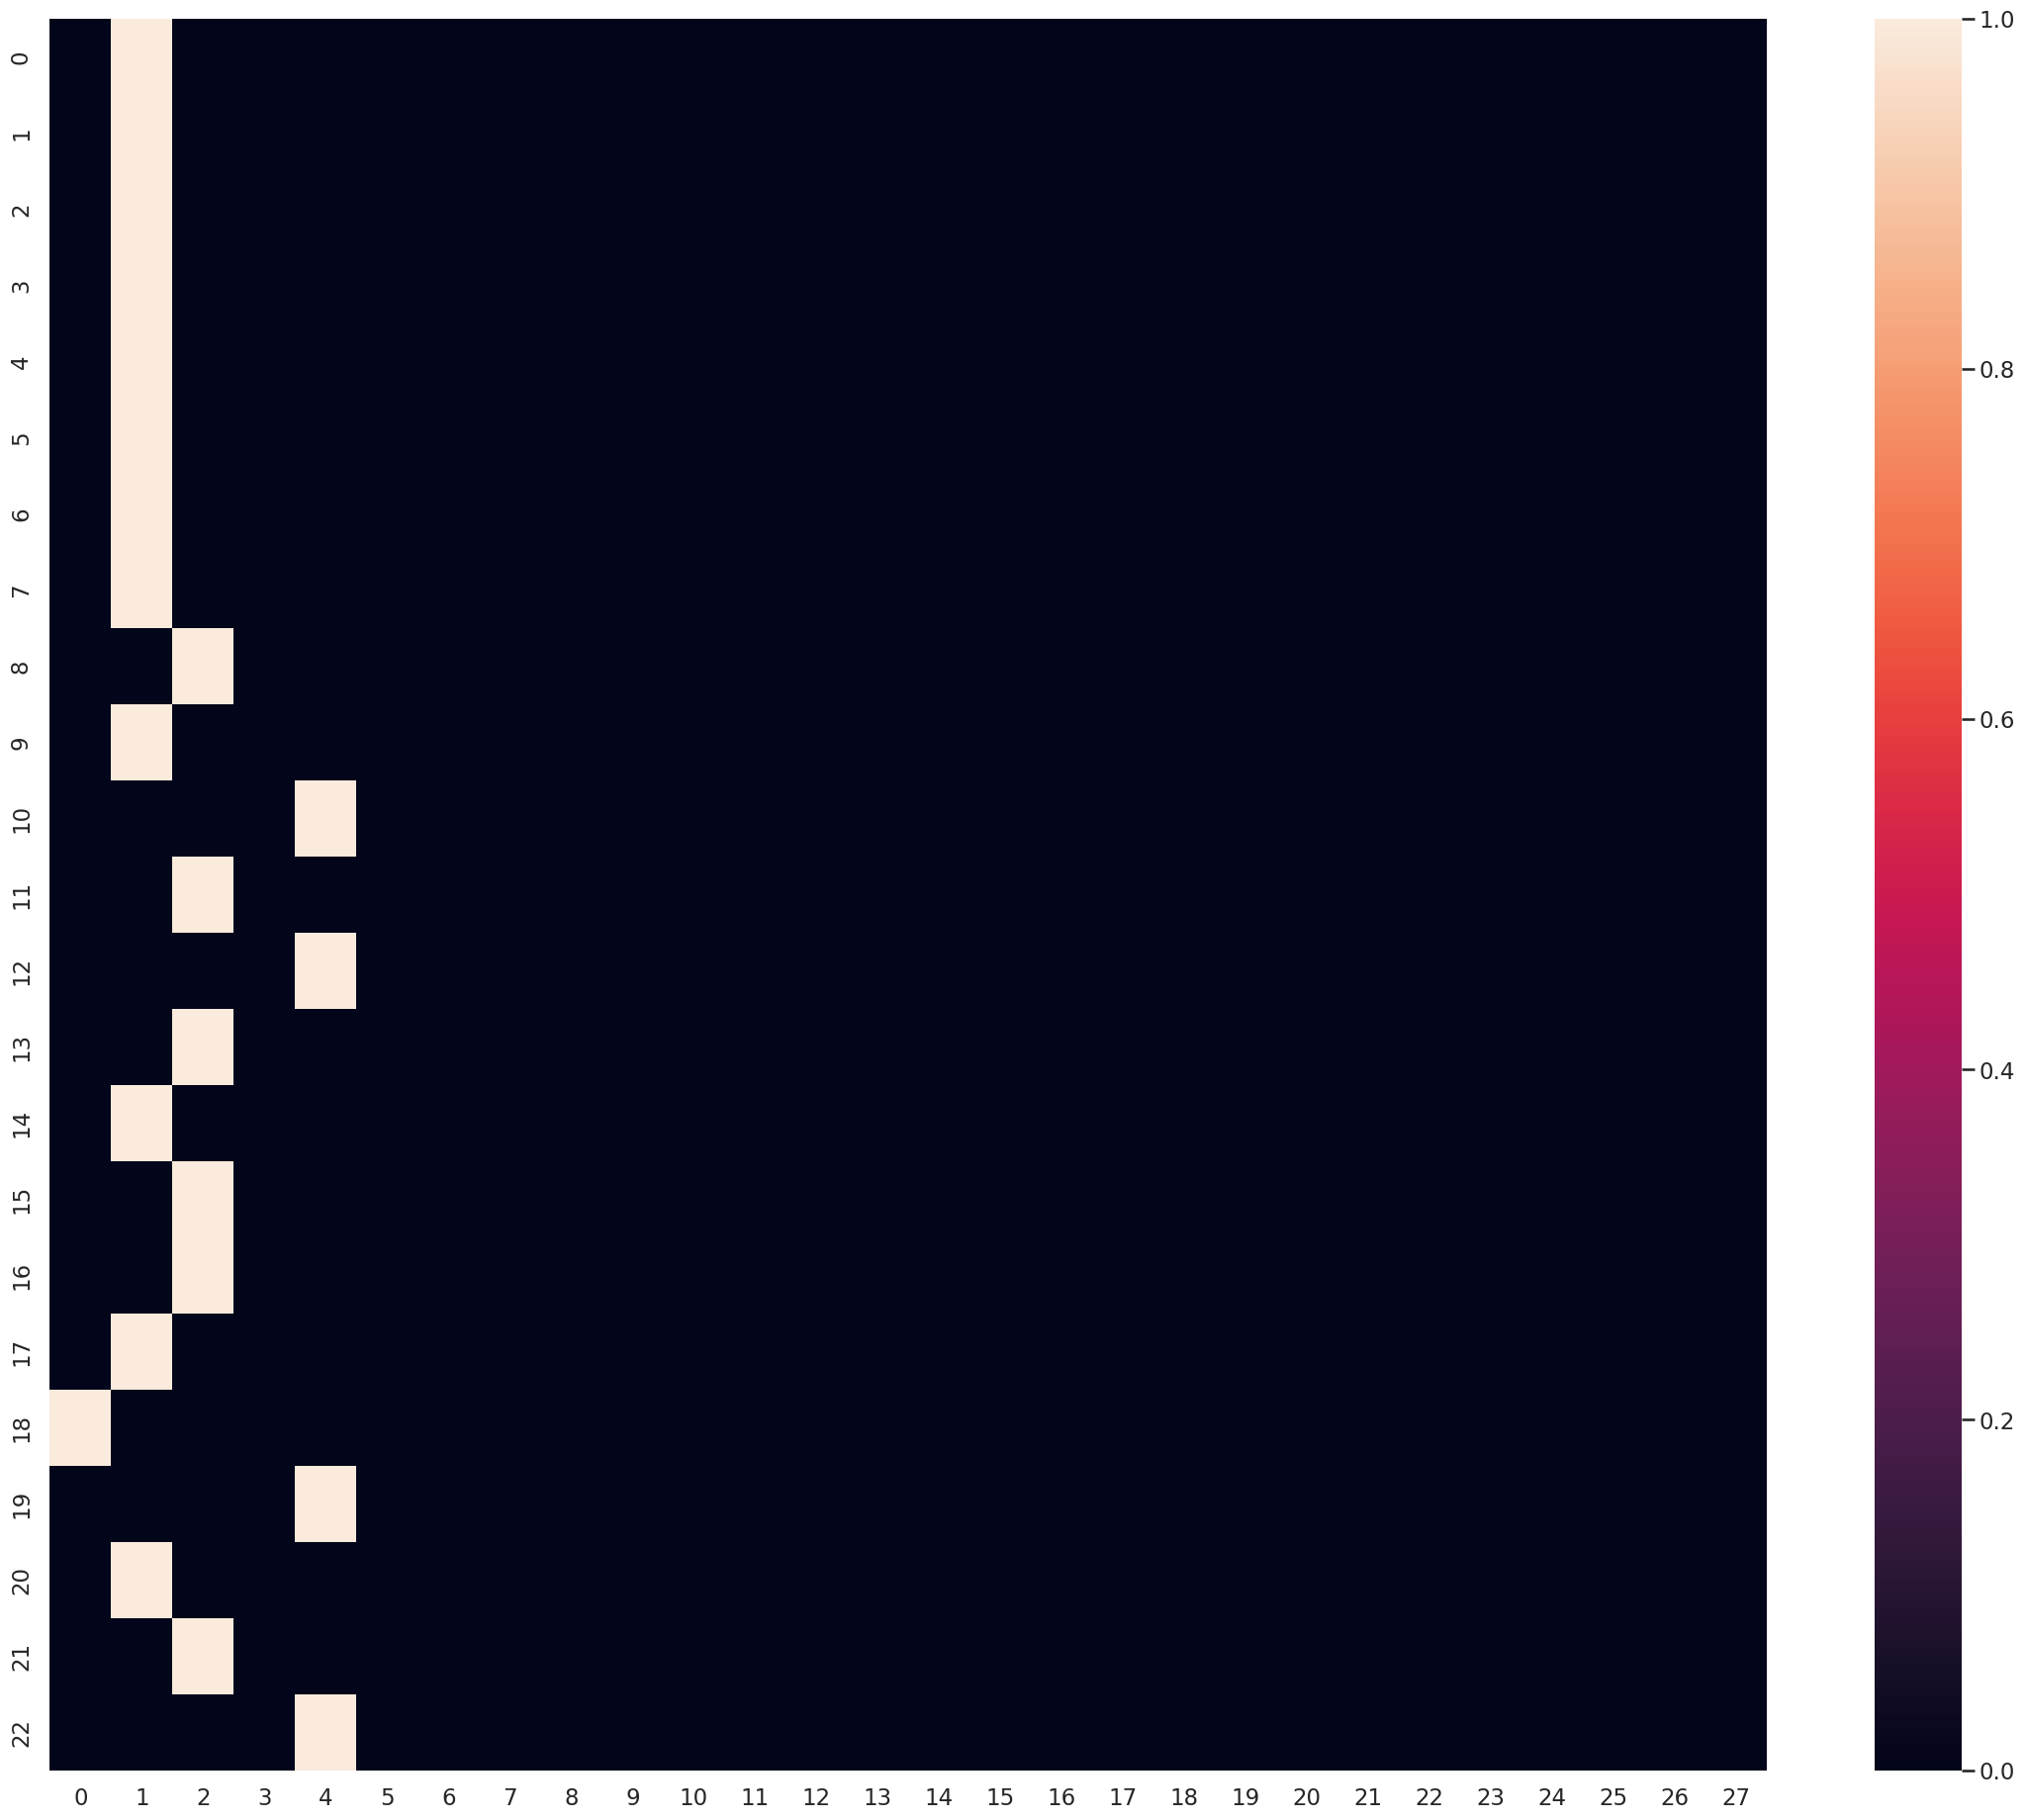

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

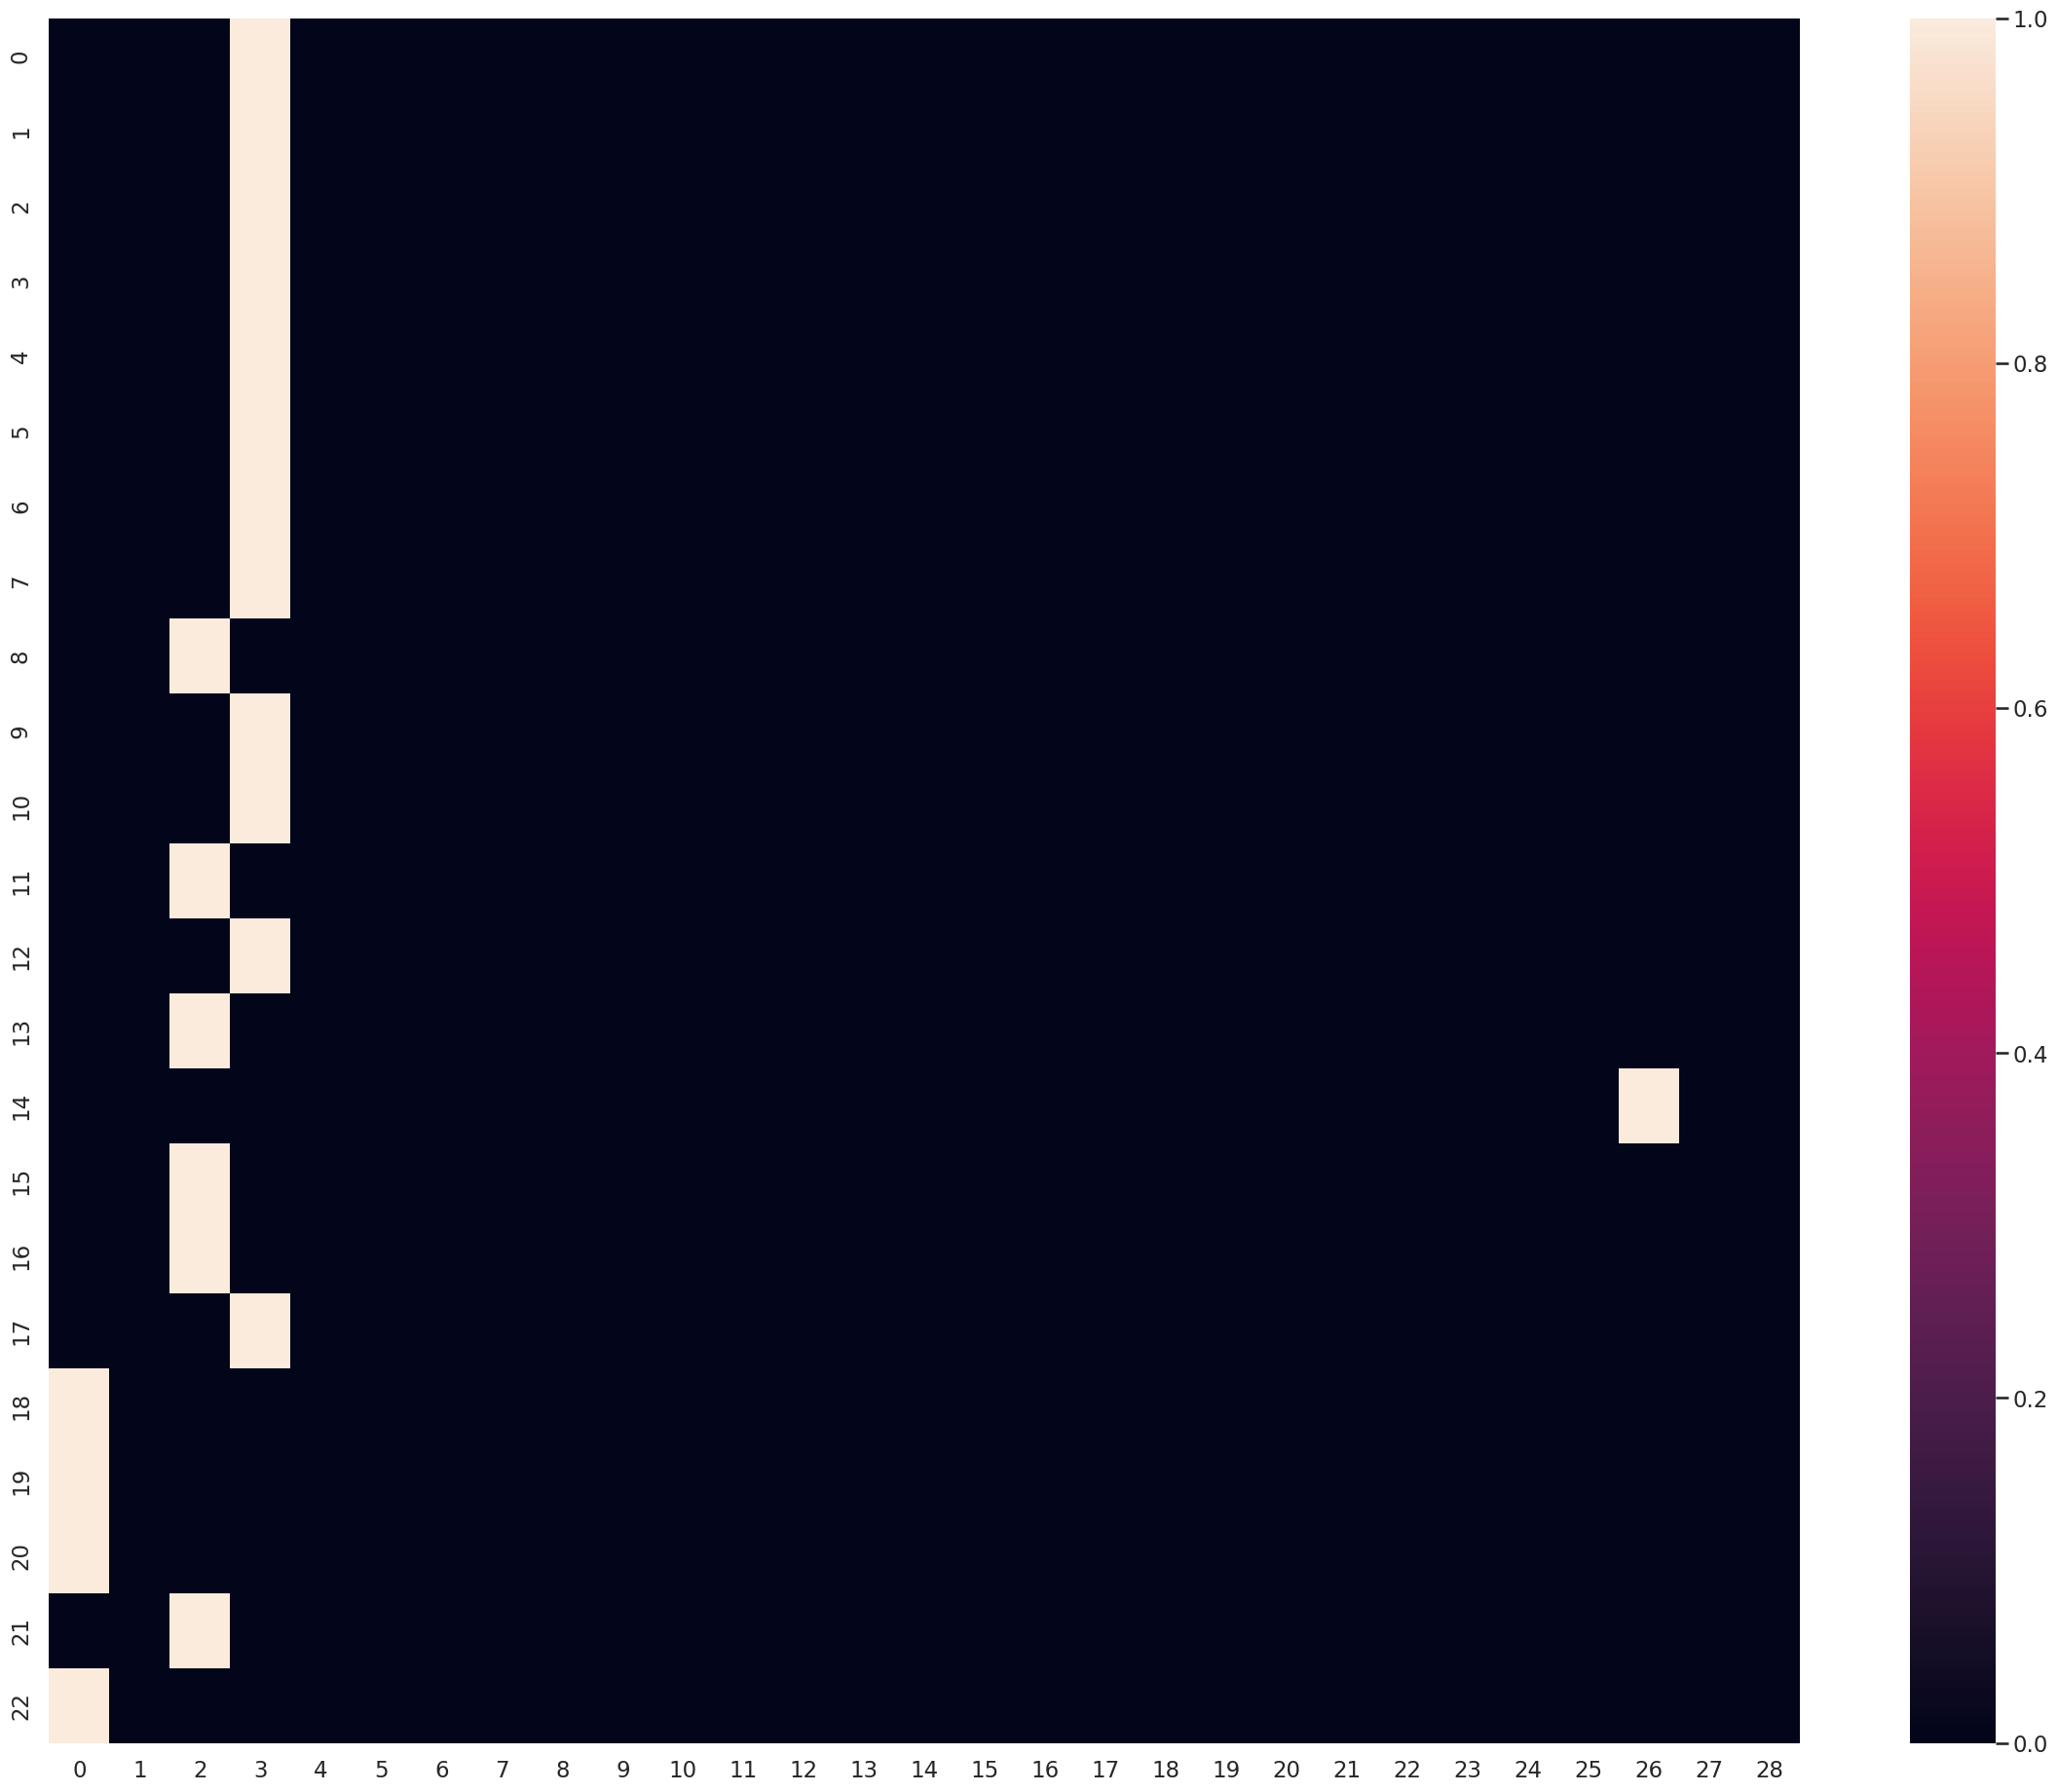

In [149]:
FEATURES = ['last_pellets_self', 'last_pellets_other', 'interval', 'last_duration', 'last_pellets_interval', 'entry']
X = Visits[FEATURES]
Y = Visits['pellet'].to_numpy().reshape(1,-1)[0]

obs = np.array(X)

for n in range(3,30):
    hmm, states, transition_mat, lls = HMM.FitHMM(obs, num_states = n, n_iters = 50)
    
    state_mean_speed = hmm.observations.params[0].T[4]
    index = np.argsort(state_mean_speed, -1) 
    new_values = np.empty_like(states)
    for i, val in enumerate(index): new_values[states == val] = i
    states_ = new_values
    
    Pred = np.zeros((max(Y)+1, n))
    for j in range(len(Y)):
        Pred[Y[j]][states_[j]] += 1
    
    Pred_ = np.zeros((max(Y)+1, n))
    for j in range(len(Pred)):
        k = np.argsort(Pred[j])[-1]
        Pred_[j][k] = 1
    
    fig, axs = plt.subplots(1, 1, figsize=(n,23))
    sns.heatmap(Pred_, ax=axs, cbar = True)
    axs.set_aspect('auto')
    plt.savefig('../Images/Social_Regression/' + 'All-Mice' + "/" + str(n) + '_Prediction.png')
    plt.show()

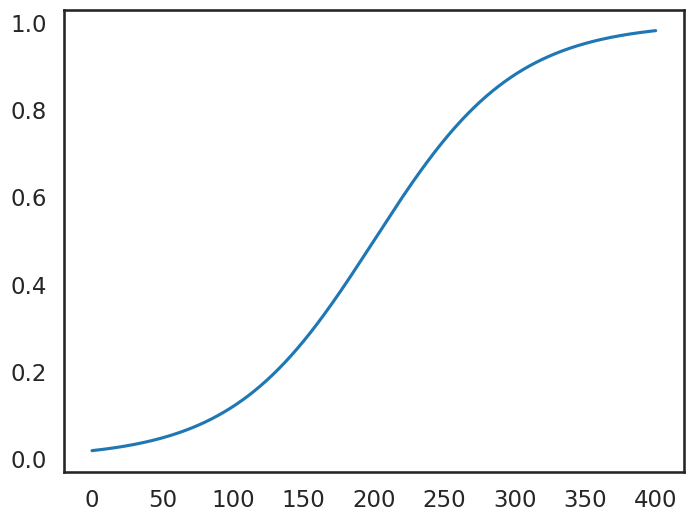

In [96]:
def sigmoid(x):
    midpoint = 200
    scale = 50
    return 1 / (1 + np.exp(-(x - midpoint) / scale))

# Generate x values
x = np.linspace(0, 400, 4000)

# Compute y values
y = sigmoid(x)

# Plot the sigmoidal function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Sigmoid Function')
plt.show()

In [3]:
'''import pandas as pd 
import numpy as np '''
INFO = pd.read_parquet('../SocialData/INFO3.parquet', engine='pyarrow')
for i in range(len(INFO)):
    start, end = INFO.loc[i, 'Start'], INFO.loc[i, 'End']
    P = np.load('../SocialData/LDS_Parameters/' + start + '_Parameters.npz', allow_pickle=True)
    sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = P['sigma_a'].item(), P['sigma_x'].item(), P['sigma_y'].item(), P['sqrt_diag_V0_value'].item(), P['B'], P['Qe'], P['m0'], P['V0'], P['Z'], P['R']
    print(sigma_x)

-8.415088435457974
-0.1252030640708731
27.93764682325884
-2.4340483944768465
91.58541519403438
5.341906437715458
1.5382140652770175


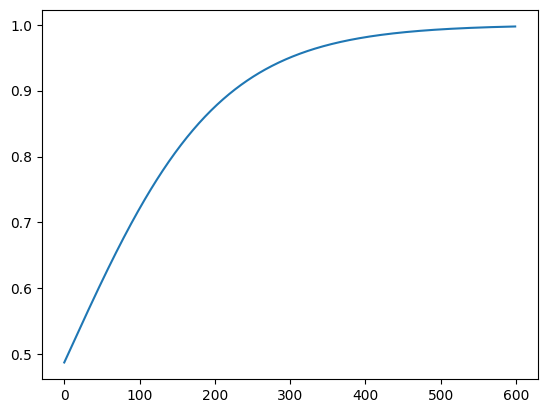

In [47]:
import matplotlib.pyplot as plt 

def sigmoid(x, midpoint, scale):
    return 1 / (1 + np.exp(-(x - midpoint) / scale))
def inverse_sigmoid(y, midpoint, scale):
    y = Normalization(y)
    x = - scale * np.log(1 / y - 1) + midpoint
    return x

def Normalization(x):
    if min(x) < 0 or max(x) > 1:
        min_val = np.min(x) - 1e-10
        max_val = np.max(x) + 1e-10
        x = (x - min_val) / (max_val - min_val)
    return x 

x = np.arange(0,600,1)
plt.plot(x,sigmoid(x, midpoint=5, scale=100))
plt.show()

In [29]:
(200-143)*45/2/60

21.375

In [22]:
29382 / 95

309.2842105263158

In [23]:
13600 / 95

143.1578947368421

In [1]:
import numpy as np
import pandas as pd 
type, mouse = 'Pre', 'BAA-1104047'
mouse_pos = pd.read_parquet('../SocialData/HMMData/' + type + "_" + mouse + '.parquet', engine='pyarrow')
states = np.load('../SocialData/HMMStates/' + type + "_" + mouse + "_States.npy", allow_pickle = True)
mouse_pos['state'] = pd.Series(states, index = mouse_pos.index)

grouped = mouse_pos.groupby([pd.Grouper(freq='10S'), 'state']).size()
prob = grouped.groupby(level=0).apply(lambda g: g / g.sum())
states_prob = prob.unstack(level=-1).fillna(0)
states_prob.index = states_prob.index.get_level_values(0)
states_prob

state,0,1,2,3,4,5,6,7,8,9,10,11
2024-02-05 15:43:10,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
2024-02-05 15:43:20,0.0,0.0,0.0,0.000000,0.0,0.0,0.300000,0.0,0.240000,0.460000,0.000000,0.000000
2024-02-05 15:43:30,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.380000,0.200000,0.000000,0.420000
2024-02-05 15:43:40,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.080000,0.210000,0.000000,0.710000
2024-02-05 15:43:50,0.0,0.0,0.0,0.170000,0.0,0.0,0.100000,0.0,0.140000,0.070000,0.000000,0.520000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-08 14:47:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.050000,0.250000,0.250000,0.450000
2024-02-08 14:47:10,0.0,0.0,0.0,0.000000,0.0,0.0,0.040000,0.0,0.340000,0.240000,0.150000,0.230000
2024-02-08 14:47:20,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.070000,0.080000,0.130000,0.720000
2024-02-08 14:47:30,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.190000,0.110000,0.070000,0.630000


In [4]:
states_prob['CR'] = 0
CR_index_1 = states_prob[states_prob.index.hour < 7].index
CR_index_2 = states_prob[states_prob.index.hour > 19].index
CR_index = CR_index_1.union(CR_index_2).sort_values()
states_prob.loc[CR_index, 'CR'] = 1
states_prob

state,0,1,2,3,4,5,6,7,8,9,10,11,CR
2024-02-05 15:43:10,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0
2024-02-05 15:43:20,0.0,0.0,0.0,0.000000,0.0,0.0,0.300000,0.0,0.240000,0.460000,0.000000,0.000000,0
2024-02-05 15:43:30,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.380000,0.200000,0.000000,0.420000,0
2024-02-05 15:43:40,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.080000,0.210000,0.000000,0.710000,0
2024-02-05 15:43:50,0.0,0.0,0.0,0.170000,0.0,0.0,0.100000,0.0,0.140000,0.070000,0.000000,0.520000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-08 14:47:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.050000,0.250000,0.250000,0.450000,0
2024-02-08 14:47:10,0.0,0.0,0.0,0.000000,0.0,0.0,0.040000,0.0,0.340000,0.240000,0.150000,0.230000,0
2024-02-08 14:47:20,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.070000,0.080000,0.130000,0.720000,0
2024-02-08 14:47:30,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.190000,0.110000,0.070000,0.630000,0


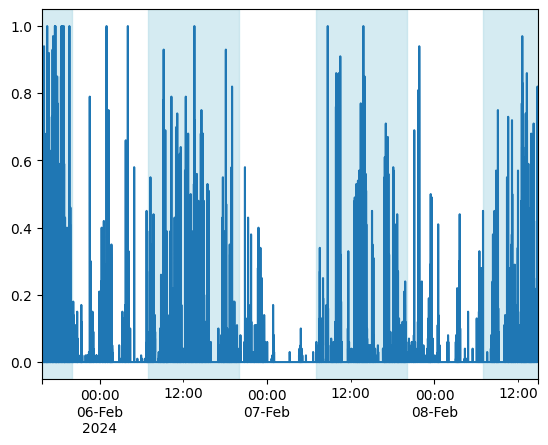

In [14]:
import matplotlib.pyplot as plt 
groups = states_prob['CR'].ne(states_prob['CR'].shift()).cumsum()
zero_groups = states_prob[states_prob['CR'] == 0].groupby(groups).groups
zero_groups = list(zero_groups.values())

START = []
END = []
for i in range(len(zero_groups)):
    start = zero_groups[i][0]
    end = zero_groups[i][-1]
    START.append(start)
    END.append(end)

states_prob[10].plot()
for t in range(len(START)):
    plt.axvspan(START[t],END[t], color='lightblue', alpha=0.5)
plt.show()

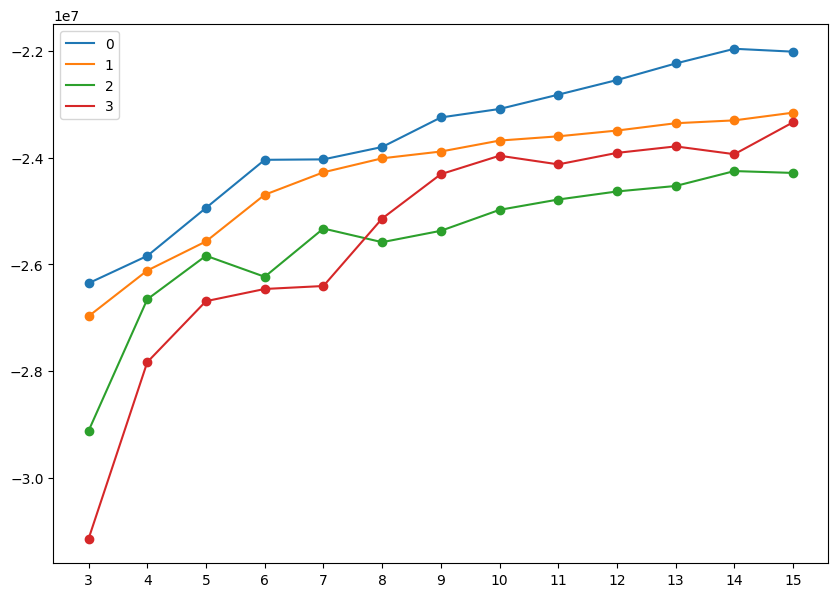

In [19]:
LogLikelihood = np.load('../SocialData/HMMData/LogLikelihood_Body.npy', allow_pickle=True)
N = np.arange(3,16)
fig, axs = plt.subplots(1,1,figsize = (10,7))
for i in range(len(LogLikelihood)):
    loglikelihood = LogLikelihood[i]
    axs.scatter(N, loglikelihood)
    axs.plot(N, loglikelihood, label = i)
axs.set_xticks(N)
axs.legend()
plt.savefig('../Images/Social_HMM_Body/StateNumber.png')
plt.show()

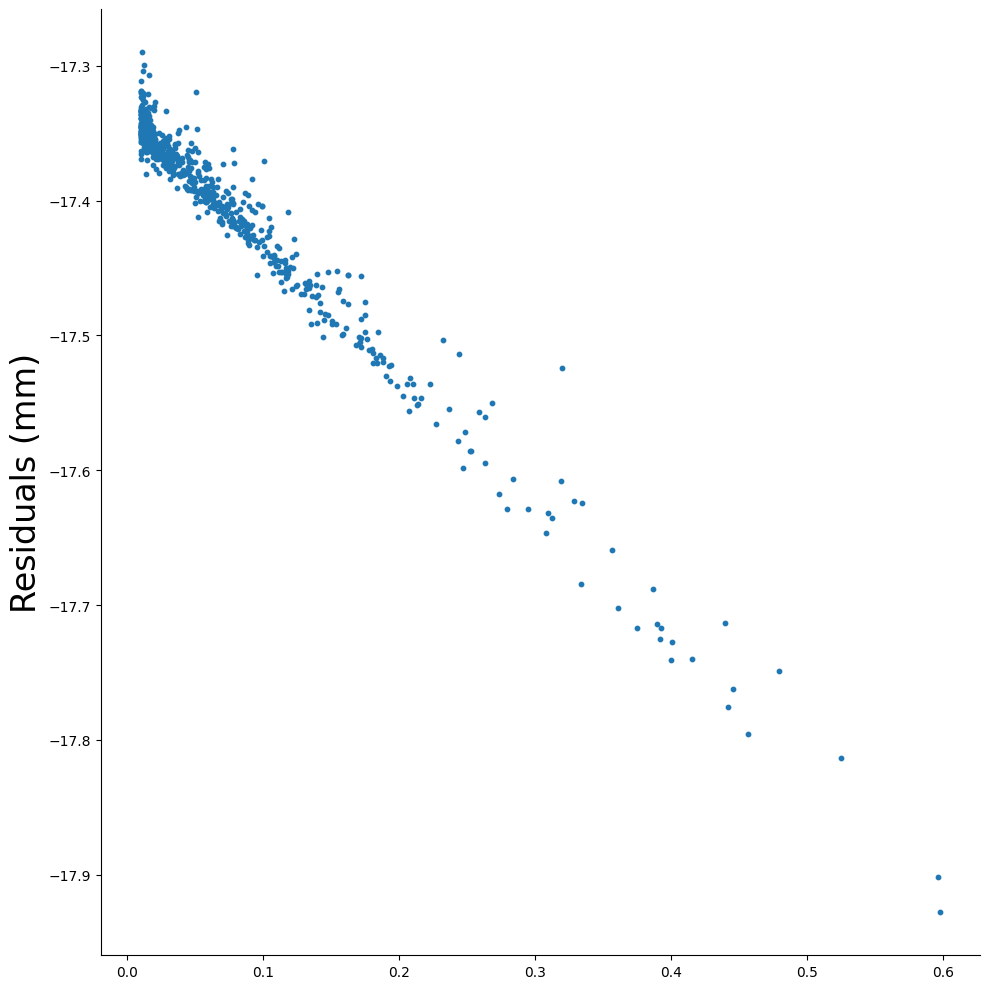

-17.409933869052384


In [87]:
obs_ = obs/1e3
pred_ = np.exp(pred/1e3)
pred_ = pred_ - 18.4
pred_ = 1 * pred_
    
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.scatter(obs_, pred_-obs_, s = 10)    
axs.set_ylabel('Residuals (mm)', fontsize = 24)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
#axs.legend(fontsize = 20)
#axs.set_ylim((-max(obs_), max(obs_)))

plt.tight_layout()
plt.show()

print(np.mean(pred_-obs_))

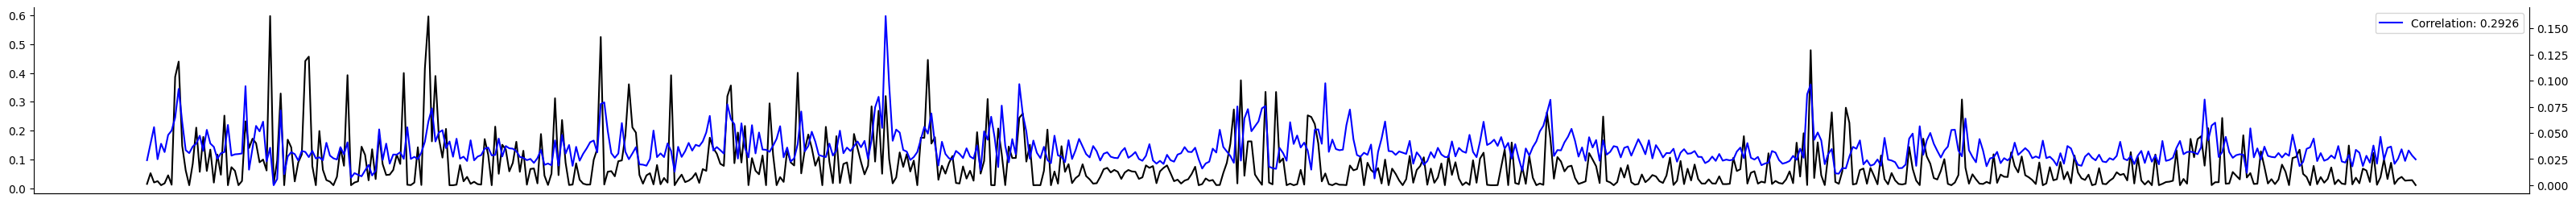

In [88]:
pred_ = pred_ - np.min(pred_)
N = np.arange(0, len(pred), 1)
'''obs = obs.to_numpy().reshape(1,-1)[0]
pred = pred.to_numpy().reshape(1,-1)[0]'''

fig, axs = plt.subplots(1, 1, figsize=(40, 3), sharex=True)
axs.plot(N, obs_, color = 'black')
axs.set_xticks([]) 
axs.set_facecolor('white') 
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

axs_ = axs.twinx()
axs_.plot(N, pred_, color = 'blue', label = 'Correlation: '+str(round(np.corrcoef(obs, pred)[0,1],4)))
axs_.set_xticks([]) 
axs_.set_facecolor('white') 
axs_.spines['top'].set_visible(False)
axs_.spines['left'].set_visible(False)
axs_.legend()


plt.show()

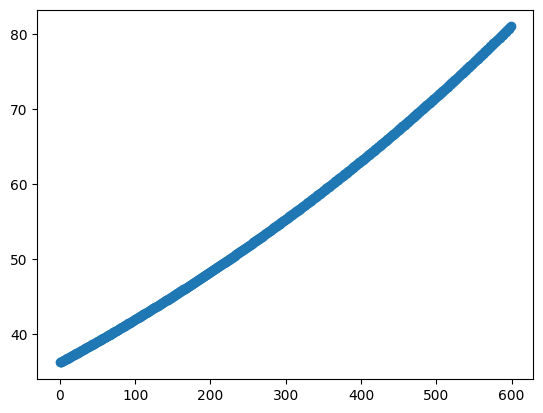

In [84]:
y = np.arange(0,600,1)
pred_ = np.exp(y/1e3+4)
pred_ = pred_ - 18.4
plt.scatter(y, pred_)
plt.show()